In [2]:
# Suppress all warnings
import warnings
warnings.simplefilter("ignore")

# Importing packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import holidays
import xgboost as xgb
import keras 
import itertools

from statsmodels.tsa.stattools import adfuller

from pandas.plotting import autocorrelation_plot, lag_plot

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

from scipy.stats import zscore

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

from xgboost import plot_importance, plot_tree, XGBRegressor

from keras.layers import LSTM, Dense, Dropout, Input, Bidirectional, BatchNormalization
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from keras.regularizers import l1_l2
from keras.optimizers import Adam

from math import sqrt

plt.style.use('fivethirtyeight')

# Loading data
df = pd.read_csv('initial_data2.csv')

# Converting Date column to Datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Ava's Time Series Vaccine Rate Prediction Project Final Report

## I. Abstract

## II. Project and Data Overview

### A. Project Overview

Using a CDC database of weekly-reported vaccine equity data at an United States state level, we seek to predict the percent of people in a county who have completed a primary series of a vaccination and received a booster dose. This data will be cleaned and organized for use in a time series prediction model. Some of the predictors for this project. Users of the model may include vaccine manufacturers who are seeking data on specific geographical places or demographics that they should target their advertisement towards. For example, should our analysis reveal that high vaccination rates among children under 12 strongly correlate with overall vaccination coverage, manufacturers might be influenced to focus their marketing efforts on families. Additionally, stakeholders can have an understand of the impact certain features have on locations reaching near 100% booster vaccination completion or when this might occur.

### B. Data Overview and Preprocessing
#### 1. Data Collection:

We are using data collected by the Centers for Disease Control and Prevention (CDC). These data are made accessible through the CDC’s Application Programming Interface (API). For our dashboard, we may choose to integrate more demographic data from an alternative source to depict demographics on a state level.

#### 2. Data Cleaning:
**Imputing missing values and removing redundant features**

Our goal for this project is to predict the percentage of the population that has received the initial booster. With this objective in mind, we identified missing data, deleted redundant columns, and investigated outliers. We eliminated features with more than 1,000 missing values, as they relate to the bivalent booster or second booster distribution. The second booster was introduced about a year after the initial booster. To avoid data leakage, we ensured that data regarding the second booster doses are absent, given that these vaccines weren't available at the commencement of our dataset.

Columns existed for both the proportion of people in a state who had been vaccinated and the actual number who received the vaccine. Since these essentially measured the same metric, albeit at different scales, we felt it redundant. Hence, we discarded the count features and retained the proportion columns, ensuring consistent scaling across states.

Furthermore, a significant portion of data before November 2nd, 2021, was missing. Research revealed that this date aligned with the CDC’s recommendation for children aged five to eleven to receive the vaccine (Kates et al., 2021). This led us to adjust our dataset's starting point to this date for consistency. We observed a significant number of missing entries for December 14th, 2022. While the cause remains unclear, our research into time series imputation techniques led us to select the Last Observation Carried Forward (LOCF) method (Abulkhair, 2023). Consequently, we used the data from December 7th, 2022, to fill the gaps for those states with incomplete data on December 14th, 2022.

In [33]:
# Find NaN value counts
missing_counts = df.isna().sum()

# Sort the missing value counts in descending order
missing_counts_sorted = missing_counts.sort_values(ascending=False)

# columns with over 1000 missing values
columns_with_over_1000_missing = missing_counts_sorted[missing_counts_sorted > 1000].index

# remove columns with over 1000 missing
df = df.drop(columns=columns_with_over_1000_missing)

# list of numerical columns wihh equivalent percentage columns to drop
columns_to_drop = [
       'Administered_Dose1_Recip',   
       'Administered_Dose1_Recip_5Plus',
       'Administered_Dose1_Recip_12Plus',  
       'Administered_Dose1_Recip_18Plus',
       'Administered_Dose1_Recip_65Plus', 
        'Series_Complete_Yes',
        'Series_Complete_5Plus',
        'Series_Complete_12Plus',
        'Series_Complete_18Plus',
       'Series_Complete_65Plus',
       'Additional_Doses_18Plus', 
       'Additional_Doses_50Plus', 
       'Additional_Doses_65Plus']

# Dropping the columns from the df
df = df.drop(columns = columns_to_drop)

# Defining response variable for easier 
pred_var = 'Additional_Doses_Vax_Pct' 

given_date = pd.to_datetime('2021-11-02') 

df = df[df['Date'] > given_date]

specific_day = '2022-12-14'  

specific_day_data = df.loc[df['Date'] == specific_day]

rows_with_missing_values = specific_day_data[specific_day_data.isnull().any(axis=1)]

location_values = rows_with_missing_values['Location'].tolist()

# Month column
df['month'] = df['Date'].dt.month

# Year column
df['year'] = df['Date'].dt.year

# Filter the DataFrame for dates in December 2022
december_2022_data = df[(df['year'] == 2022) & (df['month'] == 12)]

for location in location_values:
    # Subset data for the specific location
    location_data = df[df['Location'] == location]
    
    # Subset data for the specific dates
    dates_to_impute = location_data[location_data['Date'].isin(['2022-12-07', '2022-12-14'])]
    
    # Perform forward fill (LOCF) imputation for the specific location and dates
    imputed_data = dates_to_impute.bfill()
    
    # Update the original DataFrame with the imputed data for the current location
    df.loc[imputed_data.index, imputed_data.columns] = imputed_data

#### 3. Temporal Aggregation:

Upon deeper data analysis, we discovered a shift in June 2022, where the API transitioned from daily to weekly reporting. To maintain consistency, we chose to resample our dataset to capture weekly observations every Wednesday, aligning with the reporting pattern post-June 2022.

In [34]:
june_2022_data = df[(df['year'] == 2022) & (df['month'] == 6)]

dec_2021_data = df[(df['year'] == 2021) & (df['month'] == 12)]

df['day_of_week'] = df['Date'].dt.day_name()

# Identifying day of week
given_date = pd.to_datetime('2022-06-22') 
days = df[df['Date'] > given_date]

df = df[df['day_of_week'] == 'Wednesday']

#### 4. Outlier Detection
**Segmented Analysis Outlier Detection on Aggregated Data**

For outlier detection, we used the average for each feature across observations for each date so that we could make the date the index. We decided to use segmented analysis for outlier detection which breaks the dataset into monthly segments and calculates the interquartile range (IQR) for each segment. This can help identify if outliers are specific to certain months because the rate of vaccination varies greatly month-to-month. Using this technique, we identified one outlier in our dataset which represents the response variable at the end of June 2022. However, I believe this outlier corresponds to the major public health announcement made by the U.S. Food and Drug Administration (FDA) regarding the recommendation to include the Omicron BA.4/5 component for COVID-19 vaccine booster doses and for the general public to obtain a booster dosage (Marks, 2022). Therefore, I believe this relative spike (which appears to be incredibly minimal) correlated with an external event is justified and a representation of the true variability in the data. Removing it, in my eyes, could lead to a loss of information.

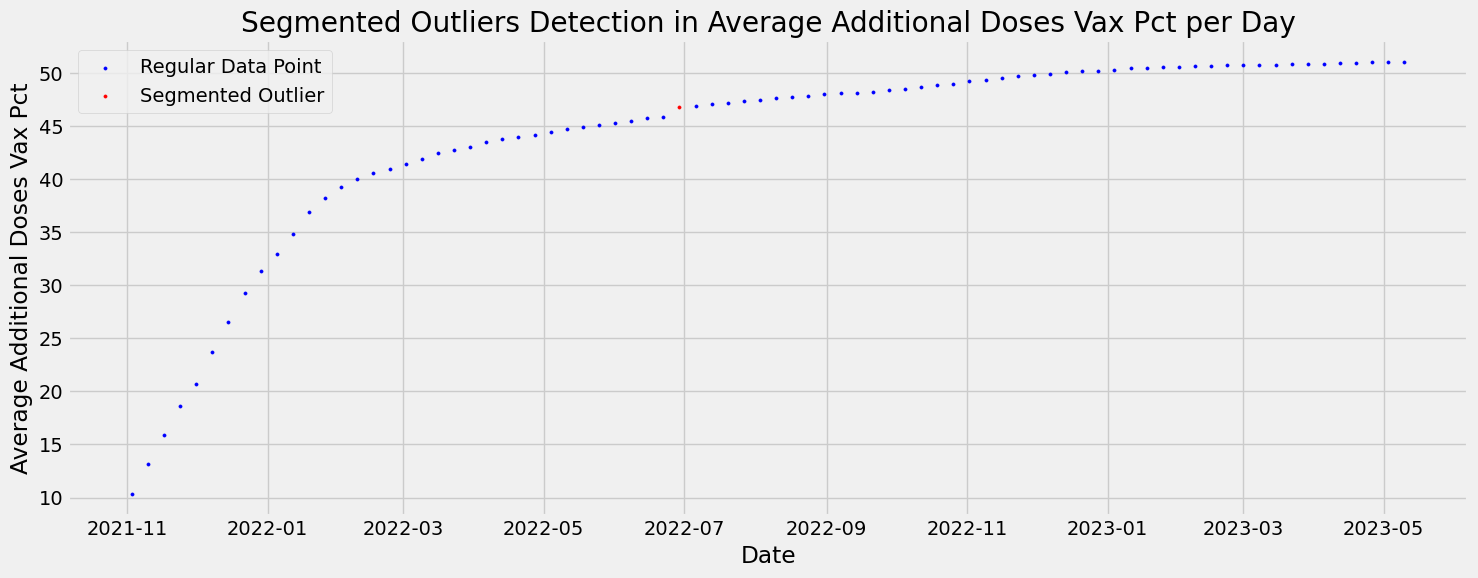

In [35]:
avg_vax_pct_per_day = df.groupby('Date')['Additional_Doses_Vax_Pct'].mean().reset_index()
# Convert 'Date' to datetime format
avg_vax_pct_per_day['Date'] = pd.to_datetime(avg_vax_pct_per_day['Date'])

# Create a month-year column for segmentation
avg_vax_pct_per_day['Month_Year'] = avg_vax_pct_per_day['Date'].dt.to_period('M')

# Group by Month_Year and calculate IQR for each month
iqr_values = avg_vax_pct_per_day.groupby('Month_Year')['Additional_Doses_Vax_Pct'].apply(lambda x: (x.quantile(0.25), x.quantile(0.75))).reset_index()
iqr_values.columns = ['Month_Year', 'IQR_Values']
iqr_values['Q1'] = iqr_values['IQR_Values'].apply(lambda x: x[0])
iqr_values['Q3'] = iqr_values['IQR_Values'].apply(lambda x: x[1])
iqr_values['Lower_Bound'] = iqr_values['Q1'] - 1.5 * (iqr_values['Q3'] - iqr_values['Q1'])
iqr_values['Upper_Bound'] = iqr_values['Q3'] + 1.5 * (iqr_values['Q3'] - iqr_values['Q1'])

# Merge the IQR values back to the main dataframe
avg_vax_pct_per_day = pd.merge(avg_vax_pct_per_day, iqr_values, on='Month_Year')

# Determine if a data point is an outlier for its respective month
avg_vax_pct_per_day['is_segmented_outlier'] = (avg_vax_pct_per_day['Additional_Doses_Vax_Pct'] < avg_vax_pct_per_day['Lower_Bound']) | (avg_vax_pct_per_day['Additional_Doses_Vax_Pct'] > avg_vax_pct_per_day['Upper_Bound'])
# Scatter plot to see segmented analysis outliers
plt.figure(figsize=(15, 6))

# Plot non-outliers in blue and outliers in red
plt.scatter(avg_vax_pct_per_day[avg_vax_pct_per_day['is_segmented_outlier'] == False]['Date'], 
            avg_vax_pct_per_day[avg_vax_pct_per_day['is_segmented_outlier'] == False]['Additional_Doses_Vax_Pct'], 
            color='blue', s=5, label='Regular Data Point')

plt.scatter(avg_vax_pct_per_day[avg_vax_pct_per_day['is_segmented_outlier'] == True]['Date'], 
            avg_vax_pct_per_day[avg_vax_pct_per_day['is_segmented_outlier'] == True]['Additional_Doses_Vax_Pct'], 
            color='red', s=5, label='Segmented Outlier')

plt.title('Segmented Outliers Detection in Average Additional Doses Vax Pct per Day')
plt.xlabel('Date')
plt.ylabel('Average Additional Doses Vax Pct')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### 5. Feature Engineering:

In our time-series analysis, we recognized the value of feature engineering to uncover potential predictors not explicitly present in the CDC’s API. Consequently, we integrated columns indicating the quarter, month, year, day of the week, day of the month, day of the year, and week of the year the observation was taken. Additionally, we established columns denoting the season of the observation (Winter, Spring, Fall, or Summer). We incorporated a Boolean column to indicate if the week of the observation encompassed a holiday, as per the `holidays` Python library, and another to denote if it contained a vaccine announcement by the CDC (Montel, 2017; Hahn, n.d.).

To explore time trends in prediction variables over time, we have had to group the data by date. This was necessary as otherwise the data contains multiple entries for each date for each state. To investigate lag we have plotted an ACF graph. The pattern the autocorrelation function (ACF) plot exhibited is commonly observed in time series data with a strong short-term memory or persistence. It implied that the most recent values have a more pronounced impact on the current value, and the impact of earlier values diminishes gradually. The decay in autocorrelation suggests a relatively fast decrease in correlation with increasing time lags. To further investigate the lag we have plotted the partial autocorrelation function (PACF) graph which showed the most significant lag at value of one week. Thus we have created a lag variable with shift of one week. Notably, autoregressive integrated moving average (ARIMA) models intrinsically factor in such dependencies.

In [36]:
# Quarter column
df['quarter'] = df['Date'].dt.quarter

# Day of year column
df['dayofyear'] = df['Date'].dt.dayofyear

# Day of month column
df['dayofmonth'] = df['Date'].dt.day

# Week of year column
df['weekofyear'] = df['Date'].dt.isocalendar().week.astype(np.int64)

# Defining function to identify season
def get_season(date):
    month = date.month
    day = date.day
    if month in [3, 4, 5]:
        season = 'spring'
    elif month in [6, 7, 8]:
        season = 'summer'
    elif month in [9, 10, 11]:
        season = 'fall'
    else:
        season = 'winter'
    

    if month == 3 and day < 20:
        season = 'winter'
    elif month == 6 and day < 21:
        season = 'spring'
    elif month == 9 and day < 22:
        season = 'summer'
    elif month == 12 and day < 21:
        season = 'fall'
    
    return season

# Applying function and creating season column
df['season'] = df['Date'].apply(get_season)

# Create a list of US holidays for the given year range in the dataframe
us_holidays = holidays.US(years=[df['Date'].dt.year.min(), df['Date'].dt.year.max()]).keys()

# Convert us_holidays to a pandas Series of datetime objects
us_holidays_series = pd.Series(pd.to_datetime(list(us_holidays)))

# Create Holiday column
df['holidays'] = df['Date'].isin(us_holidays_series) | (df['Date'] + pd.Timedelta(days=1)).isin(us_holidays_series)
df['holidays'] = df['holidays'].replace({True: 'Holiday', False: 'Normal day'})

# Determine which weeks have a holiday
holiday_weeks = us_holidays_series.dt.strftime('%U-%Y').unique()

# Assign a "holiday season" for every date that's within a week having a holiday
df['holiday_season'] = df['Date'].dt.strftime('%U-%Y').isin(holiday_weeks)

In [37]:
# Define a list of unique announcement dates
announcement_dates = [
    "04/28/2023", "04/27/2023", "04/18/2023", "03/14/2023", "03/10/2023",
    "12/16/2022", "12/08/2022", "10/21/2022", "10/12/2022", "09/13/2022",
    "08/31/2022", "08/26/2022", "08/19/2022", "07/13/2022", "07/08/2022",
    "06/30/2022", "06/17/2022", "05/17/2022", "05/05/2022", "04/29/2022",
    "04/15/2022", "04/01/2022", "03/29/2022", "03/21/2022", "03/11/2022",
    "02/11/2022", "02/01/2022", "01/31/2022", "01/11/2022", "01/07/2022",
    "01/03/2022", "12/17/2021", "12/14/2021", "12/09/2021", "11/30/2021",
    "11/19/2021", "10/29/2021", "10/26/2021", "10/22/2021", "10/20/2021",
    "10/14/2021", "10/01/2021", "09/24/2021", "09/22/2021", "09/20/2021",
    "09/17/2021", "09/10/2021", "09/02/2021", "09/01/2021", "08/24/2021",
    "08/23/2021", "08/18/2021", "08/13/2021", "08/12/2021", "08/06/2021",
    "08/03/2021", "07/30/2021", "07/16/2021", "07/13/2021", "07/08/2021",
    "07/06/2021", "07/02/2021", "06/29/2021", "06/25/2021", "06/15/2021",
    "06/11/2021", "06/10/2021", "05/25/2021", "05/19/2021", "05/11/2021",
    "05/10/2021", "04/27/2021", "04/23/2021", "04/21/2021", "04/16/2021",
    "04/13/2021", "04/12/2021", "04/01/2021", "03/26/2021", "03/24/2021",
    "03/17/2021", "03/05/2021", "03/02/2021", "02/27/2021", "02/26/2021",
    "02/25/2021", "02/23/2021", "02/22/2021", "02/12/2021", "02/05/2021",
    "02/04/2021", "01/29/2021", "01/14/2021", "01/04/2021", "12/28/2020",
    "12/22/2020", "12/21/2020", "12/18/2020", "12/17/2020", "12/14/2020", "12/12/2020"
]

# Convert to datetime and deduplicate
announcement_dates = list(set([pd.to_datetime(date) for date in announcement_dates]))

# Convert announcement dates to week-year format
announcement_weeks = [date.strftime('%U-%Y') for date in announcement_dates]

# Check if the date in the dataset is within the same week of any announcement dates
def in_announcement_week(date):
    return date.strftime('%U-%Y') in announcement_weeks

# Create the 'vax_announcement' column
df['vax_announcement'] = df['Date'].apply(in_announcement_week)

#### 6. Exploratory Data Analysis (EDA)
**Temporal Visualizations & Seasonal Decomposition**

We have used the seasonal and trend decomposition using Loess (STL) to investigate potential trends, seasons and residuals. Based on the STL plot, we have learned that `Additional Doses Vax Pct` has a very steep increase in the first four to five months after its initial release and then the rate has tapered and increased at a small and steady rate. This was expected as most people who wanted the booster, receved it when it first came out. The seasonal plot provides clear evidence for a seasonal pattern of around three months. This pattern is something we kept in mind and explored further in variable analysis. We will account for this pattern in a variety of ways moving forward with the project. For example one of the solutions we employ is to use an ARIMA model which can account for seasonal components. However, for other models we have creaed a categorical `Season` variable. Lastly, the residual pattern suggests that the STL may not have adequately captured some underlying patterns or structures in our time series data. 

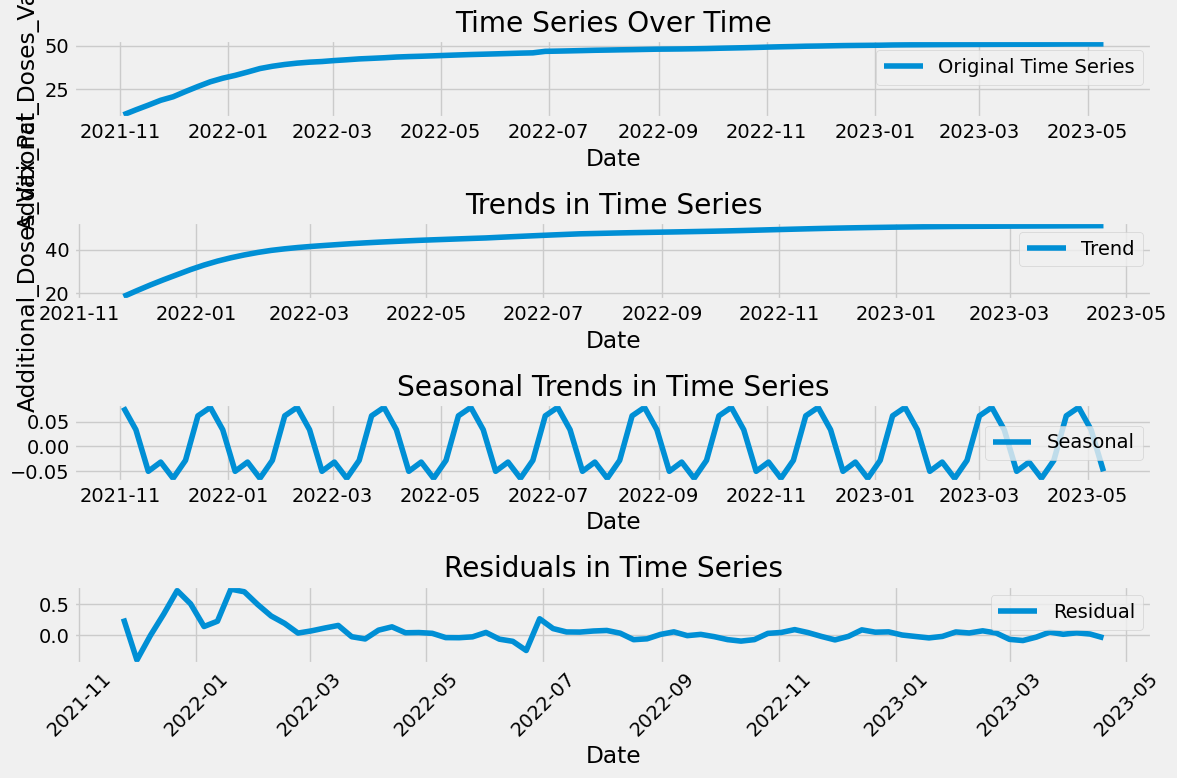

In [38]:
# STL decomposition to investigate trends, seasons and residual

# group data by date as there are multiple entires per each date
time_series_data = df.groupby('Date')[pred_var].mean().reset_index()
# set index to date
time_series_data = time_series_data.set_index('Date')

# Perform STL decomposition with a seasonality period of 7 because data are reported weekly
result = sm.tsa.seasonal_decompose(time_series_data[pred_var], model='stl', period=7)

# Access the decomposed components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the original time series, trend, seasonal, and residual components
plt.figure(figsize=(12, 8))

# Plot a subset of data 
plt.subplot(4, 1, 1)
plt.plot(time_series_data[pred_var], label='Original Time Series')
plt.legend()
plt.title('Time Series Over Time')
plt.xlabel('Date')
plt.ylabel(pred_var)


plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()
plt.title('Trends in Time Series')
plt.xlabel('Date')
plt.ylabel(pred_var)



plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()
plt.title('Seasonal Trends in Time Series')
plt.xlabel('Date')

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend()
plt.title('Residuals in Time Series')
plt.xlabel('Date')

# Customize x-axis labels to rotate by 45 degrees
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


**Correlation Analysis**

This ACF pattern is commonly observed in time series data with a strong short-term memory or persistence. It implies that the most recent values have a more pronounced impact on the current value, and the impact of earlier values diminishes gradually. The decay in autocorrelation suggests a relatively fast decrease in correlation with increasing time lags. Autoregressive models are ideal for dealing with this particular autocorrelation pattern. To investigate this further we have looked at the PACF graph and identified the biggest spike at value of one week. To prevent correlation issues in our model I will experiement with adding lag terms such as one week.

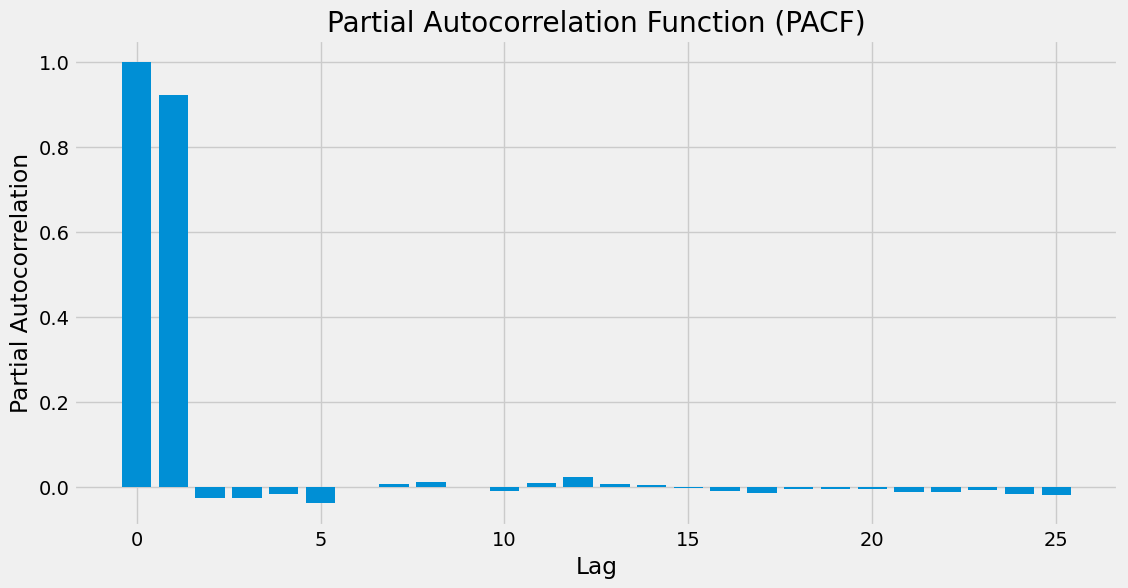

In [39]:
# PACF Plot

# Calculate the PACF
pacf = sm.tsa.pacf(time_series_data, nlags=25)

# Create the PACF plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(pacf)), pacf)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True)
plt.show()

Below, I add the one week lag as indicated to do so by the PACF graph. This is the final preprocessing step I took, and I exported the preprocessed dataframe for ease of use across all of my models. Therefore, the dataframe I will use and reference in the model development section and beyond will be `'df_post_eda.csv'`. 

In [40]:
# Adding one week lag
df['Additional_Doses_Vax_Pct_1_w_lag'] = df['Additional_Doses_Vax_Pct'].shift(1)

#### Univariate Analysis
**Distribution of Response Variable**

Here, we can see that the response variable is skewed to the leftand that the most significant concentration of data lies between the 30% to 50% vaccination rate, suggesting that for many samples, the percentage of additional doses administered falls within this range. It's worth noting the scarcity of data points both below 10% and above 60%. This indicates that very low and very high vaccination rates are less common among the samples we have.

<Axes: xlabel='Additional_Doses_Vax_Pct', ylabel='Count'>

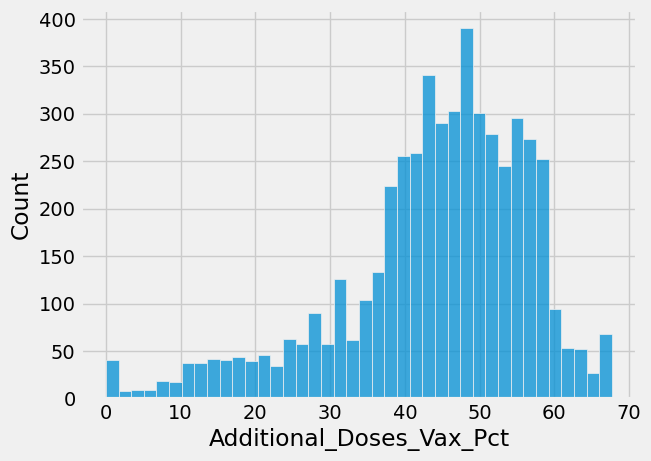

In [41]:
# Distribution of response variable
sns.histplot(df[pred_var], kde=False )

**Distribution of features after data cleaning and imputation**

We can see that many of the features are relatively normally distributted with some having an extreme skew. As we develop the models, we may apply log transformations to those with extreme skews if we feel it is necessary.

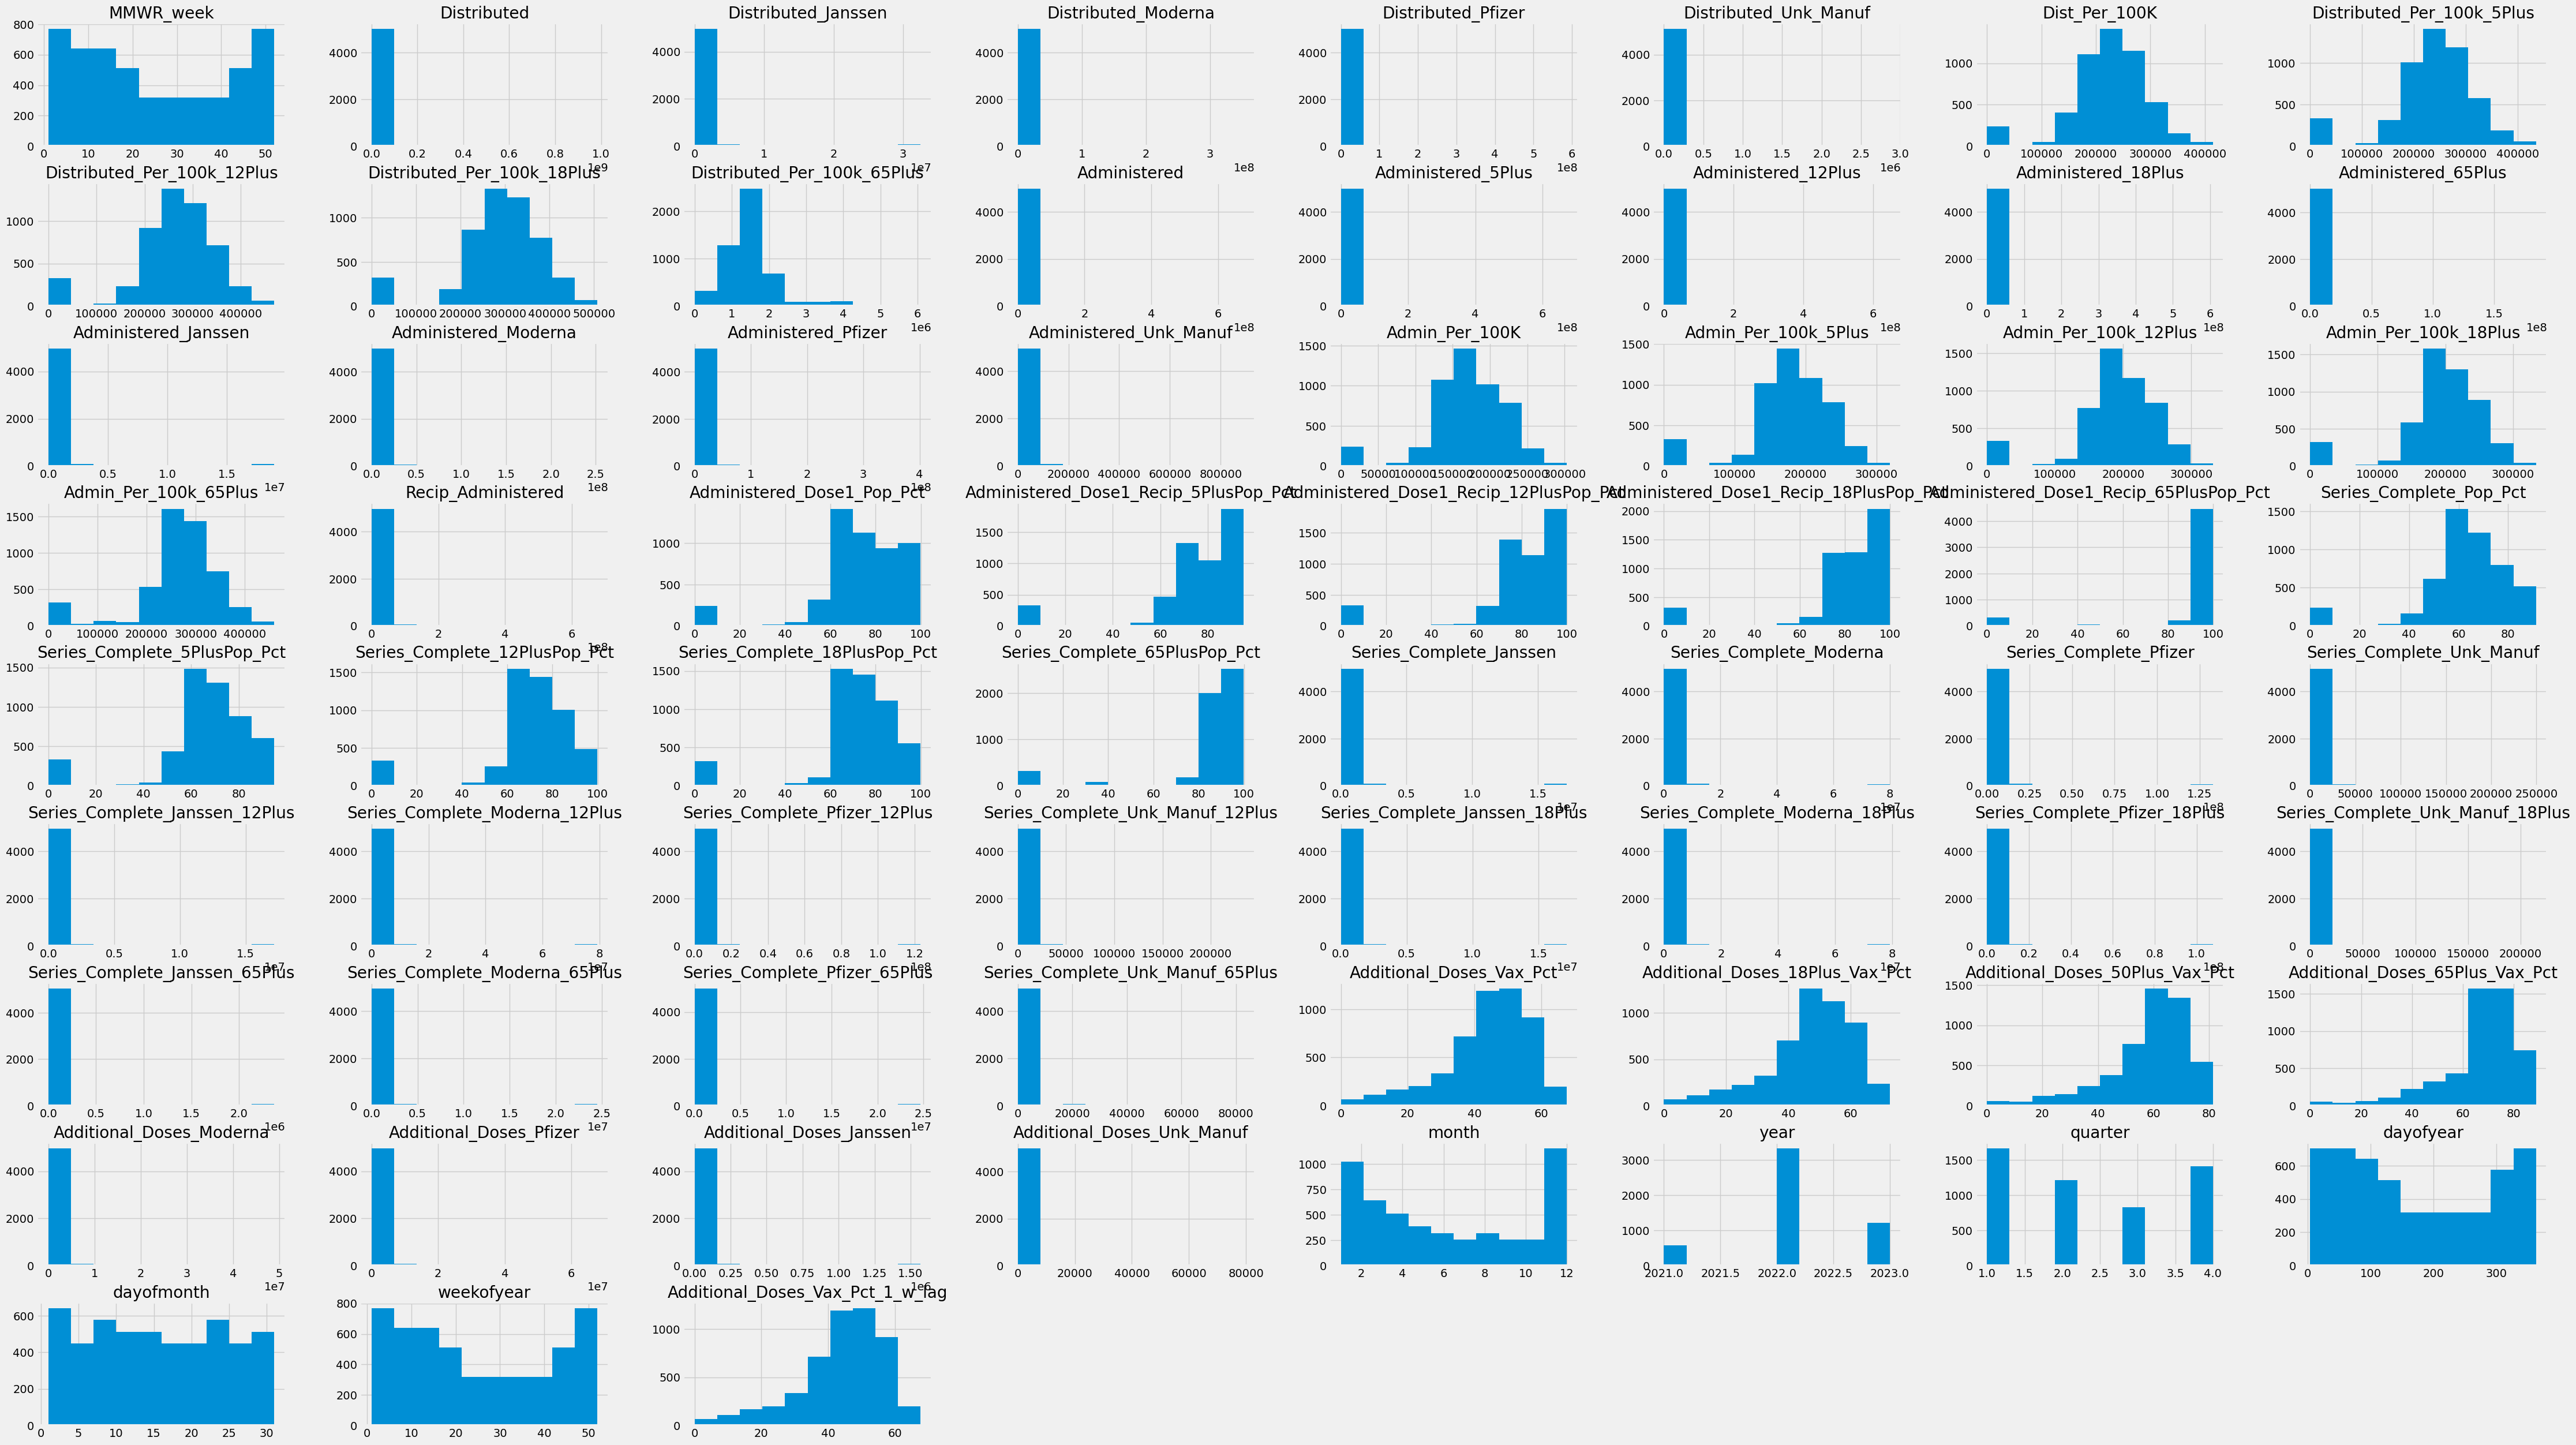

In [42]:
# Distribution of features after data cleaning and imputation

# find continous/ numerical variables
continuous_vars = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# plot df
%matplotlib inline
df.hist (column= continuous_vars,figsize= (50,30))
#hides array names that are otherwise printed
_ = plt.plot()

**Distribution of feature-engineered `season`**

We can see that there are more observations from the winter. This may have been because of where we start and end out data as a result of vaccine guidelines for 5-11 year olds.

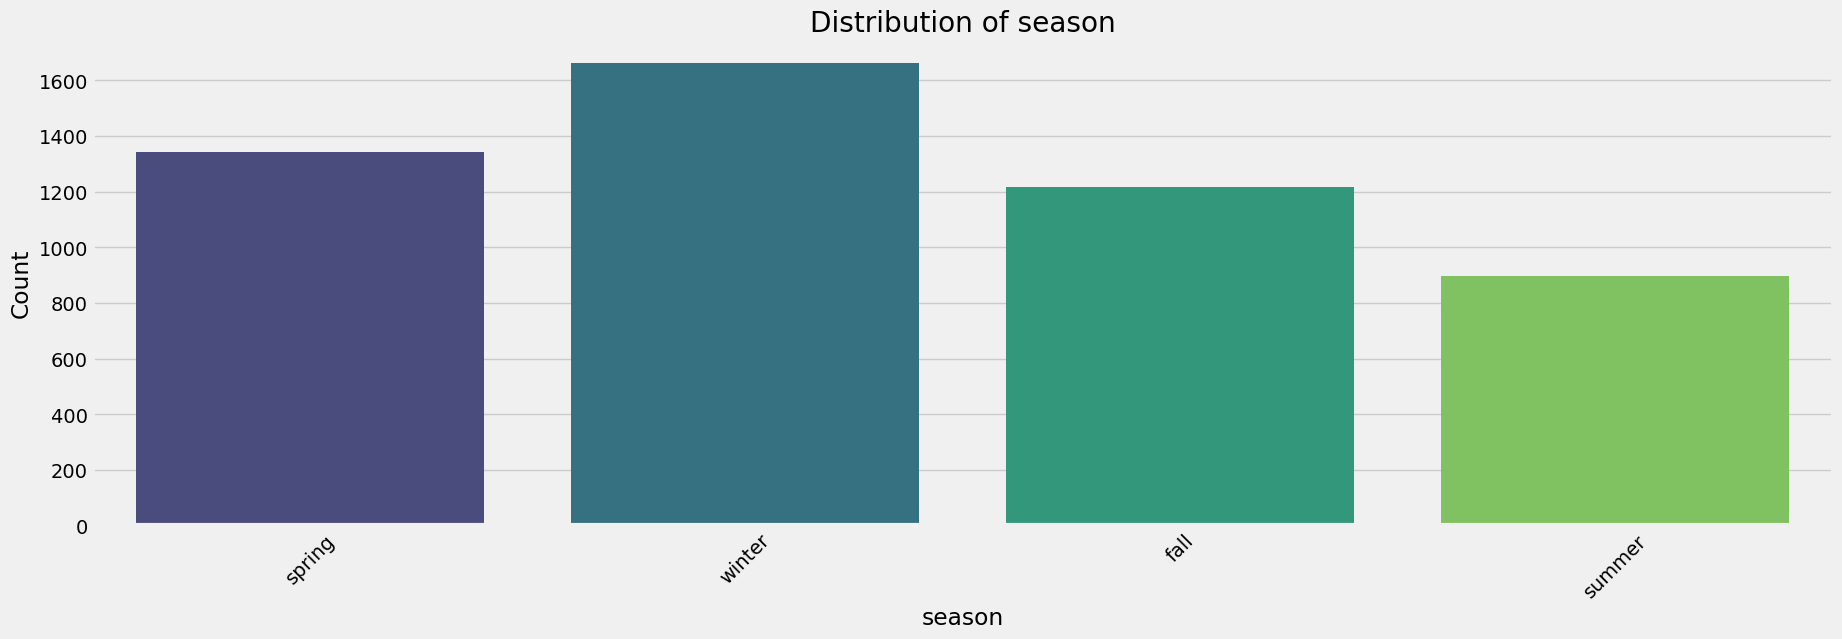

In [43]:
# Distribution of season 
categorical_variable = 'season'

# Create a countplot
plt.figure(figsize=(20, 6))  
sns.countplot(data=df, x=categorical_variable, palette='viridis')  
plt.title(f'Distribution of {categorical_variable}')
plt.xlabel(categorical_variable)
plt.ylabel('Count')

# Rotate x-axis labels for better readability 
plt.xticks(rotation=45)

# Show the plot
plt.show()

**Distribution of feature-engineered `holiday_season`**

We can observe that relatively few vaccination rates were reported in weeks when there was a US holiday. 

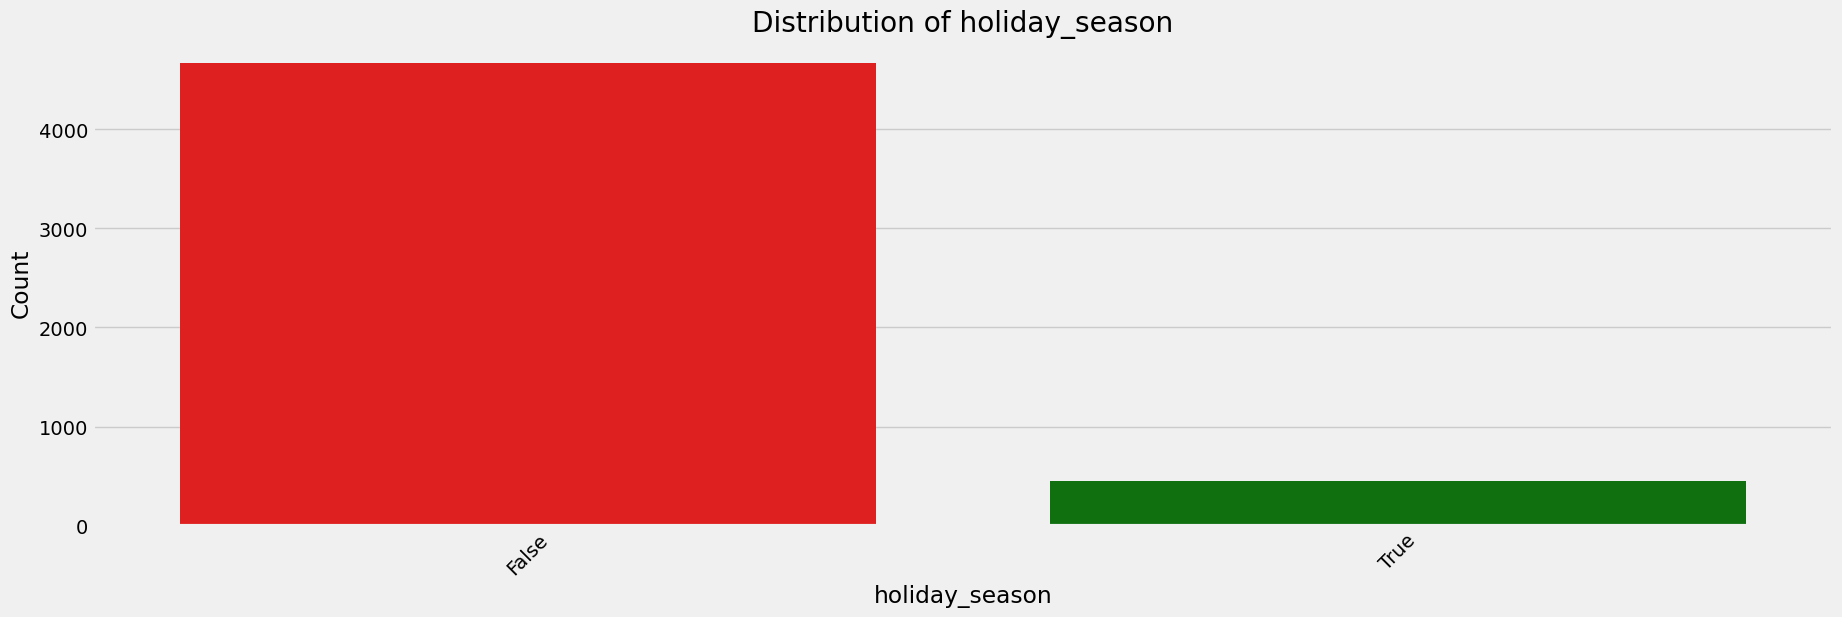

In [44]:
# Custom Boolean color palette
boolean_palette = {True: 'green', False: 'red'}

# Distribution of holidays
categorical_variable = 'holiday_season'

# Create a countplot
plt.figure(figsize=(20, 6))  
sns.countplot(data=df, x=categorical_variable, palette=boolean_palette) 
plt.title(f'Distribution of {categorical_variable}')
plt.xlabel(categorical_variable)
plt.ylabel('Count')

# Rotate x-axis labels for better readability 
plt.xticks(rotation=45)

# Show the plot
plt.show()

**Distribution of feature-engineered `vax_announcement`**

There are a pretty significant proportiion of vaccine rate observations on a week where there was a CDC vaccine announcement. This could be because there were a lot of announcements reported, though.

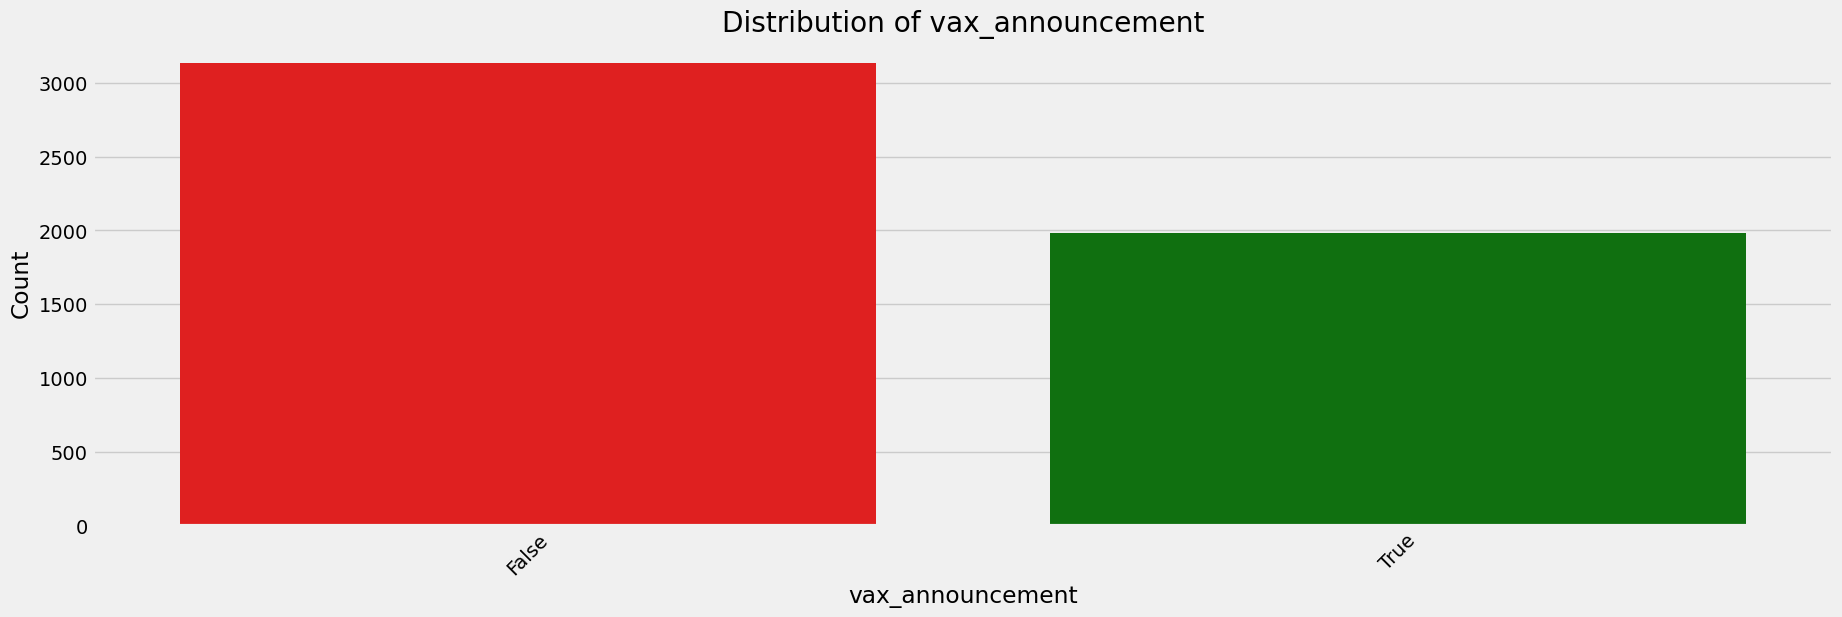

In [45]:
# Distribution of doses near vaccine announcements
categorical_variable = 'vax_announcement'

# Create a countplot
plt.figure(figsize=(20, 6))  # Set the figure size
sns.countplot(data=df, x=categorical_variable, palette=boolean_palette)  
plt.title(f'Distribution of {categorical_variable}')
plt.xlabel(categorical_variable)
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

**Distribution of `Location`**
The observations across locations are almost completely even with around 15 less reports from Palau and around 60 less reports from the location code RP (we were unable to find this location's corresponding state/territory name).

#### Bivariate Analysis
To further investigate the seasonal trends found in the STL plots we have plotted box plots of `Month` and `Season` against our prediction variable. Based on these plots we can see that the median across all categories is pretty similar. However, both November and Fall have a significanly larger IQR. This is potentially related to the fact that our data subset starts in Novemember (Fall), meaning that it had a lot of low % values in 2021 when the COVID booster first came out.

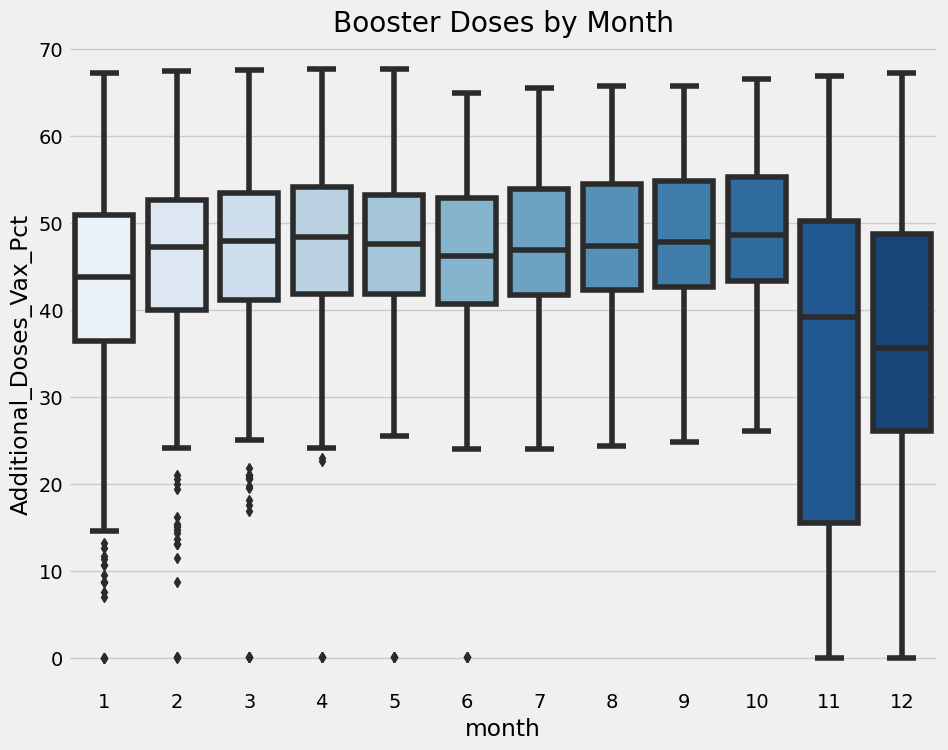

In [46]:
# visualize the monthly pred_var
features_target = df[['day_of_week', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear','season', 'holidays', 'holiday_season', 'vax_announcement','Additional_Doses_Vax_Pct_1_w_lag', pred_var,'Date']]
features_target = features_target.set_index('Date')
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=features_target, x='month', y=pred_var, palette='Blues')
ax.set_title('Booster Doses by Month')
plt.show()

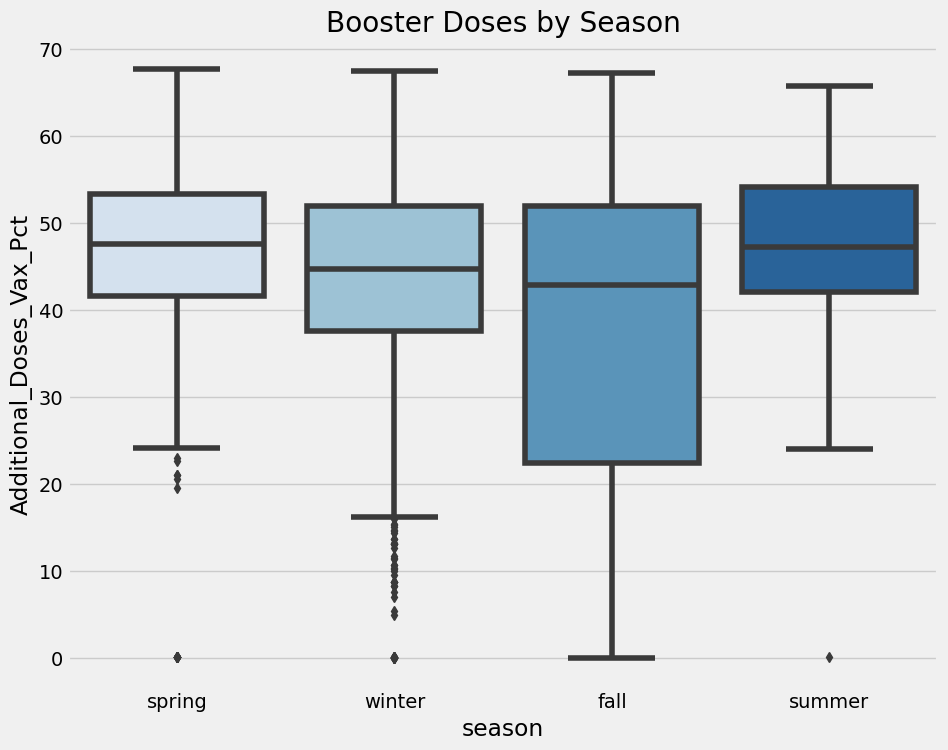

In [47]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=features_target, x='season', y=pred_var, palette='Blues')
ax.set_title('Booster Doses by Season')
plt.show()

#### Multivariate Analysis
Based on multivariate heatmaps there are few variables that have relatively high correlation with our prediction variable. These features may have contributed to some of the overfitting issues I had with model development.

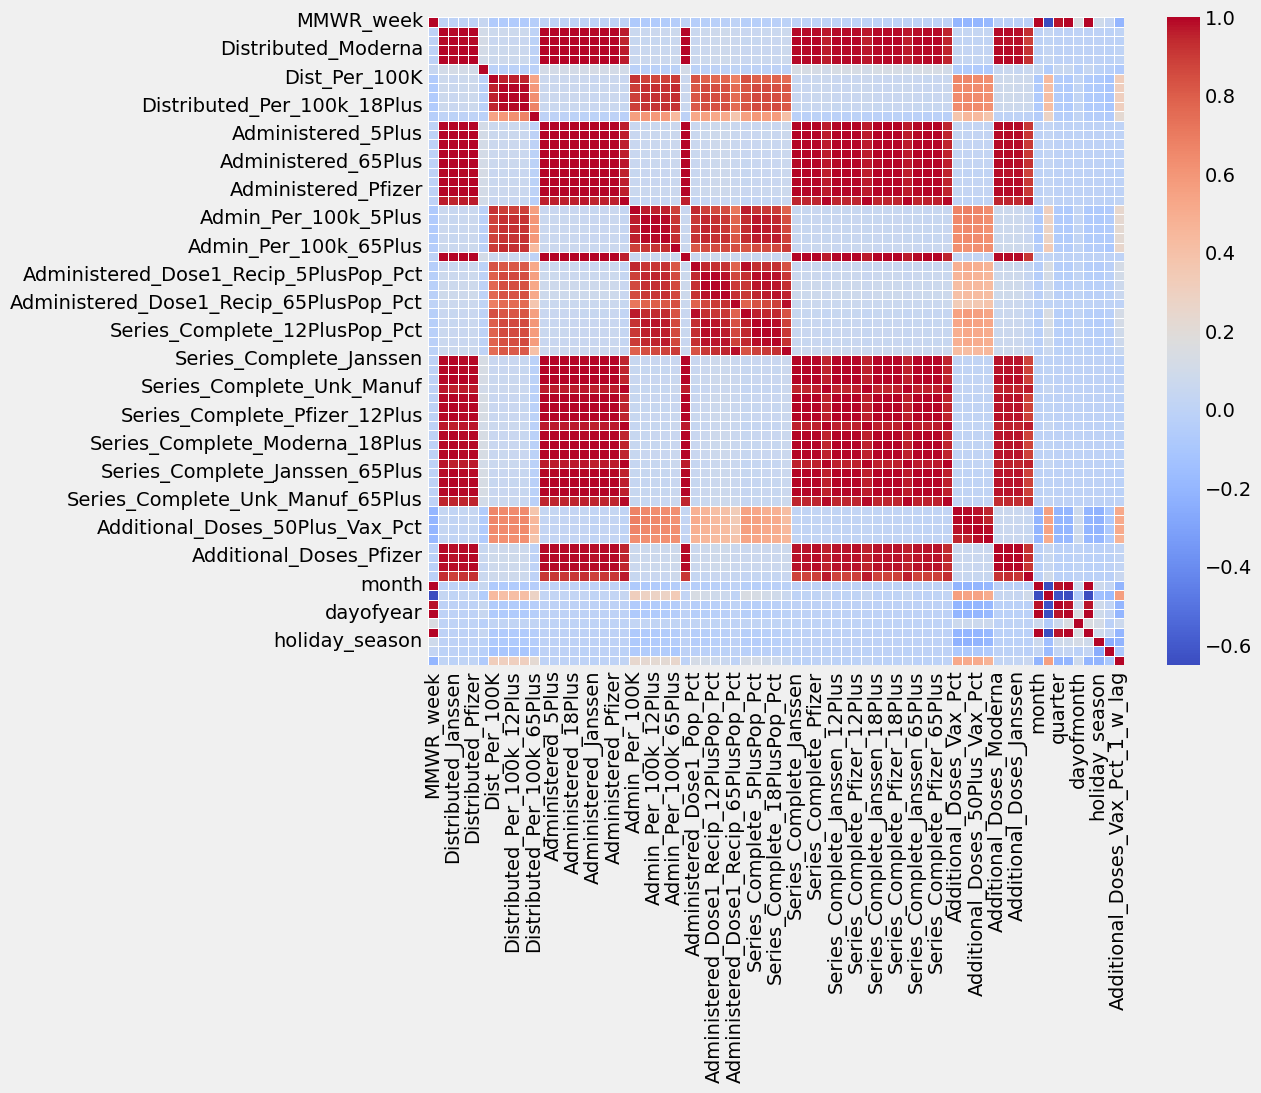

In [48]:
# Heat map to show correlation between variables

plt.figure(figsize=(10, 8))  
sns.heatmap(df.corr(), cmap='coolwarm', linewidths=0.5)

plt.show()

<Axes: >

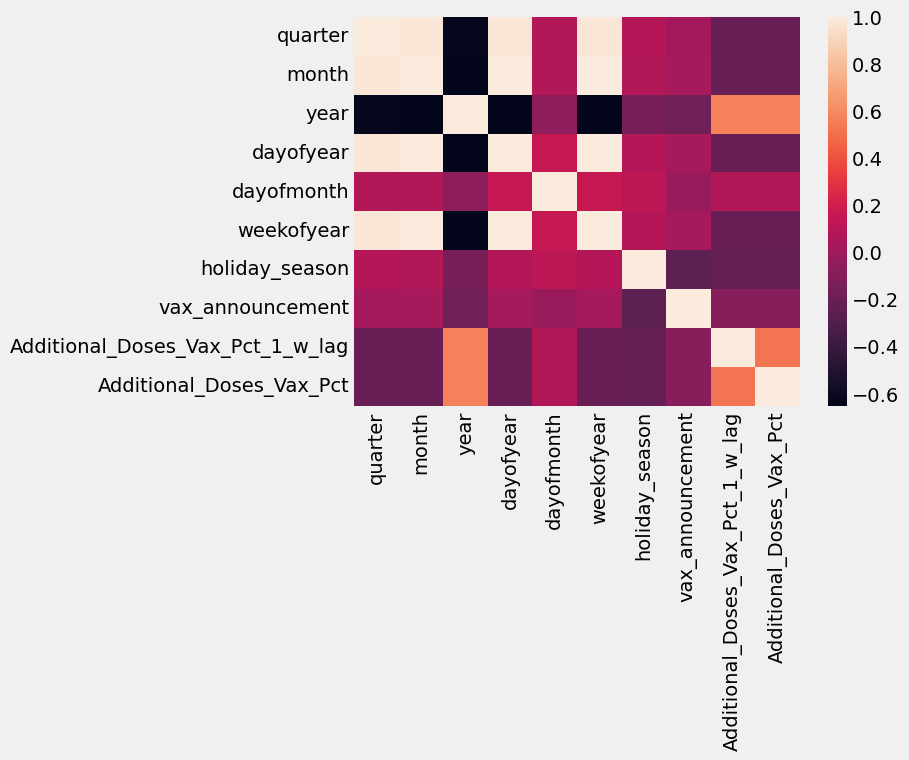

In [49]:
# Engineered feature correlations

correlation = features_target.corr( method='pearson' )
sns.heatmap( correlation )

## III. Methodology
### A. `ARIMA` Model
#### 1. Data Preparation:

Fof the Autoregressive [INSERT] (ARIMA) model, I imported solely the `Date` and response variable columns as the model inherently does not take any other features [ADD]. I then grouped `Date` by location as ARIMA models must have one unique observation per date.

In [38]:
# Import data with specific columns
df_ar = pd.read_csv('df_post_eda.csv', usecols=['Date', pred_var])

# Convert 'Date' to datetime
df_ar['Date'] = pd.to_datetime(df_ar['Date'])

# Group by 'Date' to ensure there is one unique value per date
df_ar = df_ar.groupby('Date').mean()

# Sorting the DataFrame by the index just to make sure it's in chronological order
df_ar.sort_index(inplace=True)

# Now 'Date' is the index and I have the average of 'Additional_Doses_Vax_Pct' per date

In [ ]:
# Calculate the index for the 70-30 split
split_index = int(len(df) * 0.7)

# Split into train and test
train = df.iloc[:split_index][pred_var]
test = df.iloc[split_index:][pred_var]

# Check the size of each dataset
print(f"Training set size: {len(train_df)}, Test set size: {len(test_df)}")

To confirm stationarity, I performed the Augmented Dickey-Fuller test to verify that the $p-value < 0.05$. I also created an autocorrelation plot to show that after around 11 lags, the autocorrelation remained between 0.25 and -0.25. With stationarity being confirmed, I felt confident proceeding with model development.

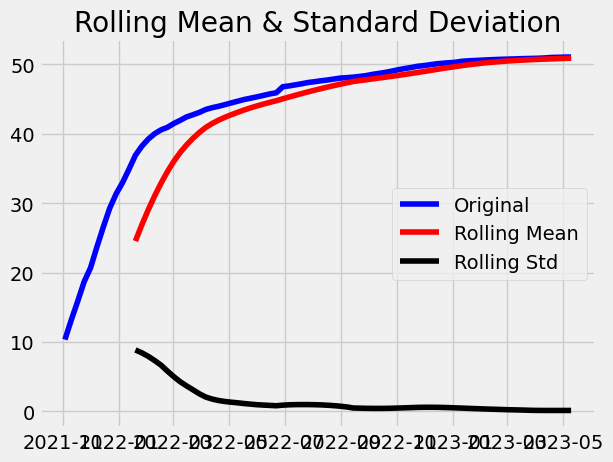

Results of Dickey-Fuller Test:
Test Statistic                 -4.009253
p-value                         0.001363
#Lags Used                      2.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

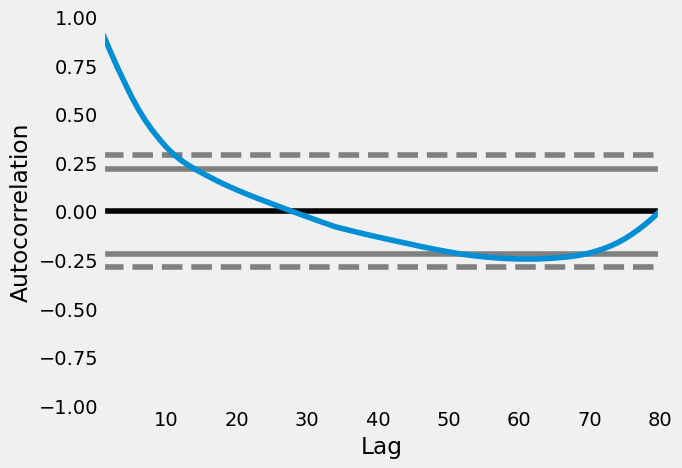

In [40]:
# Perform Augmented Dickey-Fuller test:
def test_stationarity(timeseries):

    # Determing rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Augmented Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    adf_test = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in adf_test[4].items():
        adf_output['Critical Value (%s)' % key] = value
    print(adf_output)

# Testing
test_stationarity(df_ar[pred_var])

#Autocorrelation plot
autocorrelation_plot(df[pred_var])

Some of ARIMA's key parameters are the `p`, `d` `q`, `P`, `D`, `Q`, and `seasonality`. Their descriptions are as follows:

`p`: 

`d`: 

`q`: 

`P`: 

`D`: 

`Q`: 

`seasonality`:

#### 2. Model Building

In [ ]:
# Initialize the ARIMA model
model = ARIMA(train, order=(2, 0, 1))

# Fit the ARIMA model
fitted_model = model.fit()

# Print out the summary of the fit model
print(fitted_model.summary())

### B. `Auto_ARIMA` Model
#### 1. Data Preparation:

### C. `Prophet` (Univariate) Model
#### 1. Data Preparation:

### D. `Prophet` (Multivariate) Model
#### 1. Data Preparation:

### E. `XGBoost` Model
#### 1. Data Preparation:

It is important to initially mention that I decided to develop an `XGBoost` model for four different versions of my data.

1. **Ungrouped, unscaled data**: Essentially, the dataframe created after the initial preprocessing.
2. **Grouped, unscaled data**: All observations on a specific day are averaged so that `Date` is a unique identifier, and the features remain the same magnitude as they were observed.
3. **Grouped, scaled data**: All observations on a specific day are averaged so that `Date` is a unique identifier, and the features are scaled to be between zero and one.
4. **Ungrouped, scaled data**: There are multiple observations per `Date`, and the features are scaled to be between zero and one.

For all of the versions, however, there are a few common preprocessing steps I took. I began by sorting my data by `Date` and `Location` to ensure consistency before splitting into train and test sets. I tried creating models with a few different versions of engineered features, and I will include each iteration of my feature engineering and model output process in the appendix; however, for the sake of brevity and clarity, I will include the feature engineering setup I used for my final model I tuned for each data version outlined above. First, I added rolling mean and standard deviation columns to adjust for seasonality and reduce noise (Dancho, 2017). I settled on `window = 12` which represents the three-month seasonality pattern I had previously identified. Furthermore, I converted the `Date` column to a datetime datatype and added additional lag columns for three and nine month lags to account for the three-month pattern. I chose not to impute the missing values of the lag columns as one does not need to for `XGBoost` I also one-hot-encoded my data to account for the few categorical variables in my dataframe to ensure compatibility with `XGBoost`. Here is how I did that process for Version 1 of my data.

In [2]:
# Import data
df = pd.read_csv('df_post_eda.csv')

# Predictive variable
pred_var = 'Additional_Doses_Vax_Pct' 

# Converting Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sorting data by Date and Location
df_v1 = df.sort_values(by=['Date', 'Location'])

# Additional time-series features to account for 3-month pattern
# 3 month lag
df_v1['Additional_Doses_Vax_Pct_3_m_lag'] = df_v1['Additional_Doses_Vax_Pct'].shift(12)

# 9 month lag
df_v1['Additional_Doses_Vax_Pct_9_m_lag'] = df_v1['Additional_Doses_Vax_Pct'].shift(36)

# Rolling statistics
df_v1['rolling_mean'] = df_v1[pred_var].shift().rolling(window=12).mean()
df_v1['rolling_std'] = df_v1[pred_var].shift().rolling(window=12).std()

# One-hot encoding of the entire dataframe
df_encoded_v1 = pd.get_dummies(df_v1)

**Version 1**

For the train-test split for Version 1 of my data, I first created a list (`splits_by_date`) where each element is a DataFrame containing all records from `df_encoded` corresponding to a unique date. This is done by iterating over each unique date in the `Date` column. I then initialized a `TimeSeriesSplit` object from `Scikit-learn`. TimeSeriesSplit is a cross-validator for time series data, providing train/test indices to split time series data samples. I set it to have 5 splits, with a test size of 12, and a gap of 12. The `test_size` indicates the number of observations to include in each test set, and gap specifies a gap period between the train and test sets to avoid leakage. I finally created the actual train and test splits by running a loop that iterated over the pairs of train and test indices generated by `tscv.split(splits_by_date)`. For each pair of indices, it concatenates the data frames from `splits_by_date` corresponding to those indices to create the training and testing sets. This way, I ended up with multiple sets of train and test data, respecting the temporal order of the data. Finally, I dropped the `Date` column after using it to create the splits as `XGBoost` only can handle numerical data and the `Date` attribute is represented in several of the engineered features I created previously. The best model that I created for Version 1 of my data performed quite poorly, so I just used all of the features in my dataframe and did not proceed with feature selection for this data version.

In [3]:
# Split the dataset based on unique dates
splits_by_date_v1 = [df_encoded_v1[df_encoded_v1['Date'] == date] for date in df_encoded_v1['Date'].unique()]

# TimeSeriesSplit
# I made the test_size = 12 because I think three months' worth of data is sufficient

tscv = TimeSeriesSplit(n_splits=3, test_size = 12, gap = 12)

# Loop to create train and test splits
for train_index, test_index in tscv.split(splits_by_date_v1):
    train_v1 = pd.concat([splits_by_date_v1[i] for i in train_index])
    test_v1 = pd.concat([splits_by_date_v1[i] for i in test_index])

# Set up XGBoost data structures
X_train_v1, y_train_v1 = train_v1.drop([pred_var, 'Date'], axis=1), train_v1[pred_var]
X_test_v1, y_test_v1 = test_v1.drop([pred_var, 'Date'], axis=1), test_v1[pred_var]

**Version 2**

For Version 2, I followed the same specifications as Version 1; however, I dropped the `Location` column as I am averaging the observations for each `Date` across all locations. I still did not perform feature selection because the model using these data performed similarly as poorly as Version 1's did. Also, I am including a line to perform that grouping and performed the feature engineering after grouping. 

In [4]:
# Dropping Location column because we are grouping by Location
df_v2 = df.drop('Location', axis = 1)

# Group by 'Date' to ensure there is one unique value per date
df_v2 = df_v2.groupby('Date').mean(numeric_only=True).reset_index()

# Additional time-series columns to account for 3-month pattern
# 3 month lag
df_v2['Additional_Doses_Vax_Pct_3_m_lag'] = df_v2['Additional_Doses_Vax_Pct'].shift(12)

# 9 month lag
df_v2['Additional_Doses_Vax_Pct_9_m_lag'] = df_v2['Additional_Doses_Vax_Pct'].shift(36)

# Rolling statistics
df_v2['rolling_mean'] = df_v2[pred_var].shift().rolling(window=12).mean()
df_v2['rolling_std'] = df_v2[pred_var].shift().rolling(window=12).std()

# One-hot encoding of the entire dataframe
df_v2_encoded = pd.get_dummies(df_v2)

# Split the dataset based on unique dates
splits_by_date_v2 = [df_v2_encoded[df_v2_encoded['Date'] == date] for date in df_v2_encoded['Date'].unique()]

# Train test split
for train_index, test_index in tscv.split(splits_by_date_v2):
    train_v2 = pd.concat([splits_by_date_v2[i] for i in train_index])
    test_v2 = pd.concat([splits_by_date_v2[i] for i in test_index])

# Set up XGBoost data structures and dropping Date column because it cannot be used directly
X_train_v2, y_train_v2 = train_v2.drop([pred_var, 'Date'], axis=1), train_v2[pred_var]
X_test_v2, y_test_v2 = test_v2.drop([pred_var, 'Date'], axis=1), test_v2[pred_var]

**Version 3** 

Version 3 follows the same process as Version 2 with some modifications for scaling. Here, I employed the `MinMaxScaler()` function to scale the features from 0 to 1. To do this, I had to drop the `Date` column from the dataframe as it cannot be scaled; however, I added it back to the dataframe after scaling for use in the train-test split. I included feature engineering after grouping and scaling the data. I did not have time to do feature selection here and chose only to do it on Version 4 as it was the version whose model achieved the best results for `XGBoost`.

In [5]:
# Dropping Location column because we are grouping by Location
df_v3 = df.drop('Location', axis = 1)

# Group by 'Date' to ensure there is one unique value per date
df_v3 = df_v3.groupby('Date').mean(numeric_only=True).reset_index()

# Create a new DataFrame from the aggregated data
data = pd.DataFrame(df_v3)

# Separate the 'Date' column for scaling
date_column = data['Date']
data_without_date = data.drop('Date', axis=1)

# Initialize the MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

# Apply the scaler to the data without the 'Date' column
scaled_data = min_max_scaler.fit_transform(data_without_date)

# Create a new DataFrame with the scaled data
df_v3 = pd.DataFrame(scaled_data, columns=data_without_date.columns, index=data_without_date.index)

# Add the 'Date' column back to the scaled DataFrame (for train test split)
df_v3['Date'] = date_column

# Additional time-series columns to account for 3-month pattern
# 3 month lag
df_v3['Additional_Doses_Vax_Pct_3_m_lag'] = df_v3['Additional_Doses_Vax_Pct'].shift(12)

# 9 month lag
df_v3['Additional_Doses_Vax_Pct_9_m_lag'] = df_v3['Additional_Doses_Vax_Pct'].shift(36)

# Rolling statistics
df_v3['rolling_mean'] = df_v3[pred_var].shift().rolling(window=12).mean()
df_v3['rolling_std'] = df_v3[pred_var].shift().rolling(window=12).std()

# One-hot encoding of the entire dataframe
df_encoded_v3 = pd.get_dummies(df_v3)

# Split the dataset based on unique dates
splits_by_date_v3 = [df_encoded_v3[df_encoded_v3['Date'] == date] for date in df_encoded_v3['Date'].unique()]

# Train test split
for train_index, test_index in tscv.split(splits_by_date_v3):
    train_v3 = pd.concat([splits_by_date_v3[i] for i in train_index])
    test_v3 = pd.concat([splits_by_date_v3[i] for i in test_index])

# Set up XGBoost data structures and dropping Date column because it cannot be used directly
X_train_v3, y_train_v3 = train_v3.drop([pred_var, 'Date'], axis=1), train_v3[pred_var]
X_test_v3, y_test_v3 = test_v3.drop([pred_var, 'Date'], axis=1), test_v3[pred_var]

**Version 4**

Version 4's data preparation consists of a combination of 1's and 3's in that I scale the data but do not group it. I performed feature selection after tuning my base model which I will explain more in the tuning section. I again had to drop the `Date` column and reappend after one hot encoding and scaling the data.

In [6]:
# Save the 'Date' column and drop it from the DataFrame
date_column = df['Date']
df.drop('Date', axis=1, inplace=True)

# Apply one-hot encoding to the DataFrame
df_encoded_v4 = pd.get_dummies(df)

# Apply the scaler to the encoded data
df_v4 = pd.DataFrame(min_max_scaler.fit_transform(df_encoded_v4), columns=df_encoded_v4.columns)

# Re-attach the 'Date' column
df_v4['Date'] = date_column

# Reorder the columns to place 'Date' at the start
df_v4 = df_v4[['Date'] + [col for col in df_v4.columns if col != 'Date']]

# Additional time-series columns to account for 3-month pattern
# 3 month lag
df_v4['Additional_Doses_Vax_Pct_3_m_lag'] = df_v4['Additional_Doses_Vax_Pct'].shift(12)

# 9 month lag
df_v4['Additional_Doses_Vax_Pct_9_m_lag'] = df_v4['Additional_Doses_Vax_Pct'].shift(36)

# 1 week lag (because ACF plot said to)
df_v4['Additional_Doses_Vax_Pct_1_w_lag'] = df_v4['Additional_Doses_Vax_Pct'].shift(1)

# Rolling statistics
df_v4['rolling_mean'] = df_v4[pred_var].shift().rolling(window=12).mean()
df_v4['rolling_std'] = df_v4[pred_var].shift().rolling(window=12).std()

# Split the dataset based on unique dates
splits_by_date_v4 = [df_v4[df_v4['Date'] == date] for date in df_v4['Date'].unique()]

# Train test split
for train_index, test_index in tscv.split(splits_by_date_v4):
    train_v4 = pd.concat([splits_by_date_v4[i] for i in train_index])
    test_v4 = pd.concat([splits_by_date_v4[i] for i in test_index])
    
# Set up XGBoost data structures and dropping 'Date' because XGBoost cannot handle it
X_train_v4, y_train_v4 = train_v4.drop([pred_var, 'Date'], axis=1), train_v4[pred_var]
X_test_v4, y_test_v4 = test_v4.drop([pred_var, 'Date'], axis=1), test_v4[pred_var]

#### 2. Model Building:

XGBoost, which stands for eXtreme Gradient Boosting, works by iteratively combining a sequence of simple decision trees, each correcting the errors of its predecessors, to form a powerful ensemble model that delivers highly accurate predictions. In the context of predicting vaccine rates, `XGBoost` stands out for its ability to handle complex, varied datasets with high efficiency and accuracy. It is robust to different data types and missing values and it has powerful boosting capabilities. However, successful application requires thoughtful preprocessing, feature engineering, and hyperparameter optimization to tailor the model to the specific nuances of vaccine data. Furthermore, `XGBoost` models do not have an inherent understanding of temporal structures of time series data (Brownlee, 2021; Jain, 2023).

`XGBoost` has a variety of parameters to tune. I will briefly go over some of the key ones I decided to tune and focus on. 

`subsample` controls the proportion of data used to create each tree.

`reg_alpha` represents the L1 regularization term on weights (Lasso Regression) used to prevent overfitting by penalizing the absolute size of the weights; a larger value specifies stronger regularization, and it can drive some weights to zero. 

`reg_lambda` represents the L2 regularization term on weights (Ridge Regression) used to prevent overfitting by penalizing large weights; a larger value specifies stronger regularization. 

`n_estimators` is the number of gradient boosted trees to be used in the model with a higher number giving potentially more predictive power but also slower run times and overfitting.

`min_child_weight` specifies the minimum sum of instance weight needed in a leaf to control overfitting. High values help the model avoid learning highly specific relations for a selected tree sample.

`max_depth` denotes the maximum tree depth with a deeper tree corresponding with more complex, potentially overfit, relationships by allowing for more splits.

`learning_rate` scales each tree's contribution. Higher values can cause models to be bad at generalizing whereas smaller values can make models robust but time consuming to train.

`gamma` controls the minimum loss reduction required to make a further separation on a leaf node with a higher value corresponding with fewer splits.

`colsample_bytree` represents the proportion of features to be randomly sampled to create each tree. Randomness helps with model robustness and prevents overfitting (xgboost developers, 2022).

As for the training process for `XGBoost`, I followed the same process for each version; however, I will show how I trained the model for Version 4 below and the training process for the other versions will be in the appendix.

In the Data Preparation section, I showed how I split my data into train and test sets and then into `X_train`, `y_train`, `X_test`, and `y_test` so that the `XGBoost` model can train on known data and then validate the model's predictive accuracy on unseen data to ensure its generalizabilty and effectiveness.

To train a base `XGBoost` model, I initiated with the parameters `learning_rate = 0.01`, `n_estimators = 1000`, and set `early_stopping_rounds = 10`. I chose a lower learning rate of 0.01, aiming for gradual weight updates to reduce overfitting risks and enhance robustness. I also selected a high number of estimators at 1000 trees to enable the model to capture complex patterns in the time-series dataset. Lastly, I implemented early stopping to halt training after 10 consecutive rounds without improvement in model performance, thereby preventing overfitting and conserving computational resources.

In [ ]:
# Initialize the XGBRegressor with specific parameters
reg_base_v4 = XGBRegressor(n_estimators=1000, learning_rate=0.01, early_stopping_rounds=10)

# Fit the model to the training data
reg_base_v4.fit(X_train_v4, y_train_v4, eval_set=[(X_train_v4, y_train_v4), (X_test_v4, y_test_v4)], verbose = False)

I then plotted the results of my model and the train and test root mean squared errors (RMSEs) to evaluate the performance of my model and indicate whether I should continue training it.

In [ ]:
# Forecasting and Evaluation
train_pred_base_v4 = reg_base_v4.predict(X_train_v4)
test_pred_base_v4 = reg_base_v4.predict(X_test_v4)

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

# Train plot
ax[0].plot(train_v4.index, y_train_v4, label='Actual')
ax[0].plot(train_v4.index, train_pred_base_v4, label='Predicted')
ax[0].set_title('Train Data')
ax[0].legend()

# Test plot
ax[1].plot(test_v4.index, y_test_v4, label='Actual')
ax[1].plot(test_v4.index, test_pred_base_v4, label='Predicted')
ax[1].set_title('Test Data')
ax[1].legend()

# Show the plots
plt.show()

# Print RMSE values
train_rmse_base_v4 = np.sqrt(mean_squared_error(y_train_v4, train_pred_base_v4))
test_rmse_base_v4 = np.sqrt(mean_squared_error(y_test_v4, test_pred_base_v4))
print(f"Train RMSE of base model {train_rmse_base_v4}")
print(f"Test RMSE of base model {test_rmse_base_v4}")

These results are good compared to the initial data versions I used. However, I attempt to improve them with feature selection. I did this by extracting feature importances from the previous base `XGBoost` model, `reg_base_v4`, by selecting features exceeding the average importance. I then retrained a new model with these selected features, evaluated its performance using RMSE, and printed the number, names of the selected features, and parameters of the retrained model, `selected_model_base` (Pedregosa et al., 2011).

In [ ]:
# 1. Extract feature importances
importances = reg_base_v4.feature_importances_

# 2. Determine a threshold
threshold = np.mean(importances)

# 3. Select features based on threshold
selection = SelectFromModel(reg_base_v4, threshold=threshold, prefit=True)
X_train_selected_v4 = selection.transform(X_train_v4)
X_test_selected_v4 = selection.transform(X_test_v4)

# 4. Retrain model with selected features
selected_model_base = xgb.XGBRegressor(learning_rate=0.01, n_estimators=1000, early_stopping_rounds=10)
selected_model_base.fit(X_train_selected_v4, y_train_v4)

# 5. Evaluate the retrained model
train_pred_selected = selected_model_base.predict(X_train_selected_v4)
test_pred_selected = selected_model_base.predict(X_test_selected_v4)

# Calculate RMSE for the retrained model
train_rmse_selected = np.sqrt(mean_squared_error(y_train_v4, train_pred_selected))
test_rmse_selected = np.sqrt(mean_squared_error(y_test_v4, test_pred_selected))
print(f"Train RMSE with selected features: {train_rmse_selected}")
print(f"Test RMSE with selected features: {test_rmse_selected}")

# Print the number and names of selected features
selected_features = np.array(X_train.columns)[selection.get_support()]
print(f"Number of selected features: {len(selected_features)}")
print("Selected features:", selected_features)

# Print the parameters used in the selected_model_base
params_selected_model_base = selected_model_base.get_params()
print("Parameters used in the model:\n", params_selected_model_base)

The results showed improvement, but to further enhance the model, I initiated hyperparameter tuning using `RandomizedSearchCV` for a coarse grid search, which efficiently identifies the general range of optimal hyperparameters with minimal computing resources. `RandomizedSearchCV` randomly selects and evaluates a specified number of combinations from a given hyperparameter space, using cross-validation to identify the best performing model configuration efficiently. I used `cv = tscv` to ensure I am cross validating while respecting the temporal nature of the data as `TimeSeriesSplit` provides train/test indices to split the time series data samples into such a way (Pedregosa et al., 2011).

In [ ]:
# Define the hyperparameter space
param_dist_v4 = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [25, 50, 100, 150, 200, 250, 300, 400, 500, 1000],
    'max_depth': np.arange(3, 10, 1),
    'min_child_weight': np.arange(1, 6, 1),
    'gamma': np.linspace(0, 0.5, 5),
    'subsample': np.linspace(0.5, 1, 5),
    'colsample_bytree': np.linspace(0.5, 1, 5),
    'reg_alpha': np.logspace(-5, 1, 5),
    'reg_lambda': np.logspace(-5, 1, 5)
}

# Initialize XGBoost regressor
xgb_reg_v4 = XGBRegressor(n_estimators=1000)

# Initialize RandomizedSearchCV
random_search_v4 = RandomizedSearchCV(
    estimator=xgb_reg_v4, 
    param_distributions=param_dist_v4, 
    n_iter=100, 
    scoring='neg_mean_squared_error', 
    cv=tscv, 
    verbose=1, 
    n_jobs=-1, 
    random_state=42
)

# Perform the tuning
random_search_v4.fit(X_train_selected_v4, y_train_v4)
 
# Evaluate the best model
best_model_fs_v4 = random_search_v4.best_estimator_
train_pred_fs_v4 = best_model_fs_v4.predict(X_train_selected_v4)
test_pred_fs_v4 = best_model_fs_v4.predict(X_test_selected_v4)

# Calculate RMSE for the best model
train_rmse_fs_v4 = sqrt(mean_squared_error(y_train_v4, train_pred_fs_v4))
test_rmse_fs_v4 = sqrt(mean_squared_error(y_test_v4, test_pred_fs_v4))

# Print the best parameters and RMSE values
print("Best parameters:", random_search_v4.best_params_)
print(f"Train RMSE: {train_rmse_fs_v4}")
print(f"Test RMSE: {test_rmse_fs_v4}")

After evaluating the resulting best parameters, I wanted to do a final tuning using `GridSearchCV` to perform a finer grid search to be absolutely certain I am identifying the best parameters. This differs from the `RandomizedSearchCV` as it exhaustively searches through each hyperparameter combination for my model (Pedregosa et al., 2011).

In [ ]:
# Define hyperparameter grid
param_grid_v4 = {
    'learning_rate': [0.01, 0.05, 0.2],
    'n_estimators':  [350, 800, 1000],
    'max_depth': [6, 7],
    'gamma': [0.0, 0.25,0.5],
    'reg_alpha': [0,0.00031622776601683794,1e-05],
    'reg_lambda': [1e-05, 1, 0.01],
    'colsample_bytree': [1, 0.875],
    'subsample': [1,0.75]
}

# Initialize XGBoost regressor with some parameters found in randomized search
reg_final_v4 = XGBRegressor(min_child_weight=1)


# Initialize GridSearchCV and fit
grid_search_v4 = GridSearchCV(
    reg_final_v4, param_grid=param_grid_v4,
    scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=True
)

grid_search_v4.fit(X_train_selected_v4, y_train_v4)

# Get the best estimator from the search
best_model_grid_v4 = grid_search_v4.best_estimator_

# Extracting the names of the selected features
selected_feature_names = np.array(X_train_v4.columns)[selection.get_support()]

# Assigning the feature names to the selected data
X_train_selected_v4 = pd.DataFrame(X_train_selected_v4, columns=selected_feature_names)
X_test_selected_v4 = pd.DataFrame(X_test_selected_v4, columns=selected_feature_names)

# Predict on the training data
train_preds_grid = best_model_grid_v4.predict(X_train_selected_v4)

# Predict on the testing data
test_preds_grid = best_model_grid_v4.predict(X_test_selected_v4)

# Calculate the RMSE for the train and test sets
train_rmse_grid = sqrt(mean_squared_error(y_train_v4, train_preds_grid))
test_rmse_grid = sqrt(mean_squared_error(y_test_v4, test_preds_grid))

# Print the best parameters, train RMSE and test RMSE
print(f"Best parameters found: {grid_search_v4.best_params_}")
print(f"Train RMSE: {train_rmse_grid}")
print(f"Test RMSE: {test_rmse_grid}")

In [ ]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Train plot
ax[0].plot(train_v4.index, y_train_v4, label='Actual')
ax[0].plot(train_v4.index, train_preds_grid, label='Predicted')
ax[0].set_title('Train Data')
ax[0].legend()

# Test plot
ax[1].plot(test_v4.index, y_test_v4, label='Actual')
ax[1].plot(test_v4.index, test_preds_grid, label='Predicted')
ax[1].set_title('Test Data')
ax[1].legend()
ax[1].set_ylim(0, 1.5)  # Set the y-axis to range from 0 to 1

# Show the plots
plt.show()

In [ ]:
# Plot feature importances
plot_importance(best_model_grid_v4, max_num_features=5)
plt.show()

After the above training I got the following mdoel as my best model. Some key things to note are [INSERT SOME HYPERPARAMETER VALUES W/ INTERPRETATIONS]

In [ ]:
# Model parameters
params = {
    'objective': 'reg:squarederror',
    'base_score': 0.5,
    'booster': 'gbtree',
    'colsample_bylevel': 1,
    'colsample_bynode': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'max_depth': 6,
    'min_child_weight': 1,
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'subsample': 1,
    'early_stopping_rounds': 10
}

# Initialize and fit the model
model = XGBRegressor(**params)
model.fit(X_train_selected_base, y_train, eval_set=[(X_train_selected_base, y_train), (X_test_selected_base, y_test)], verbose=False)

# Predictions
train_pred = model.predict(X_train_selected_base)
test_pred = model.predict(X_test_selected_base)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

# Plot feature importances
plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=5)
plt.show()

# Plotting the comparison of actual vs predicted values for train and test sets
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Train plot
ax[0].plot(train.index, y_train, label='Actual')
ax[0].plot(train.index, train_pred, label='Predicted')
ax[0].set_title('Train Data')
ax[0].legend()

# Test plot
ax[1].plot(test.index, y_test, label='Actual')
ax[1].plot(test.index, test_pred, label='Predicted')
ax[1].set_title('Test Data')
ax[1].legend()

# Show the plots
plt.show()

# Printing RMSEs
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

During this phase, I encountered several challenges: My laptop's limited memory meant that both `RandomizedSearchCV` and `GridSearchCV` were computationally intensive, sometimes taking over 24 hours to complete. Additionally, developing and tuning models for all of the data versions I previously mentioned was time-consuming and often unproductive. Surprisingly, in some cases, my initial base model outperformed the grid-searched models, even though the grid included the base model's parameters. Finally, I suspect overfitting was a primary issue, likely due to the cumulative nature of my data and the small size of my dataframe.

#### 3. Model Performance

I am confident I created and tuned the `XGBoost` model with among the lowest RMSEs possible given my small dataframe and issues with a cumulative predictions. Despite this, comppared to other models, the RMSE is relatively high. Furthermore, the visualizations make clear that there is evidence of overfitting in my models.

### F. Long Short-Term Memory (LSTM) Model
#### 1. Data Preparation:

For the LSTM model, I created many different initial variations with different data preparations. For instance, I tried some models where I imputed NaN values with zeroes or normalized instead of scaling my data. I will include these versions in the appendix. Below is the data preparation I did for my most successful model.

I began by importing the cleaned data, converting the `Date` column to a datetime datatype and sorting it by `Date` and `Location` to ensure the train-test split is done correctly and without data leakage. I one-hot-encoded the categorical variables as LSTM models inherently work with numerical data, and categorical data are not interpretable by them (Pramoditha, 2022). I then set `Date` and `Location` as a multi-index to form a combined, two-level index for each row. This helps to preserve the temporal and spacial context of the dataset to accurately model time series data that varies over time and across different locations. I added the lag and rolling mean and standard deviation models I have added to all of the other models I have developed for the same reasons. There were many NaN values in these columns because of the nature of how lag columns are developed. Finally, I scaled the data to fall within a range from 0 to 1 using `MinMaxScaler` as LSTM models, like many neural network architectures, are sensitive to the scale of input data. Scaling can optimize gradient descent efficiency and help the data conform to activation function dynamics (Hedengren, 2022). 

Next, to create sequences from the scaled as inputs to the LSTM model, I created a function `make_series` so that the model can capture temporal dependencies (Aggarwal, 2023). I wanted to create a sequence for each location to capture any differences in the data across locations, so I grouped using `groupby(level = 'Location')` before constructing the sequences of length 12 corresponding to a segment of continuous observations. I chose this length to capture the relevant three-month temporal patterns in the data. The target variable, `target`, for each sequence is `pred_var` at the end of the sequence. Furthermore, I decided to use all of the features in my model as 

The generated sequences, `data_series` are then split into training and testing sets with the `test_size` parameter determining the number of sequences included in the test set. I then split `data_series` inito train and test series with the the test series being size 1080 as it represents approximately 20% of the data and is a multiple of 12 (the sequence length I used). Finally, the sequences are converted into arrays with `X_train` and `X_test` containing the input features (excluding the target variable), and `y_train` and `y_test` containing the corresponding target values. Instead of feature selection, I performed feature extraction for this model by employing principal component analysis (PCA) to reduce dimensionality to reduce model complexity. Despite this, I achieved far worse results by way of RMSE. The code I used a results from PCA can be found in the [LSTM Feature Extraction section](#LSTM-PCA) of the appendix.

Finally, I initialized `TimeSeriesSplit` for cross-validation throughout the model training process to ensure that validation sets are always later in time than the training sets. This respect of temporal order of observations is crucial for time series models such as LSTMs, and it was important for me to cross-validate as I trained my models to mitigate overfitting concerns.

In [34]:
# Import data
df = pd.read_csv('df_post_eda.csv')

# Convert 'Date' to datetime and sort by 'Date' and 'Location'
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Date', 'Location'])

# Identify categorical columns except 'Location'
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols.remove('Location')

# One-hot encode these categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols)

# 'Date' and 'Location' as indices
df_encoded.set_index(['Date', 'Location'], inplace=True)

# Additional time-series columns to account for 3-month pattern
df_encoded['Additional_Doses_Vax_Pct_3_m_lag'] = df_encoded[pred_var].shift(12)
df_encoded['Additional_Doses_Vax_Pct_9_m_lag'] = df_encoded[pred_var].shift(36)

# Rolling statistics
df_encoded['rolling_mean'] = df_encoded[pred_var].shift().rolling(window=12).mean()
df_encoded['rolling_std'] = df_encoded[pred_var].shift().rolling(window=12).std()

# Forward fill missing values
df_encoded.fillna(method='ffill', inplace=True)
df_encoded.fillna(method='bfill', inplace=True)

# Initialize MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

# Apply the scaler to the data
df_scaled = pd.DataFrame(min_max_scaler.fit_transform(df_encoded), columns=df_encoded.columns, index=df_encoded.index)

# Function to create sequences for LSTM
def make_series(data, sequence_length, pred_var):
    series = []
    for location, group in data.groupby(level='Location'):
        group = group.reset_index(level='Location', drop=True)
        for i in range(sequence_length, len(group)):
            sequence = group[i - sequence_length:i]
            target = group.iloc[i][pred_var]
            series.append((sequence.index[0], target, sequence.drop(pred_var, axis=1).values))
    return series

# Set sequence length
sequence_length = 12

# Create sequences from the scaled data
data_series = make_series(df_scaled, sequence_length, pred_var)

# Split into train and test sequences
test_size = 1080  # Size of test set
train_series = data_series[:-test_size]
test_series = data_series[-test_size:]

# Prepare data for LSTM
X_train = np.array([x[2] for x in train_series])
y_train = np.array([x[1] for x in train_series])
X_test = np.array([x[2] for x in test_series])
y_test = np.array([x[1] for x in test_series])

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

#### 2. Model Building:

There are many parameters in the LSTM model one can modify to help tune the model. I will go over a few below:

Number of Neurons (`neurons_options`): In the LSTM layer, units specifies the dimensionality of the output space, or the number of neurons in the layer. This parameter determine's the model's ability to learn complex pattern at the risk of overfitting.

Return Sequences (`return_sequences`): Determines if the layer should return the full sequence (True) or only the last output (False).

Optimizer (`optimizer`): In the model's compile method, the optimizer parameter is set, often to 'adam' for LSTM models. It's defined as `optimizer='adam'`. Adam modifies the learning rate throughout model training.

Loss Function (`loss`): This computes the quantity that a model should seek to minimize during training, for example Mean Absolute Error (MAE).

Dropout (`dropout_options`): Dropout is the proportion of the neurons in the layer to be omitted during training and is a regularization technique to prevent overfitting. 

Regularization Coefficients (`l1_reg_options` and `l2_reg_options`): These are the options for Lasso and Ridge regularization coefficients, respectively used to prevent overfitting. 

Batch Size (`batch_sizes`): Specifies the size of the batch of training data used in each iteration of the model's training process, influencing the speed and stability of the network's convergence. 

Activation Function (`activation`): The activation function is a mathematical operation applied to a node's output, transforming the input signal into an output signal and introducing non-linearity into the model (Chollet, n.d.; Chowdhury, 2021).


• Explain the training process for the LSTM model and how  did you tune the key
parameters.

As for the training process, in the folowing code chunk I implement a cross-validation process to train the model followed by training a final model on the full training dataset. I did this by iterating over training and validation splits prouced by `TimeSeriesSplit`and splitting the training data into training and validation sets for the current fold using indices. I then define the LSTM model with an input layer (`Input`), an LSTM layer (`LSTM`), a dropout layer (`Dropout`), and an output layer (`Dense`). The model is compiled with the Adam optimizer and MAE loss function, trained on the current training fold, and then validated on the respective subset. I decided to use `epochs=100` and `batch_size=32` because such a relatively high number of epochs allows it to train for an extended period and a batch size of 32 balences computational efficiency and model convergence. After this cross-validation is performed, the final model is defined with the same architecture and trained in the same way on the entire training dataset without validation data to optimize the model's performance.

In [30]:
# Cross-Validation Loop
for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Define LSTM model
    inputs = Input(shape=(sequence_length, X_train_fold.shape[2]))
    lstm_out = LSTM(32, return_sequences=False)(inputs)
    lstm_out = Dropout(0.2)(lstm_out)
    outputs = Dense(1)(lstm_out)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mae')

    # Fit the model on this fold
    model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32,
              validation_data=(X_val_fold, y_val_fold), shuffle=False)

# Final Model Training on Full Train Data
model_final = Model(inputs=inputs, outputs=outputs)
model_final.compile(optimizer='adam', loss='mae')
model_final.fit(X_train, y_train, epochs=100, batch_size=32, shuffle=False)

Epoch 1/100
18/18 [==============================] - 4s 83ms/step - loss: 0.2893 - val_loss: 0.1927
Epoch 2/100
18/18 [==============================] - 0s 20ms/step - loss: 0.2246 - val_loss: 0.1034
Epoch 3/100
18/18 [==============================] - 0s 20ms/step - loss: 0.1567 - val_loss: 0.1078
Epoch 4/100
18/18 [==============================] - 0s 20ms/step - loss: 0.1298 - val_loss: 0.1151
Epoch 5/100
18/18 [==============================] - 0s 22ms/step - loss: 0.1247 - val_loss: 0.1253
Epoch 6/100
18/18 [==============================] - 0s 24ms/step - loss: 0.1069 - val_loss: 0.1178
Epoch 7/100
18/18 [==============================] - 0s 26ms/step - loss: 0.1059 - val_loss: 0.1019
Epoch 8/100
18/18 [==============================] - 0s 26ms/step - loss: 0.0981 - val_loss: 0.1624
Epoch 9/100
18/18 [==============================] - 0s 28ms/step - loss: 0.0990 - val_loss: 0.1540
Epoch 10/100
18/18 [==============================] - 0s 27ms/step - loss: 0.0966 - val_loss: 0.1170

34/34 [==============================] - 0s 10ms/step - loss: 0.0422 - val_loss: 0.0704
Epoch 64/100
34/34 [==============================] - 0s 10ms/step - loss: 0.0381 - val_loss: 0.0571
Epoch 65/100
34/34 [==============================] - 0s 10ms/step - loss: 0.0385 - val_loss: 0.0630
Epoch 66/100
34/34 [==============================] - 0s 9ms/step - loss: 0.0382 - val_loss: 0.0457
Epoch 67/100
34/34 [==============================] - 0s 10ms/step - loss: 0.0372 - val_loss: 0.0608
Epoch 68/100
34/34 [==============================] - 0s 10ms/step - loss: 0.0368 - val_loss: 0.0577
Epoch 69/100
34/34 [==============================] - 0s 9ms/step - loss: 0.0377 - val_loss: 0.0614
Epoch 70/100
34/34 [==============================] - 0s 9ms/step - loss: 0.0353 - val_loss: 0.0615
Epoch 71/100
34/34 [==============================] - 0s 9ms/step - loss: 0.0364 - val_loss: 0.0477
Epoch 72/100
34/34 [==============================] - 0s 10ms/step - loss: 0.0411 - val_loss: 0.0580
Epoch 7

68/68 [==============================] - 1s 15ms/step - loss: 0.0648 - val_loss: 0.0837
Epoch 26/100
68/68 [==============================] - 1s 11ms/step - loss: 0.0613 - val_loss: 0.0922
Epoch 27/100
68/68 [==============================] - 1s 11ms/step - loss: 0.0615 - val_loss: 0.0810
Epoch 28/100
68/68 [==============================] - 1s 13ms/step - loss: 0.0570 - val_loss: 0.0837
Epoch 29/100
68/68 [==============================] - 1s 14ms/step - loss: 0.0611 - val_loss: 0.0834
Epoch 30/100
68/68 [==============================] - 1s 12ms/step - loss: 0.0588 - val_loss: 0.0898
Epoch 31/100
68/68 [==============================] - 1s 13ms/step - loss: 0.0590 - val_loss: 0.0760
Epoch 32/100
68/68 [==============================] - 1s 12ms/step - loss: 0.0579 - val_loss: 0.0661
Epoch 33/100
68/68 [==============================] - 1s 15ms/step - loss: 0.0563 - val_loss: 0.0815
Epoch 34/100
68/68 [==============================] - 1s 14ms/step - loss: 0.0558 - val_loss: 0.0679
Epo

85/85 [==============================] - 1s 15ms/step - loss: 0.0259 - val_loss: 0.0286
Epoch 88/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0273 - val_loss: 0.0241
Epoch 89/100
85/85 [==============================] - 1s 10ms/step - loss: 0.0259 - val_loss: 0.0261
Epoch 90/100
85/85 [==============================] - 1s 10ms/step - loss: 0.0263 - val_loss: 0.0241
Epoch 91/100
85/85 [==============================] - 1s 10ms/step - loss: 0.0271 - val_loss: 0.0284
Epoch 92/100
85/85 [==============================] - 1s 10ms/step - loss: 0.0276 - val_loss: 0.0280
Epoch 93/100
85/85 [==============================] - 1s 10ms/step - loss: 0.0248 - val_loss: 0.0331
Epoch 94/100
85/85 [==============================] - 1s 10ms/step - loss: 0.0258 - val_loss: 0.0260
Epoch 95/100
85/85 [==============================] - 1s 10ms/step - loss: 0.0276 - val_loss: 0.0267
Epoch 96/100
85/85 [==============================] - 1s 10ms/step - loss: 0.0267 - val_loss: 0.0260
Epo

34/34 [==============================] - 0s 2ms/step


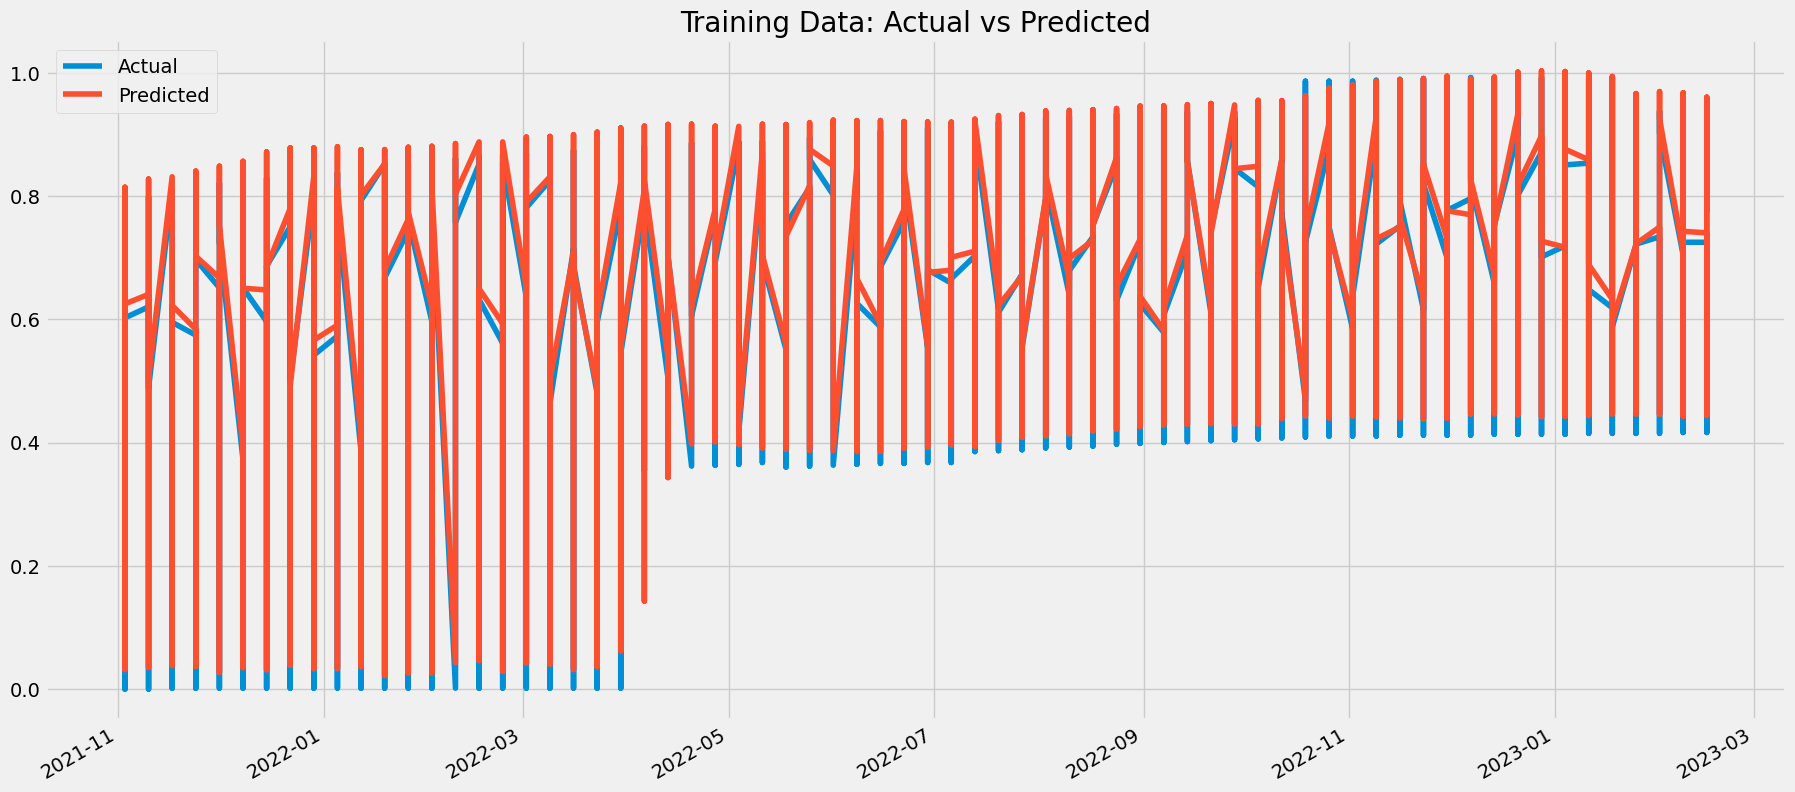

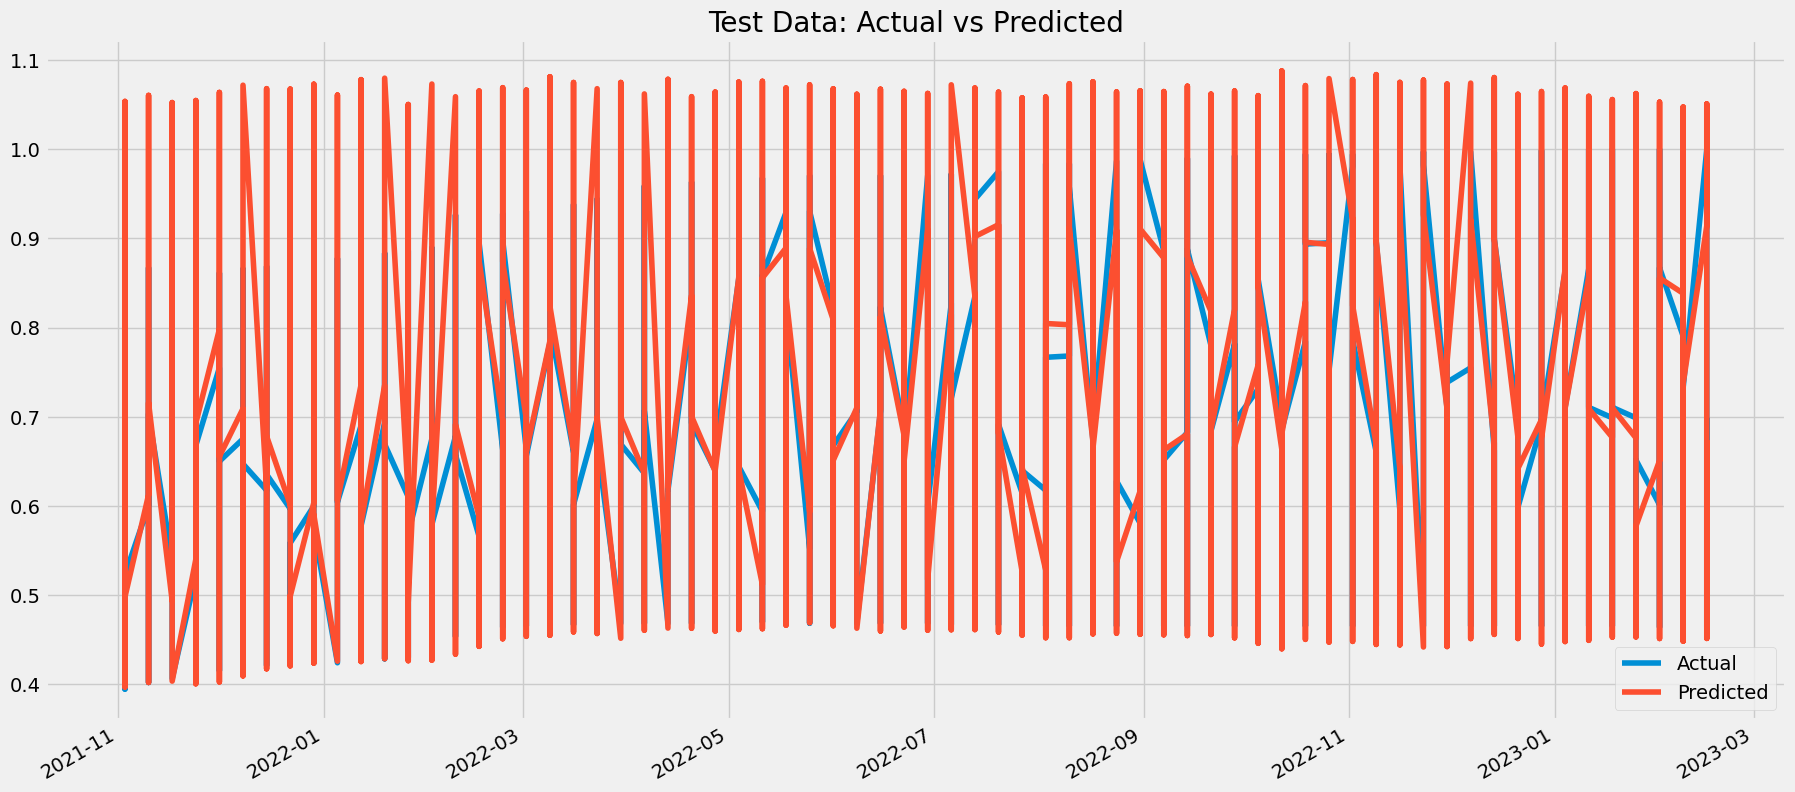

In [31]:
# Generate predictions
train_pred = model_final.predict(X_train).flatten()  # Flatten to ensure it's a 1D array
test_pred = model_final.predict(X_test).flatten()

# Create DataFrames for the actual and predicted values with proper indexing
# Ensure the index is constructed correctly for the training ground truth
train_indices = [x[0] for x in train_series]
train_gt = pd.DataFrame(y_train, columns=['y'], index=train_indices)
train_pred_df = pd.DataFrame(train_pred, columns=['yhat'], index=train_indices)

# Plot training predictions and actual values
pd.concat([train_gt, train_pred_df], axis=1).plot(figsize=(20,10))
plt.legend(['Actual', 'Predicted'])
plt.title('Training Data: Actual vs Predicted')

# Ensure the index is constructed correctly for the test ground truth
test_indices = [x[0] for x in test_series]
test_gt = pd.DataFrame(y_test, columns=['y'], index=test_indices)
test_pred_df = pd.DataFrame(test_pred, columns=['yhat'], index=test_indices)

# Plot test predictions and actual values
pd.concat([test_gt, test_pred_df], axis=1).plot(figsize=(20,10))
plt.legend(['Actual', 'Predicted'])
plt.title('Test Data: Actual vs Predicted')
plt.show()

In [32]:
# Calculate metrics
train_mae = mean_absolute_error(y_train, train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
train_r2 = r2_score(y_train, train_pred)

test_mae = mean_absolute_error(y_test, test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
test_r2 = r2_score(y_test, test_pred)

print("Training Metrics:")
print(f"MAE: {train_mae}")
print(f"RMSE: {train_rmse}")
print(f"R2: {train_r2}")

print("\nTest Metrics:")
print(f"MAE: {test_mae}")
print(f"RMSE: {test_rmse}")
print(f"R2: {test_r2}")

Training Metrics:
MAE: 0.017659861549100833
RMSE: 0.022477830308729935
R2: 0.9746428305943338

Test Metrics:
MAE: 0.04461693524367876
RMSE: 0.09515333062577504
R2: 0.5032300481338718


To tune the model and reduce overfitting, I employed a learning rate scheduler that increases the rate until `epoch` reaches 10 and then decays it every 10 epochs to help the model converge quickly but fine-tune slowly. 

Next, the `build_model` function defines the architecture of the model by taking the hyperparameters I am tuning as inputs. It consists of two LSTM layers, dropout layers to prevent overgitting, and a final dense layer with a sigmoid activation function as it naturally constrains the output to be within the range of 0 to 1, which aligns with the nature of the response variable (a proportion or percentage). Then, the model is compiled with the Adam optimizer and MAE loss.

I then defined two training callbacks:
1. `lr_scheduler` uses `LearningRateScheduler()` to adjust the learning rate based on my `scheduler` function (Chollet, n.d.).
2. `early_stopping` monitors the validation loss, terminates the training process if that loss does not improve after 20 epochs, and restores the best weights observed during training.

As for the hyperparameter grid search, I decided to focus on tuning the number of neurons, dropout rates, L1 and L2 regularization strengths, and batch sizes. For these, I created lists for five hyperparameters to iterate over in nested loops to try all of the possible combinations. 

Within these nested loops, cross validation is performed using `tscv.split` on the train data as I previously described in the base model. In each of these folds, a model is developed with the current combination of hyperparameters and trained on the training set all while monitoring that validation set's performance and using the callbacks.

After each round of training, the best validation loss for that fold is recorded as well as the average validation loss across the folds. For the sets of hyperparameters producing a lower average validation loss than the best configuration already created, the `best_val_loss` and `best_config` variables are updated.

Once all of the hyperparameter combinations are evaluated, the final model using the best configuration obtained during hyperparameter tuning is rebuilt, compiled, and trained on the full training dataset. That model is then evaluated by various metrics. 

I had various initial models that I had created that had issues that I improved on in this model. Those model versions can be found in the [LSTM Initial Models](#LSTM-initial-models) section of the appendix.

Many of the issues I faced during training came down to me trying too hard to conform to the methods Professor Shi used in her LSTM notebook as I tried to normalize my data and impute missing values with zeroes. I also did not implement cross validations in many of my initial models which caused both overfitting and general lack of training accuracy. Finally, I faced long run times when running the tuning for-loops due to their computational complexities.

In [ ]:
# Learning rate scheduler for training
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1 * (epoch // 10))  # More aggressive decay every 10 epochs

# Function to build LSTM model
def build_model(input_shape, output_units=1, neurons=16, dropout=0.3, l1_reg=0.0001, l2_reg=0.0001):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=input_shape,
                   kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=False, 
                   kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(Dropout(dropout))
    model.add(Dense(output_units, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')
    return model

# Callbacks for training
lr_schedule = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Hyperparameters to iterate over
neurons_options = [16, 32]
dropout_options = [0.2, 0.3]
l1_reg_options = [0.0001, 0.00001]
l2_reg_options = [0.0001, 0.00001]
batch_sizes = [32, 64, 128]

# Initialize variables to track the best model configuration
best_val_loss = float('inf')
best_config = {}

# Input shape for LSTM layers
input_shape = (sequence_length, X_train.shape[2])

# Loop over all combinations of hyperparameters
for neurons in neurons_options:
    for dropout in dropout_options:
        for l1_reg in l1_reg_options:
            for l2_reg in l2_reg_options:
                for batch_size in batch_sizes:
                    print(f"Training with neurons: {neurons}, dropout: {dropout}, l1_reg: {l1_reg}, l2_reg: {l2_reg}, batch_size: {batch_size}")
                    
                    # Initialize variables for cross-validation
                    cv_val_loss = []
                    
                    for train_index, val_index in tscv.split(X_train):
                        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
                        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

                        # Build the model with current hyperparameters
                        model = build_model(input_shape, output_units=1, neurons=neurons, dropout=dropout, l1_reg=l1_reg, l2_reg=l2_reg)
                        
                        # Train the model on this fold
                        history = model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=batch_size,
                                            validation_data=(X_val_fold, y_val_fold), shuffle=False, callbacks=[lr_schedule, early_stopping])
                        
                        # Record the best validation loss for this fold
                        cv_val_loss.append(min(history.history['val_loss']))
                    
                    # Average validation loss across all folds
                    avg_val_loss = np.mean(cv_val_loss)
                    
                    # Update the best model configuration if the current one is better
                    if avg_val_loss < best_val_loss:
                        best_val_loss = avg_val_loss
                        best_config = {'neurons': neurons, 'dropout': dropout, 'l1_reg': l1_reg, 'l2_reg': l2_reg, 'batch_size': batch_size}
                        
                    print(f"Average Validation Loss: {avg_val_loss}")
                    print(f"Current Best Configuration: {best_config}")

# Rebuild the model using the best configuration
model_final = build_model(input_shape, output_units=1, neurons=best_config['neurons'], dropout=best_config['dropout'], l1_reg=best_config['l1_reg'], l2_reg=best_config['l2_reg'])
model_final.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

# Retrain the final model on the full training data
model_final.fit(X_train, y_train, epochs=100, batch_size=best_config['batch_size'], shuffle=False, callbacks=[lr_schedule, early_stopping])

#### 3. Model Performance

While this model did not perform as well as many of the other five models developed, I still was able to achieve significant improvement in it. One can see that the [LSTM Initial Models](#LSTM-initial-models) had much higher RMSEs and that I saw significant improvements after using the `MinMaxScaler()`, using forwards and backwards fill for imputation, and implementing cross-validation.

Furthermore, the graphs comparing the predictions to the actual values seem to make much more sense after implementing these changes. Before, it was difficult to understand why the graphs were such odd shapes, but the final graphs reflect a pattern similar to that of the `XGBoost` model developed using ungrouped data. 

The final final metrics obtained were [INSERT]

In [33]:
# Make predictions with the trained model
train_pred = model_final.predict(X_train)
test_pred = model_final.predict(X_test)

# Calculate R-squared for training and testing sets
train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

print(f"Training R-squared: {train_r2}")
print(f"Testing R-squared: {test_r2}")

# Calculate and print performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print(f"Training Metrics: MAE: {mean_absolute_error(y_train, train_pred)}, RMSE: {train_rmse}, Training R-squared: {train_r2}")
print(f"Testing Metrics: MAE: {mean_absolute_error(y_test, test_pred)}, RMSE: {test_rmse}, Testing R-squared: {test_r2}")

Training with neurons: 16, dropout: 0.2, l1_reg: 0.0001, l2_reg: 0.0001, batch_size: 32
Epoch 1/100
18/18 [==============================] - 5s 113ms/step - loss: 0.1871 - val_loss: 0.1973 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 0s 20ms/step - loss: 0.1724 - val_loss: 0.1894 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - 0s 19ms/step - loss: 0.1622 - val_loss: 0.1756 - lr: 0.0010
Epoch 4/100
18/18 [==============================] - 1s 33ms/step - loss: 0.1510 - val_loss: 0.1678 - lr: 0.0010
Epoch 5/100
18/18 [==============================] - 1s 27ms/step - loss: 0.1466 - val_loss: 0.1637 - lr: 0.0010
Epoch 6/100
18/18 [==============================] - 0s 19ms/step - loss: 0.1422 - val_loss: 0.1599 - lr: 0.0010
Epoch 7/100
18/18 [==============================] - 0s 21ms/step - loss: 0.1360 - val_loss: 0.1544 - lr: 0.0010
Epoch 8/100
18/18 [==============================] - 1s 35ms/step - loss: 0.1319 - val_loss: 0.1506 - lr: 0.0010
Epoch 9

Epoch 2/100
68/68 [==============================] - 1s 20ms/step - loss: 0.1468 - val_loss: 0.1498 - lr: 0.0010
Epoch 3/100
68/68 [==============================] - 2s 23ms/step - loss: 0.1337 - val_loss: 0.1311 - lr: 0.0010
Epoch 4/100
68/68 [==============================] - 1s 17ms/step - loss: 0.1198 - val_loss: 0.1220 - lr: 0.0010
Epoch 5/100
68/68 [==============================] - 1s 18ms/step - loss: 0.1122 - val_loss: 0.1250 - lr: 0.0010
Epoch 6/100
68/68 [==============================] - 1s 17ms/step - loss: 0.1032 - val_loss: 0.1182 - lr: 0.0010
Epoch 7/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0997 - val_loss: 0.1133 - lr: 0.0010
Epoch 8/100
68/68 [==============================] - 1s 18ms/step - loss: 0.0950 - val_loss: 0.1144 - lr: 0.0010
Epoch 9/100
68/68 [==============================] - 1s 19ms/step - loss: 0.0936 - val_loss: 0.1027 - lr: 0.0010
Epoch 10/100
68/68 [==============================] - 1s 22ms/step - loss: 0.0866 - val_loss: 0.

Epoch 72/100
68/68 [==============================] - 1s 22ms/step - loss: 0.0598 - val_loss: 0.0572 - lr: 1.8698e-13
Epoch 73/100
68/68 [==============================] - 1s 20ms/step - loss: 0.0594 - val_loss: 0.0572 - lr: 9.2853e-14
Epoch 74/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0597 - val_loss: 0.0572 - lr: 4.6110e-14
Epoch 75/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0606 - val_loss: 0.0572 - lr: 2.2897e-14
Epoch 76/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0593 - val_loss: 0.0572 - lr: 1.1370e-14
Epoch 77/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0598 - val_loss: 0.0572 - lr: 5.6464e-15
Epoch 78/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0600 - val_loss: 0.0572 - lr: 2.8039e-15
Epoch 79/100
68/68 [==============================] - 1s 18ms/step - loss: 0.0598 - val_loss: 0.0572 - lr: 1.3924e-15
Epoch 1/100
85/85 [==============================] - 5s 

Epoch 63/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0520 - val_loss: 0.0660 - lr: 5.0565e-11
Average Validation Loss: 0.07481875568628311
Current Best Configuration: {'neurons': 16, 'dropout': 0.2, 'l1_reg': 0.0001, 'l2_reg': 0.0001, 'batch_size': 32}
Training with neurons: 16, dropout: 0.2, l1_reg: 0.0001, l2_reg: 0.0001, batch_size: 64
Epoch 1/100
9/9 [==============================] - 4s 177ms/step - loss: 0.2023 - val_loss: 0.1934 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 0s 32ms/step - loss: 0.1694 - val_loss: 0.1932 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 0s 32ms/step - loss: 0.1689 - val_loss: 0.1892 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 0s 27ms/step - loss: 0.1647 - val_loss: 0.1803 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 0s 27ms/step - loss: 0.1576 - val_loss: 0.1723 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 0s 28ms/step - loss: 0.1484 

Epoch 29/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0769 - val_loss: 0.0790 - lr: 6.0810e-05
Epoch 30/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0754 - val_loss: 0.0781 - lr: 4.9787e-05
Epoch 31/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0759 - val_loss: 0.0784 - lr: 3.6883e-05
Epoch 32/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0756 - val_loss: 0.0781 - lr: 2.7324e-05
Epoch 33/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0753 - val_loss: 0.0782 - lr: 2.0242e-05
Epoch 34/100
17/17 [==============================] - 0s 18ms/step - loss: 0.0768 - val_loss: 0.0782 - lr: 1.4996e-05
Epoch 35/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0748 - val_loss: 0.0782 - lr: 1.1109e-05
Epoch 36/100
17/17 [==============================] - 0s 19ms/step - loss: 0.0758 - val_loss: 0.0783 - lr: 8.2297e-06
Epoch 37/100
17/17 [==============================] - 0s

43/43 [==============================] - 6s 47ms/step - loss: 0.1714 - val_loss: 0.1601 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 1s 19ms/step - loss: 0.1486 - val_loss: 0.1489 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 1s 18ms/step - loss: 0.1340 - val_loss: 0.1418 - lr: 0.0010
Epoch 4/100
43/43 [==============================] - 1s 18ms/step - loss: 0.1205 - val_loss: 0.1361 - lr: 0.0010
Epoch 5/100
43/43 [==============================] - 1s 18ms/step - loss: 0.1123 - val_loss: 0.1313 - lr: 0.0010
Epoch 6/100
43/43 [==============================] - 1s 20ms/step - loss: 0.1072 - val_loss: 0.1279 - lr: 0.0010
Epoch 7/100
43/43 [==============================] - 1s 18ms/step - loss: 0.1033 - val_loss: 0.1246 - lr: 0.0010
Epoch 8/100
43/43 [==============================] - 1s 19ms/step - loss: 0.1003 - val_loss: 0.1217 - lr: 0.0010
Epoch 9/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0965 - val_loss: 0.1177 - lr: 0.

Epoch 1/100
5/5 [==============================] - 4s 225ms/step - loss: 0.1965 - val_loss: 0.1905 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 0s 44ms/step - loss: 0.1702 - val_loss: 0.1912 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 0s 33ms/step - loss: 0.1644 - val_loss: 0.1942 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 0s 32ms/step - loss: 0.1628 - val_loss: 0.1919 - lr: 0.0010
Epoch 5/100
5/5 [==============================] - 0s 37ms/step - loss: 0.1603 - val_loss: 0.1854 - lr: 0.0010
Epoch 6/100
5/5 [==============================] - 0s 34ms/step - loss: 0.1561 - val_loss: 0.1780 - lr: 0.0010
Epoch 7/100
5/5 [==============================] - 0s 32ms/step - loss: 0.1521 - val_loss: 0.1716 - lr: 0.0010
Epoch 8/100
5/5 [==============================] - 0s 36ms/step - loss: 0.1470 - val_loss: 0.1681 - lr: 0.0010
Epoch 9/100
5/5 [==============================] - 0s 35ms/step - loss: 0.1442 - val_loss: 0.1665 - lr: 0.0010


13/13 [==============================] - 0s 25ms/step - loss: 0.0910 - val_loss: 0.0953 - lr: 1.6702e-08
Epoch 53/100
13/13 [==============================] - 0s 24ms/step - loss: 0.0902 - val_loss: 0.0953 - lr: 1.0130e-08
Epoch 54/100
13/13 [==============================] - 0s 24ms/step - loss: 0.0907 - val_loss: 0.0953 - lr: 6.1442e-09
Epoch 55/100
13/13 [==============================] - 0s 24ms/step - loss: 0.0918 - val_loss: 0.0953 - lr: 3.7267e-09
Epoch 56/100
13/13 [==============================] - 0s 25ms/step - loss: 0.0912 - val_loss: 0.0953 - lr: 2.2603e-09
Epoch 1/100
17/17 [==============================] - 4s 71ms/step - loss: 0.2576 - val_loss: 0.1758 - lr: 0.0010
Epoch 2/100
17/17 [==============================] - 0s 22ms/step - loss: 0.1718 - val_loss: 0.1629 - lr: 0.0010
Epoch 3/100
17/17 [==============================] - 0s 23ms/step - loss: 0.1641 - val_loss: 0.1498 - lr: 0.0010
Epoch 4/100
17/17 [==============================] - 0s 24ms/step - loss: 0.1491 - v

Epoch 66/100
17/17 [==============================] - 0s 26ms/step - loss: 0.0882 - val_loss: 0.0947 - lr: 8.3584e-12
Epoch 67/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0877 - val_loss: 0.0947 - lr: 4.5872e-12
Epoch 68/100
17/17 [==============================] - 0s 27ms/step - loss: 0.0880 - val_loss: 0.0947 - lr: 2.5175e-12
Epoch 69/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0872 - val_loss: 0.0947 - lr: 1.3816e-12
Epoch 70/100
17/17 [==============================] - 0s 25ms/step - loss: 0.0881 - val_loss: 0.0947 - lr: 7.5826e-13
Epoch 71/100
17/17 [==============================] - 0s 28ms/step - loss: 0.0884 - val_loss: 0.0947 - lr: 3.7654e-13
Epoch 72/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0868 - val_loss: 0.0947 - lr: 1.8698e-13
Epoch 73/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0872 - val_loss: 0.0947 - lr: 9.2853e-14
Epoch 74/100
17/17 [==============================] - 0s

Epoch 59/100
22/22 [==============================] - 0s 22ms/step - loss: 0.0749 - val_loss: 0.0875 - lr: 5.0435e-10
Epoch 60/100
22/22 [==============================] - 0s 21ms/step - loss: 0.0749 - val_loss: 0.0875 - lr: 3.0590e-10
Epoch 61/100
22/22 [==============================] - 0s 22ms/step - loss: 0.0748 - val_loss: 0.0875 - lr: 1.6788e-10
Epoch 62/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0753 - val_loss: 0.0875 - lr: 9.2136e-11
Epoch 63/100
22/22 [==============================] - 1s 38ms/step - loss: 0.0749 - val_loss: 0.0875 - lr: 5.0565e-11
Epoch 64/100
22/22 [==============================] - 0s 22ms/step - loss: 0.0752 - val_loss: 0.0875 - lr: 2.7751e-11
Epoch 65/100
22/22 [==============================] - 1s 28ms/step - loss: 0.0742 - val_loss: 0.0875 - lr: 1.5230e-11
Epoch 66/100
22/22 [==============================] - 1s 23ms/step - loss: 0.0744 - val_loss: 0.0875 - lr: 8.3584e-12
Epoch 67/100
22/22 [==============================] - 1s

Epoch 48/100
18/18 [==============================] - 0s 19ms/step - loss: 0.0631 - val_loss: 0.1108 - lr: 1.0104e-07
Epoch 49/100
18/18 [==============================] - 0s 19ms/step - loss: 0.0652 - val_loss: 0.1108 - lr: 6.7729e-08
Epoch 1/100
34/34 [==============================] - 3s 35ms/step - loss: 0.1847 - val_loss: 0.1229 - lr: 0.0010
Epoch 2/100
34/34 [==============================] - 0s 12ms/step - loss: 0.1675 - val_loss: 0.1161 - lr: 0.0010
Epoch 3/100
34/34 [==============================] - 0s 13ms/step - loss: 0.1560 - val_loss: 0.1084 - lr: 0.0010
Epoch 4/100
34/34 [==============================] - 0s 13ms/step - loss: 0.1498 - val_loss: 0.1000 - lr: 0.0010
Epoch 5/100
34/34 [==============================] - 0s 13ms/step - loss: 0.1422 - val_loss: 0.1036 - lr: 0.0010
Epoch 6/100
34/34 [==============================] - 0s 15ms/step - loss: 0.1367 - val_loss: 0.0876 - lr: 0.0010
Epoch 7/100
34/34 [==============================] - 0s 13ms/step - loss: 0.1338 - val

Epoch 56/100
68/68 [==============================] - 1s 15ms/step - loss: 0.0547 - val_loss: 0.0544 - lr: 2.2603e-09
Epoch 57/100
68/68 [==============================] - 1s 16ms/step - loss: 0.0543 - val_loss: 0.0544 - lr: 1.3710e-09
Epoch 58/100
68/68 [==============================] - 1s 15ms/step - loss: 0.0538 - val_loss: 0.0544 - lr: 8.3153e-10
Epoch 59/100
68/68 [==============================] - 1s 15ms/step - loss: 0.0539 - val_loss: 0.0544 - lr: 5.0435e-10
Epoch 60/100
68/68 [==============================] - 1s 15ms/step - loss: 0.0541 - val_loss: 0.0544 - lr: 3.0590e-10
Epoch 61/100
68/68 [==============================] - 1s 15ms/step - loss: 0.0533 - val_loss: 0.0544 - lr: 1.6788e-10
Epoch 62/100
68/68 [==============================] - 1s 15ms/step - loss: 0.0537 - val_loss: 0.0544 - lr: 9.2136e-11
Epoch 63/100
68/68 [==============================] - 1s 15ms/step - loss: 0.0542 - val_loss: 0.0544 - lr: 5.0565e-11
Epoch 64/100
68/68 [==============================] - 1s

Epoch 51/100
85/85 [==============================] - 1s 15ms/step - loss: 0.0500 - val_loss: 0.0640 - lr: 2.7536e-08
Epoch 52/100
85/85 [==============================] - 2s 19ms/step - loss: 0.0507 - val_loss: 0.0640 - lr: 1.6702e-08
Epoch 53/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0500 - val_loss: 0.0640 - lr: 1.0130e-08
Epoch 54/100
85/85 [==============================] - 1s 15ms/step - loss: 0.0500 - val_loss: 0.0640 - lr: 6.1442e-09
Epoch 55/100
85/85 [==============================] - 1s 15ms/step - loss: 0.0501 - val_loss: 0.0640 - lr: 3.7267e-09
Epoch 56/100
85/85 [==============================] - 1s 15ms/step - loss: 0.0502 - val_loss: 0.0640 - lr: 2.2603e-09
Epoch 57/100
85/85 [==============================] - 1s 15ms/step - loss: 0.0504 - val_loss: 0.0640 - lr: 1.3710e-09
Epoch 58/100
85/85 [==============================] - 1s 15ms/step - loss: 0.0500 - val_loss: 0.0640 - lr: 8.3153e-10
Epoch 59/100
85/85 [==============================] - 1s

Epoch 11/100
17/17 [==============================] - 0s 16ms/step - loss: 0.1073 - val_loss: 0.0983 - lr: 9.0484e-04
Epoch 12/100
17/17 [==============================] - 0s 16ms/step - loss: 0.1000 - val_loss: 0.1066 - lr: 8.1873e-04
Epoch 13/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0966 - val_loss: 0.1053 - lr: 7.4082e-04
Epoch 14/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0965 - val_loss: 0.0980 - lr: 6.7032e-04
Epoch 15/100
17/17 [==============================] - 0s 18ms/step - loss: 0.0933 - val_loss: 0.0997 - lr: 6.0653e-04
Epoch 16/100
17/17 [==============================] - 0s 21ms/step - loss: 0.0910 - val_loss: 0.0987 - lr: 5.4881e-04
Epoch 17/100
17/17 [==============================] - 0s 21ms/step - loss: 0.0905 - val_loss: 0.1002 - lr: 4.9659e-04
Epoch 18/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0889 - val_loss: 0.1024 - lr: 4.4933e-04
Epoch 19/100
17/17 [==============================] - 0s

Epoch 39/100
26/26 [==============================] - 0s 19ms/step - loss: 0.0713 - val_loss: 0.0752 - lr: 3.3460e-06
Epoch 40/100
26/26 [==============================] - 0s 19ms/step - loss: 0.0713 - val_loss: 0.0751 - lr: 2.4788e-06
Epoch 41/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0705 - val_loss: 0.0750 - lr: 1.6616e-06
Epoch 42/100
26/26 [==============================] - 0s 19ms/step - loss: 0.0708 - val_loss: 0.0750 - lr: 1.1138e-06
Epoch 43/100
26/26 [==============================] - 0s 19ms/step - loss: 0.0711 - val_loss: 0.0750 - lr: 7.4659e-07
Epoch 44/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0714 - val_loss: 0.0750 - lr: 5.0045e-07
Epoch 45/100
26/26 [==============================] - 0s 19ms/step - loss: 0.0715 - val_loss: 0.0750 - lr: 3.3546e-07
Epoch 46/100
26/26 [==============================] - 0s 19ms/step - loss: 0.0725 - val_loss: 0.0750 - lr: 2.2487e-07
Epoch 47/100
26/26 [==============================] - 1s

Epoch 54/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0697 - val_loss: 0.0717 - lr: 6.1442e-09
Epoch 55/100
34/34 [==============================] - 1s 18ms/step - loss: 0.0695 - val_loss: 0.0717 - lr: 3.7267e-09
Epoch 56/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0699 - val_loss: 0.0717 - lr: 2.2603e-09
Epoch 57/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0700 - val_loss: 0.0717 - lr: 1.3710e-09
Epoch 58/100
34/34 [==============================] - 1s 22ms/step - loss: 0.0687 - val_loss: 0.0717 - lr: 8.3153e-10
Epoch 59/100
34/34 [==============================] - 1s 21ms/step - loss: 0.0696 - val_loss: 0.0717 - lr: 5.0435e-10
Epoch 60/100
34/34 [==============================] - 1s 21ms/step - loss: 0.0698 - val_loss: 0.0717 - lr: 3.0590e-10
Epoch 61/100
34/34 [==============================] - 1s 21ms/step - loss: 0.0696 - val_loss: 0.0717 - lr: 1.6788e-10
Epoch 62/100
34/34 [==============================] - 1s

Epoch 47/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0594 - val_loss: 0.0686 - lr: 1.5073e-07
Epoch 48/100
43/43 [==============================] - 1s 17ms/step - loss: 0.0596 - val_loss: 0.0686 - lr: 1.0104e-07
Epoch 49/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0596 - val_loss: 0.0686 - lr: 6.7729e-08
Epoch 50/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0580 - val_loss: 0.0686 - lr: 4.5400e-08
Epoch 51/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0590 - val_loss: 0.0686 - lr: 2.7536e-08
Epoch 52/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0597 - val_loss: 0.0686 - lr: 1.6702e-08
Epoch 53/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0591 - val_loss: 0.0686 - lr: 1.0130e-08
Epoch 54/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0591 - val_loss: 0.0686 - lr: 6.1442e-09
Epoch 55/100
43/43 [==============================] - 1s

Epoch 10/100
9/9 [==============================] - 0s 25ms/step - loss: 0.1194 - val_loss: 0.1136 - lr: 0.0010
Epoch 11/100
9/9 [==============================] - 0s 26ms/step - loss: 0.1135 - val_loss: 0.1020 - lr: 9.0484e-04
Epoch 12/100
9/9 [==============================] - 0s 25ms/step - loss: 0.1072 - val_loss: 0.1052 - lr: 8.1873e-04
Epoch 13/100
9/9 [==============================] - 0s 27ms/step - loss: 0.1049 - val_loss: 0.0998 - lr: 7.4082e-04
Epoch 14/100
9/9 [==============================] - 0s 26ms/step - loss: 0.1004 - val_loss: 0.0981 - lr: 6.7032e-04
Epoch 15/100
9/9 [==============================] - 0s 25ms/step - loss: 0.0982 - val_loss: 0.0990 - lr: 6.0653e-04
Epoch 16/100
9/9 [==============================] - 0s 27ms/step - loss: 0.0975 - val_loss: 0.0940 - lr: 5.4881e-04
Epoch 17/100
9/9 [==============================] - 0s 26ms/step - loss: 0.0951 - val_loss: 0.0965 - lr: 4.9659e-04
Epoch 18/100
9/9 [==============================] - 0s 27ms/step - loss: 0.0

Epoch 52/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0719 - val_loss: 0.0602 - lr: 1.6702e-08
Epoch 53/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0716 - val_loss: 0.0602 - lr: 1.0130e-08
Epoch 54/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0710 - val_loss: 0.0602 - lr: 6.1442e-09
Epoch 55/100
17/17 [==============================] - 0s 25ms/step - loss: 0.0715 - val_loss: 0.0602 - lr: 3.7267e-09
Epoch 56/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0717 - val_loss: 0.0602 - lr: 2.2603e-09
Epoch 57/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0718 - val_loss: 0.0602 - lr: 1.3710e-09
Epoch 58/100
17/17 [==============================] - 0s 25ms/step - loss: 0.0718 - val_loss: 0.0602 - lr: 8.3153e-10
Epoch 59/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0715 - val_loss: 0.0602 - lr: 5.0435e-10
Epoch 1/100
22/22 [==============================] - 4s 

Epoch 63/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0721 - val_loss: 0.0779 - lr: 5.0565e-11
Epoch 64/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0725 - val_loss: 0.0779 - lr: 2.7751e-11
Epoch 65/100
22/22 [==============================] - 1s 24ms/step - loss: 0.0722 - val_loss: 0.0779 - lr: 1.5230e-11
Epoch 66/100
22/22 [==============================] - 1s 24ms/step - loss: 0.0723 - val_loss: 0.0779 - lr: 8.3584e-12
Epoch 67/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0726 - val_loss: 0.0779 - lr: 4.5872e-12
Epoch 68/100
22/22 [==============================] - 0s 22ms/step - loss: 0.0730 - val_loss: 0.0779 - lr: 2.5175e-12
Epoch 69/100
22/22 [==============================] - 0s 22ms/step - loss: 0.0715 - val_loss: 0.0779 - lr: 1.3816e-12
Epoch 70/100
22/22 [==============================] - 0s 22ms/step - loss: 0.0733 - val_loss: 0.0779 - lr: 7.5826e-13
Epoch 71/100
22/22 [==============================] - 0s

Epoch 45/100
51/51 [==============================] - 1s 17ms/step - loss: 0.0468 - val_loss: 0.0507 - lr: 3.3546e-07
Epoch 46/100
51/51 [==============================] - 1s 20ms/step - loss: 0.0468 - val_loss: 0.0507 - lr: 2.2487e-07
Epoch 47/100
51/51 [==============================] - 1s 16ms/step - loss: 0.0475 - val_loss: 0.0507 - lr: 1.5073e-07
Epoch 48/100
51/51 [==============================] - 1s 16ms/step - loss: 0.0471 - val_loss: 0.0507 - lr: 1.0104e-07
Epoch 49/100
51/51 [==============================] - 1s 20ms/step - loss: 0.0465 - val_loss: 0.0507 - lr: 6.7729e-08
Epoch 50/100
51/51 [==============================] - 1s 21ms/step - loss: 0.0468 - val_loss: 0.0507 - lr: 4.5400e-08
Epoch 51/100
51/51 [==============================] - 1s 16ms/step - loss: 0.0465 - val_loss: 0.0507 - lr: 2.7536e-08
Epoch 52/100
51/51 [==============================] - 1s 16ms/step - loss: 0.0472 - val_loss: 0.0507 - lr: 1.6702e-08
Epoch 53/100
51/51 [==============================] - 1s

Epoch 58/100
68/68 [==============================] - 1s 15ms/step - loss: 0.0472 - val_loss: 0.0466 - lr: 8.3153e-10
Epoch 59/100
68/68 [==============================] - 1s 15ms/step - loss: 0.0462 - val_loss: 0.0466 - lr: 5.0435e-10
Epoch 60/100
68/68 [==============================] - 1s 15ms/step - loss: 0.0464 - val_loss: 0.0466 - lr: 3.0590e-10
Epoch 61/100
68/68 [==============================] - 1s 15ms/step - loss: 0.0460 - val_loss: 0.0466 - lr: 1.6788e-10
Epoch 62/100
68/68 [==============================] - 1s 21ms/step - loss: 0.0461 - val_loss: 0.0466 - lr: 9.2136e-11
Epoch 63/100
68/68 [==============================] - 2s 24ms/step - loss: 0.0461 - val_loss: 0.0466 - lr: 5.0565e-11
Epoch 64/100
68/68 [==============================] - 2s 32ms/step - loss: 0.0459 - val_loss: 0.0466 - lr: 2.7751e-11
Epoch 65/100
68/68 [==============================] - 2s 23ms/step - loss: 0.0465 - val_loss: 0.0466 - lr: 1.5230e-11
Epoch 66/100
68/68 [==============================] - 1s

Epoch 47/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0414 - val_loss: 0.0548 - lr: 1.5073e-07
Epoch 48/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0409 - val_loss: 0.0548 - lr: 1.0104e-07
Epoch 49/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0400 - val_loss: 0.0548 - lr: 6.7729e-08
Epoch 50/100
85/85 [==============================] - 2s 18ms/step - loss: 0.0416 - val_loss: 0.0548 - lr: 4.5400e-08
Epoch 51/100
85/85 [==============================] - 2s 20ms/step - loss: 0.0409 - val_loss: 0.0548 - lr: 2.7536e-08
Epoch 52/100
85/85 [==============================] - 2s 19ms/step - loss: 0.0408 - val_loss: 0.0548 - lr: 1.6702e-08
Epoch 53/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0421 - val_loss: 0.0548 - lr: 1.0130e-08
Epoch 54/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0405 - val_loss: 0.0548 - lr: 6.1442e-09
Epoch 55/100
85/85 [==============================] - 1s

Epoch 8/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0913 - val_loss: 0.0617 - lr: 0.0010
Epoch 9/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0865 - val_loss: 0.0586 - lr: 0.0010
Epoch 10/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0823 - val_loss: 0.0653 - lr: 0.0010
Epoch 11/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0743 - val_loss: 0.0639 - lr: 9.0484e-04
Epoch 12/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0695 - val_loss: 0.0560 - lr: 8.1873e-04
Epoch 13/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0673 - val_loss: 0.0527 - lr: 7.4082e-04
Epoch 14/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0672 - val_loss: 0.0500 - lr: 6.7032e-04
Epoch 15/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0744 - val_loss: 0.0618 - lr: 6.0653e-04
Epoch 16/100
17/17 [==============================] - 0s 18ms/step - l

Epoch 76/100
34/34 [==============================] - 1s 20ms/step - loss: 0.0536 - val_loss: 0.0516 - lr: 1.1370e-14
Epoch 1/100
43/43 [==============================] - 5s 39ms/step - loss: 0.1358 - val_loss: 0.1069 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 1s 18ms/step - loss: 0.1094 - val_loss: 0.1028 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0975 - val_loss: 0.0966 - lr: 0.0010
Epoch 4/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0862 - val_loss: 0.0908 - lr: 0.0010
Epoch 5/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0806 - val_loss: 0.0886 - lr: 0.0010
Epoch 6/100
43/43 [==============================] - 1s 25ms/step - loss: 0.0763 - val_loss: 0.0875 - lr: 0.0010
Epoch 7/100
43/43 [==============================] - 2s 35ms/step - loss: 0.0778 - val_loss: 0.0856 - lr: 0.0010
Epoch 8/100
43/43 [==============================] - 1s 27ms/step - loss: 0.0721 - val_loss

Epoch 70/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0436 - val_loss: 0.0596 - lr: 7.5826e-13
Epoch 71/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0430 - val_loss: 0.0596 - lr: 3.7654e-13
Average Validation Loss: 0.06284483596682548
Current Best Configuration: {'neurons': 16, 'dropout': 0.2, 'l1_reg': 1e-05, 'l2_reg': 0.0001, 'batch_size': 64}
Training with neurons: 16, dropout: 0.2, l1_reg: 1e-05, l2_reg: 0.0001, batch_size: 128
Epoch 1/100
5/5 [==============================] - 4s 219ms/step - loss: 0.1605 - val_loss: 0.1323 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 0s 44ms/step - loss: 0.1103 - val_loss: 0.1245 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 0s 34ms/step - loss: 0.1017 - val_loss: 0.1305 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 0s 33ms/step - loss: 0.1061 - val_loss: 0.1380 - lr: 0.0010
Epoch 5/100
5/5 [==============================] - 0s 34ms/step - loss: 0

17/17 [==============================] - 0s 29ms/step - loss: 0.0630 - val_loss: 0.0677 - lr: 3.6788e-04
Epoch 21/100
17/17 [==============================] - 0s 28ms/step - loss: 0.0632 - val_loss: 0.0614 - lr: 3.0119e-04
Epoch 22/100
17/17 [==============================] - 1s 32ms/step - loss: 0.0608 - val_loss: 0.0578 - lr: 2.4660e-04
Epoch 23/100
17/17 [==============================] - 1s 33ms/step - loss: 0.0569 - val_loss: 0.0564 - lr: 2.0190e-04
Epoch 24/100
17/17 [==============================] - 0s 26ms/step - loss: 0.0551 - val_loss: 0.0561 - lr: 1.6530e-04
Epoch 25/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0548 - val_loss: 0.0548 - lr: 1.3534e-04
Epoch 26/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0545 - val_loss: 0.0537 - lr: 1.1080e-04
Epoch 27/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0550 - val_loss: 0.0532 - lr: 9.0718e-05
Epoch 28/100
17/17 [==============================] - 0s 24ms/step - 

Epoch 17/100
22/22 [==============================] - 1s 24ms/step - loss: 0.0647 - val_loss: 0.0773 - lr: 4.9659e-04
Epoch 18/100
22/22 [==============================] - 1s 25ms/step - loss: 0.0633 - val_loss: 0.0764 - lr: 4.4933e-04
Epoch 19/100
22/22 [==============================] - 1s 24ms/step - loss: 0.0618 - val_loss: 0.0730 - lr: 4.0657e-04
Epoch 20/100
22/22 [==============================] - 1s 23ms/step - loss: 0.0603 - val_loss: 0.0733 - lr: 3.6788e-04
Epoch 21/100
22/22 [==============================] - 1s 23ms/step - loss: 0.0593 - val_loss: 0.0699 - lr: 3.0119e-04
Epoch 22/100
22/22 [==============================] - 1s 23ms/step - loss: 0.0570 - val_loss: 0.0642 - lr: 2.4660e-04
Epoch 23/100
22/22 [==============================] - 1s 23ms/step - loss: 0.0536 - val_loss: 0.0616 - lr: 2.0190e-04
Epoch 24/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0532 - val_loss: 0.0598 - lr: 1.6530e-04
Epoch 25/100
22/22 [==============================] - 1s

Epoch 29/100
18/18 [==============================] - 0s 28ms/step - loss: 0.0392 - val_loss: 0.0895 - lr: 6.0810e-05
Epoch 30/100
18/18 [==============================] - 0s 23ms/step - loss: 0.0422 - val_loss: 0.0912 - lr: 4.9787e-05
Epoch 31/100
18/18 [==============================] - 0s 22ms/step - loss: 0.0398 - val_loss: 0.0910 - lr: 3.6883e-05
Epoch 32/100
18/18 [==============================] - 0s 25ms/step - loss: 0.0406 - val_loss: 0.0889 - lr: 2.7324e-05
Epoch 33/100
18/18 [==============================] - 0s 23ms/step - loss: 0.0402 - val_loss: 0.0898 - lr: 2.0242e-05
Epoch 34/100
18/18 [==============================] - 0s 24ms/step - loss: 0.0393 - val_loss: 0.0899 - lr: 1.4996e-05
Epoch 35/100
18/18 [==============================] - 0s 23ms/step - loss: 0.0398 - val_loss: 0.0900 - lr: 1.1109e-05
Epoch 36/100
18/18 [==============================] - 0s 26ms/step - loss: 0.0387 - val_loss: 0.0893 - lr: 8.2297e-06
Epoch 37/100
18/18 [==============================] - 0s

Epoch 43/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0457 - val_loss: 0.0532 - lr: 7.4659e-07
Epoch 44/100
68/68 [==============================] - 1s 19ms/step - loss: 0.0458 - val_loss: 0.0532 - lr: 5.0045e-07
Epoch 45/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0466 - val_loss: 0.0532 - lr: 3.3546e-07
Epoch 46/100
68/68 [==============================] - 1s 16ms/step - loss: 0.0462 - val_loss: 0.0531 - lr: 2.2487e-07
Epoch 47/100
68/68 [==============================] - 1s 16ms/step - loss: 0.0456 - val_loss: 0.0531 - lr: 1.5073e-07
Epoch 48/100
68/68 [==============================] - 1s 16ms/step - loss: 0.0455 - val_loss: 0.0531 - lr: 1.0104e-07
Epoch 49/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0460 - val_loss: 0.0531 - lr: 6.7729e-08
Epoch 50/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0457 - val_loss: 0.0531 - lr: 4.5400e-08
Epoch 51/100
68/68 [==============================] - 1s

Epoch 36/100
85/85 [==============================] - 2s 20ms/step - loss: 0.0379 - val_loss: 0.0568 - lr: 8.2297e-06
Epoch 37/100
85/85 [==============================] - 2s 18ms/step - loss: 0.0383 - val_loss: 0.0568 - lr: 6.0967e-06
Epoch 38/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0373 - val_loss: 0.0568 - lr: 4.5166e-06
Epoch 39/100
85/85 [==============================] - 1s 18ms/step - loss: 0.0380 - val_loss: 0.0568 - lr: 3.3460e-06
Epoch 40/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0375 - val_loss: 0.0568 - lr: 2.4788e-06
Epoch 41/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0374 - val_loss: 0.0568 - lr: 1.6616e-06
Epoch 42/100
85/85 [==============================] - 2s 18ms/step - loss: 0.0368 - val_loss: 0.0568 - lr: 1.1138e-06
Epoch 43/100
85/85 [==============================] - 2s 25ms/step - loss: 0.0370 - val_loss: 0.0568 - lr: 7.4659e-07
Epoch 44/100
85/85 [==============================] - 2s

Epoch 12/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0768 - val_loss: 0.0724 - lr: 8.1873e-04
Epoch 13/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0735 - val_loss: 0.0724 - lr: 7.4082e-04
Epoch 14/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0697 - val_loss: 0.0748 - lr: 6.7032e-04
Epoch 15/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0670 - val_loss: 0.0820 - lr: 6.0653e-04
Epoch 16/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0669 - val_loss: 0.0780 - lr: 5.4881e-04
Epoch 17/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0626 - val_loss: 0.0784 - lr: 4.9659e-04
Epoch 18/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0640 - val_loss: 0.0792 - lr: 4.4933e-04
Epoch 19/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0632 - val_loss: 0.0804 - lr: 4.0657e-04
Epoch 20/100
17/17 [==============================] - 0s

Epoch 3/100
34/34 [==============================] - 1s 20ms/step - loss: 0.0922 - val_loss: 0.1123 - lr: 0.0010
Epoch 4/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0880 - val_loss: 0.1203 - lr: 0.0010
Epoch 5/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0887 - val_loss: 0.1066 - lr: 0.0010
Epoch 6/100
34/34 [==============================] - 1s 18ms/step - loss: 0.0819 - val_loss: 0.1084 - lr: 0.0010
Epoch 7/100
34/34 [==============================] - 1s 22ms/step - loss: 0.0792 - val_loss: 0.1031 - lr: 0.0010
Epoch 8/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0740 - val_loss: 0.0939 - lr: 0.0010
Epoch 9/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0697 - val_loss: 0.0985 - lr: 0.0010
Epoch 10/100
34/34 [==============================] - 1s 20ms/step - loss: 0.0686 - val_loss: 0.0882 - lr: 0.0010
Epoch 11/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0679 - val_loss: 0

Epoch 73/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0494 - val_loss: 0.0527 - lr: 9.2853e-14
Epoch 74/100
34/34 [==============================] - 1s 20ms/step - loss: 0.0498 - val_loss: 0.0527 - lr: 4.6110e-14
Epoch 75/100
34/34 [==============================] - 1s 20ms/step - loss: 0.0513 - val_loss: 0.0527 - lr: 2.2897e-14
Epoch 76/100
34/34 [==============================] - 1s 20ms/step - loss: 0.0511 - val_loss: 0.0527 - lr: 1.1370e-14
Epoch 77/100
34/34 [==============================] - 1s 20ms/step - loss: 0.0507 - val_loss: 0.0527 - lr: 5.6464e-15
Epoch 78/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0505 - val_loss: 0.0527 - lr: 2.8039e-15
Epoch 79/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0499 - val_loss: 0.0527 - lr: 1.3924e-15
Epoch 80/100
34/34 [==============================] - 1s 20ms/step - loss: 0.0502 - val_loss: 0.0527 - lr: 6.9144e-16
Epoch 81/100
34/34 [==============================] - 1s

Epoch 62/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0408 - val_loss: 0.0595 - lr: 9.2136e-11
Epoch 63/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0400 - val_loss: 0.0595 - lr: 5.0565e-11
Epoch 64/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0410 - val_loss: 0.0595 - lr: 2.7751e-11
Epoch 65/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0406 - val_loss: 0.0595 - lr: 1.5230e-11
Epoch 66/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0408 - val_loss: 0.0595 - lr: 8.3584e-12
Epoch 67/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0405 - val_loss: 0.0595 - lr: 4.5872e-12
Epoch 68/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0405 - val_loss: 0.0595 - lr: 2.5175e-12
Epoch 69/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0407 - val_loss: 0.0595 - lr: 1.3816e-12
Epoch 70/100
43/43 [==============================] - 1s

9/9 [==============================] - 0s 27ms/step - loss: 0.0624 - val_loss: 0.0744 - lr: 9.0718e-05
Epoch 1/100
13/13 [==============================] - 5s 108ms/step - loss: 0.1417 - val_loss: 0.1148 - lr: 0.0010
Epoch 2/100
13/13 [==============================] - 0s 31ms/step - loss: 0.1099 - val_loss: 0.1092 - lr: 0.0010
Epoch 3/100
13/13 [==============================] - 0s 25ms/step - loss: 0.1001 - val_loss: 0.1147 - lr: 0.0010
Epoch 4/100
13/13 [==============================] - 0s 28ms/step - loss: 0.0909 - val_loss: 0.0992 - lr: 0.0010
Epoch 5/100
13/13 [==============================] - 0s 31ms/step - loss: 0.0854 - val_loss: 0.0895 - lr: 0.0010
Epoch 6/100
13/13 [==============================] - 0s 28ms/step - loss: 0.0833 - val_loss: 0.0792 - lr: 0.0010
Epoch 7/100
13/13 [==============================] - 0s 29ms/step - loss: 0.0793 - val_loss: 0.0733 - lr: 0.0010
Epoch 8/100
13/13 [==============================] - 0s 31ms/step - loss: 0.0746 - val_loss: 0.0667 - lr:

Epoch 9/100
22/22 [==============================] - 0s 22ms/step - loss: 0.0889 - val_loss: 0.0989 - lr: 0.0010
Epoch 10/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0827 - val_loss: 0.0958 - lr: 0.0010
Epoch 11/100
22/22 [==============================] - 0s 22ms/step - loss: 0.0803 - val_loss: 0.0970 - lr: 9.0484e-04
Epoch 12/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0813 - val_loss: 0.0961 - lr: 8.1873e-04
Epoch 13/100
22/22 [==============================] - 0s 22ms/step - loss: 0.0779 - val_loss: 0.0945 - lr: 7.4082e-04
Epoch 14/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0733 - val_loss: 0.0942 - lr: 6.7032e-04
Epoch 15/100
22/22 [==============================] - 0s 22ms/step - loss: 0.0720 - val_loss: 0.0922 - lr: 6.0653e-04
Epoch 16/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0698 - val_loss: 0.0927 - lr: 5.4881e-04
Epoch 17/100
22/22 [==============================] - 1s 23ms/ste

34/34 [==============================] - 1s 20ms/step - loss: 0.0716 - val_loss: 0.0798 - lr: 1.4996e-05
Epoch 35/100
34/34 [==============================] - 1s 16ms/step - loss: 0.0713 - val_loss: 0.0796 - lr: 1.1109e-05
Epoch 36/100
34/34 [==============================] - 0s 13ms/step - loss: 0.0698 - val_loss: 0.0794 - lr: 8.2297e-06
Epoch 37/100
34/34 [==============================] - 0s 13ms/step - loss: 0.0707 - val_loss: 0.0793 - lr: 6.0967e-06
Epoch 38/100
34/34 [==============================] - 0s 13ms/step - loss: 0.0692 - val_loss: 0.0792 - lr: 4.5166e-06
Epoch 39/100
34/34 [==============================] - 0s 14ms/step - loss: 0.0707 - val_loss: 0.0792 - lr: 3.3460e-06
Epoch 40/100
34/34 [==============================] - 0s 13ms/step - loss: 0.0711 - val_loss: 0.0793 - lr: 2.4788e-06
Epoch 41/100
34/34 [==============================] - 0s 13ms/step - loss: 0.0696 - val_loss: 0.0793 - lr: 1.6616e-06
Epoch 42/100
34/34 [==============================] - 0s 14ms/step - 

Epoch 5/100
85/85 [==============================] - 1s 15ms/step - loss: 0.1202 - val_loss: 0.1084 - lr: 0.0010
Epoch 6/100
85/85 [==============================] - 1s 15ms/step - loss: 0.1143 - val_loss: 0.1027 - lr: 0.0010
Epoch 7/100
85/85 [==============================] - 1s 15ms/step - loss: 0.1127 - val_loss: 0.1009 - lr: 0.0010
Epoch 8/100
85/85 [==============================] - 1s 15ms/step - loss: 0.1090 - val_loss: 0.1021 - lr: 0.0010
Epoch 9/100
85/85 [==============================] - 1s 16ms/step - loss: 0.1046 - val_loss: 0.1015 - lr: 0.0010
Epoch 10/100
85/85 [==============================] - 2s 20ms/step - loss: 0.1007 - val_loss: 0.0933 - lr: 0.0010
Epoch 11/100
85/85 [==============================] - 2s 19ms/step - loss: 0.0949 - val_loss: 0.0890 - lr: 9.0484e-04
Epoch 12/100
85/85 [==============================] - 2s 20ms/step - loss: 0.0916 - val_loss: 0.0874 - lr: 8.1873e-04
Epoch 13/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0878 - v

Epoch 1/100
9/9 [==============================] - 4s 120ms/step - loss: 0.2673 - val_loss: 0.2112 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 0s 25ms/step - loss: 0.1759 - val_loss: 0.1844 - lr: 0.0010
Epoch 3/100
9/9 [==============================] - 0s 25ms/step - loss: 0.1614 - val_loss: 0.1879 - lr: 0.0010
Epoch 4/100
9/9 [==============================] - 0s 26ms/step - loss: 0.1617 - val_loss: 0.1857 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 0s 27ms/step - loss: 0.1615 - val_loss: 0.1796 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 0s 27ms/step - loss: 0.1562 - val_loss: 0.1742 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 0s 26ms/step - loss: 0.1562 - val_loss: 0.1685 - lr: 0.0010
Epoch 8/100
9/9 [==============================] - 0s 26ms/step - loss: 0.1440 - val_loss: 0.1649 - lr: 0.0010
Epoch 9/100
9/9 [==============================] - 0s 27ms/step - loss: 0.1421 - val_loss: 0.1619 - lr: 0.0010


Epoch 47/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0808 - val_loss: 0.0758 - lr: 1.5073e-07
Epoch 48/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0817 - val_loss: 0.0758 - lr: 1.0104e-07
Epoch 49/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0810 - val_loss: 0.0758 - lr: 6.7729e-08
Epoch 50/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0811 - val_loss: 0.0758 - lr: 4.5400e-08
Epoch 51/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0798 - val_loss: 0.0758 - lr: 2.7536e-08
Epoch 52/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0818 - val_loss: 0.0758 - lr: 1.6702e-08
Epoch 53/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0809 - val_loss: 0.0758 - lr: 1.0130e-08
Epoch 54/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0809 - val_loss: 0.0758 - lr: 6.1442e-09
Epoch 55/100
26/26 [==============================] - 1s

Epoch 58/100
34/34 [==============================] - 1s 20ms/step - loss: 0.0713 - val_loss: 0.0658 - lr: 8.3153e-10
Epoch 59/100
34/34 [==============================] - 1s 20ms/step - loss: 0.0707 - val_loss: 0.0658 - lr: 5.0435e-10
Epoch 60/100
34/34 [==============================] - 1s 26ms/step - loss: 0.0716 - val_loss: 0.0658 - lr: 3.0590e-10
Epoch 61/100
34/34 [==============================] - 1s 20ms/step - loss: 0.0724 - val_loss: 0.0658 - lr: 1.6788e-10
Epoch 62/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0707 - val_loss: 0.0658 - lr: 9.2136e-11
Epoch 1/100
43/43 [==============================] - 5s 38ms/step - loss: 0.1839 - val_loss: 0.1556 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 1s 18ms/step - loss: 0.1573 - val_loss: 0.1437 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 1s 19ms/step - loss: 0.1448 - val_loss: 0.1298 - lr: 0.0010
Epoch 4/100
43/43 [==============================] - 1s 19ms/step - los

5/5 [==============================] - 0s 36ms/step - loss: 0.1685 - val_loss: 0.1914 - lr: 0.0010
Epoch 7/100
5/5 [==============================] - 0s 35ms/step - loss: 0.1655 - val_loss: 0.1855 - lr: 0.0010
Epoch 8/100
5/5 [==============================] - 0s 36ms/step - loss: 0.1622 - val_loss: 0.1798 - lr: 0.0010
Epoch 9/100
5/5 [==============================] - 0s 35ms/step - loss: 0.1565 - val_loss: 0.1758 - lr: 0.0010
Epoch 10/100
5/5 [==============================] - 0s 35ms/step - loss: 0.1507 - val_loss: 0.1748 - lr: 0.0010
Epoch 11/100
5/5 [==============================] - 0s 34ms/step - loss: 0.1508 - val_loss: 0.1745 - lr: 9.0484e-04
Epoch 12/100
5/5 [==============================] - 0s 34ms/step - loss: 0.1459 - val_loss: 0.1747 - lr: 8.1873e-04
Epoch 13/100
5/5 [==============================] - 0s 36ms/step - loss: 0.1426 - val_loss: 0.1742 - lr: 7.4082e-04
Epoch 14/100
5/5 [==============================] - 0s 41ms/step - loss: 0.1419 - val_loss: 0.1728 - lr: 6.7

9/9 [==============================] - 0s 27ms/step - loss: 0.1659 - val_loss: 0.1408 - lr: 0.0010
Epoch 5/100
9/9 [==============================] - 0s 27ms/step - loss: 0.1601 - val_loss: 0.1273 - lr: 0.0010
Epoch 6/100
9/9 [==============================] - 0s 26ms/step - loss: 0.1529 - val_loss: 0.1192 - lr: 0.0010
Epoch 7/100
9/9 [==============================] - 0s 28ms/step - loss: 0.1431 - val_loss: 0.1241 - lr: 0.0010
Epoch 8/100
9/9 [==============================] - 0s 28ms/step - loss: 0.1378 - val_loss: 0.1183 - lr: 0.0010
Epoch 9/100
9/9 [==============================] - 0s 28ms/step - loss: 0.1348 - val_loss: 0.1230 - lr: 0.0010
Epoch 10/100
9/9 [==============================] - 0s 28ms/step - loss: 0.1283 - val_loss: 0.1215 - lr: 0.0010
Epoch 11/100
9/9 [==============================] - 0s 29ms/step - loss: 0.1232 - val_loss: 0.1155 - lr: 9.0484e-04
Epoch 12/100
9/9 [==============================] - 0s 28ms/step - loss: 0.1211 - val_loss: 0.1271 - lr: 8.1873e-04
Ep

13/13 [==============================] - 0s 25ms/step - loss: 0.0885 - val_loss: 0.0841 - lr: 1.6530e-04
Epoch 25/100
13/13 [==============================] - 0s 26ms/step - loss: 0.0890 - val_loss: 0.0850 - lr: 1.3534e-04
Epoch 26/100
13/13 [==============================] - 0s 26ms/step - loss: 0.0886 - val_loss: 0.0843 - lr: 1.1080e-04
Epoch 27/100
13/13 [==============================] - 0s 25ms/step - loss: 0.0883 - val_loss: 0.0866 - lr: 9.0718e-05
Epoch 28/100
13/13 [==============================] - 0s 26ms/step - loss: 0.0875 - val_loss: 0.0836 - lr: 7.4274e-05
Epoch 29/100
13/13 [==============================] - 0s 26ms/step - loss: 0.0872 - val_loss: 0.0850 - lr: 6.0810e-05
Epoch 30/100
13/13 [==============================] - 0s 25ms/step - loss: 0.0896 - val_loss: 0.0852 - lr: 4.9787e-05
Epoch 31/100
13/13 [==============================] - 0s 25ms/step - loss: 0.0873 - val_loss: 0.0849 - lr: 3.6883e-05
Epoch 32/100
13/13 [==============================] - 0s 25ms/step - 

Epoch 42/100
17/17 [==============================] - 1s 31ms/step - loss: 0.0827 - val_loss: 0.0772 - lr: 1.1138e-06
Epoch 43/100
17/17 [==============================] - 0s 25ms/step - loss: 0.0825 - val_loss: 0.0772 - lr: 7.4659e-07
Epoch 44/100
17/17 [==============================] - 0s 29ms/step - loss: 0.0824 - val_loss: 0.0772 - lr: 5.0045e-07
Epoch 45/100
17/17 [==============================] - 1s 35ms/step - loss: 0.0817 - val_loss: 0.0772 - lr: 3.3546e-07
Epoch 46/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0827 - val_loss: 0.0772 - lr: 2.2487e-07
Epoch 47/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0822 - val_loss: 0.0772 - lr: 1.5073e-07
Epoch 48/100
17/17 [==============================] - 0s 25ms/step - loss: 0.0821 - val_loss: 0.0772 - lr: 1.0104e-07
Epoch 49/100
17/17 [==============================] - 0s 25ms/step - loss: 0.0821 - val_loss: 0.0772 - lr: 6.7729e-08
Epoch 50/100
17/17 [==============================] - 0s

Epoch 54/100
22/22 [==============================] - 1s 30ms/step - loss: 0.0766 - val_loss: 0.0834 - lr: 6.1442e-09
Epoch 55/100
22/22 [==============================] - 1s 29ms/step - loss: 0.0754 - val_loss: 0.0834 - lr: 3.7267e-09
Epoch 56/100
22/22 [==============================] - 1s 23ms/step - loss: 0.0768 - val_loss: 0.0834 - lr: 2.2603e-09
Epoch 57/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0761 - val_loss: 0.0834 - lr: 1.3710e-09
Epoch 58/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0766 - val_loss: 0.0834 - lr: 8.3153e-10
Epoch 59/100
22/22 [==============================] - 1s 23ms/step - loss: 0.0775 - val_loss: 0.0834 - lr: 5.0435e-10
Epoch 60/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0776 - val_loss: 0.0834 - lr: 3.0590e-10
Epoch 61/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0767 - val_loss: 0.0834 - lr: 1.6788e-10
Epoch 62/100
22/22 [==============================] - 0s

Epoch 47/100
18/18 [==============================] - 0s 26ms/step - loss: 0.0723 - val_loss: 0.1119 - lr: 1.5073e-07
Epoch 48/100
18/18 [==============================] - 0s 25ms/step - loss: 0.0734 - val_loss: 0.1119 - lr: 1.0104e-07
Epoch 49/100
18/18 [==============================] - 0s 24ms/step - loss: 0.0730 - val_loss: 0.1119 - lr: 6.7729e-08
Epoch 50/100
18/18 [==============================] - 0s 23ms/step - loss: 0.0731 - val_loss: 0.1119 - lr: 4.5400e-08
Epoch 51/100
18/18 [==============================] - 0s 25ms/step - loss: 0.0731 - val_loss: 0.1119 - lr: 2.7536e-08
Epoch 52/100
18/18 [==============================] - 0s 21ms/step - loss: 0.0742 - val_loss: 0.1119 - lr: 1.6702e-08
Epoch 53/100
18/18 [==============================] - 0s 21ms/step - loss: 0.0718 - val_loss: 0.1119 - lr: 1.0130e-08
Epoch 54/100
18/18 [==============================] - 0s 20ms/step - loss: 0.0722 - val_loss: 0.1119 - lr: 6.1442e-09
Epoch 1/100
34/34 [==============================] - 5s 

Epoch 49/100
68/68 [==============================] - 1s 18ms/step - loss: 0.0577 - val_loss: 0.0563 - lr: 6.7729e-08
Epoch 50/100
68/68 [==============================] - 1s 16ms/step - loss: 0.0585 - val_loss: 0.0563 - lr: 4.5400e-08
Epoch 51/100
68/68 [==============================] - 1s 16ms/step - loss: 0.0579 - val_loss: 0.0563 - lr: 2.7536e-08
Epoch 52/100
68/68 [==============================] - 1s 16ms/step - loss: 0.0583 - val_loss: 0.0563 - lr: 1.6702e-08
Epoch 53/100
68/68 [==============================] - 1s 15ms/step - loss: 0.0578 - val_loss: 0.0563 - lr: 1.0130e-08
Epoch 54/100
68/68 [==============================] - 1s 16ms/step - loss: 0.0585 - val_loss: 0.0563 - lr: 6.1442e-09
Epoch 55/100
68/68 [==============================] - 1s 16ms/step - loss: 0.0582 - val_loss: 0.0563 - lr: 3.7267e-09
Epoch 56/100
68/68 [==============================] - 1s 16ms/step - loss: 0.0579 - val_loss: 0.0563 - lr: 2.2603e-09
Epoch 57/100
68/68 [==============================] - 1s

Epoch 42/100
85/85 [==============================] - 1s 15ms/step - loss: 0.0496 - val_loss: 0.0626 - lr: 1.1138e-06
Epoch 43/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0503 - val_loss: 0.0626 - lr: 7.4659e-07
Epoch 44/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0503 - val_loss: 0.0626 - lr: 5.0045e-07
Epoch 45/100
85/85 [==============================] - 2s 20ms/step - loss: 0.0502 - val_loss: 0.0626 - lr: 3.3546e-07
Epoch 46/100
85/85 [==============================] - 2s 18ms/step - loss: 0.0500 - val_loss: 0.0626 - lr: 2.2487e-07
Average Validation Loss: 0.07583767175674438
Current Best Configuration: {'neurons': 16, 'dropout': 0.2, 'l1_reg': 1e-05, 'l2_reg': 1e-05, 'batch_size': 32}
Training with neurons: 16, dropout: 0.3, l1_reg: 0.0001, l2_reg: 1e-05, batch_size: 64
Epoch 1/100
9/9 [==============================] - 4s 120ms/step - loss: 0.1663 - val_loss: 0.1664 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - 0s 

Epoch 28/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0806 - val_loss: 0.0891 - lr: 7.4274e-05
Epoch 29/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0794 - val_loss: 0.0878 - lr: 6.0810e-05
Epoch 30/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0804 - val_loss: 0.0898 - lr: 4.9787e-05
Epoch 31/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0797 - val_loss: 0.0886 - lr: 3.6883e-05
Epoch 32/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0792 - val_loss: 0.0899 - lr: 2.7324e-05
Epoch 33/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0804 - val_loss: 0.0900 - lr: 2.0242e-05
Epoch 34/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0797 - val_loss: 0.0896 - lr: 1.4996e-05
Epoch 35/100
17/17 [==============================] - 0s 18ms/step - loss: 0.0789 - val_loss: 0.0896 - lr: 1.1109e-05
Epoch 36/100
17/17 [==============================] - 0s

43/43 [==============================] - 1s 22ms/step - loss: 0.0597 - val_loss: 0.0687 - lr: 9.0718e-05
Epoch 28/100
43/43 [==============================] - 1s 22ms/step - loss: 0.0606 - val_loss: 0.0682 - lr: 7.4274e-05
Epoch 29/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0608 - val_loss: 0.0674 - lr: 6.0810e-05
Epoch 30/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0589 - val_loss: 0.0670 - lr: 4.9787e-05
Epoch 31/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0581 - val_loss: 0.0666 - lr: 3.6883e-05
Epoch 32/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0586 - val_loss: 0.0663 - lr: 2.7324e-05
Epoch 33/100
43/43 [==============================] - 1s 21ms/step - loss: 0.0582 - val_loss: 0.0663 - lr: 2.0242e-05
Epoch 34/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0590 - val_loss: 0.0661 - lr: 1.4996e-05
Epoch 35/100
43/43 [==============================] - 1s 19ms/step - 

9/9 [==============================] - 0s 27ms/step - loss: 0.1042 - val_loss: 0.1162 - lr: 4.4933e-04
Epoch 19/100
9/9 [==============================] - 0s 27ms/step - loss: 0.1035 - val_loss: 0.1142 - lr: 4.0657e-04
Epoch 20/100
9/9 [==============================] - 0s 26ms/step - loss: 0.1043 - val_loss: 0.1170 - lr: 3.6788e-04
Epoch 21/100
9/9 [==============================] - 0s 27ms/step - loss: 0.1035 - val_loss: 0.1119 - lr: 3.0119e-04
Epoch 22/100
9/9 [==============================] - 0s 28ms/step - loss: 0.1011 - val_loss: 0.1131 - lr: 2.4660e-04
Epoch 23/100
9/9 [==============================] - 0s 28ms/step - loss: 0.0995 - val_loss: 0.1144 - lr: 2.0190e-04
Epoch 24/100
9/9 [==============================] - 0s 28ms/step - loss: 0.1001 - val_loss: 0.1121 - lr: 1.6530e-04
Epoch 25/100
9/9 [==============================] - 0s 34ms/step - loss: 0.0998 - val_loss: 0.1101 - lr: 1.3534e-04
Epoch 26/100
9/9 [==============================] - 0s 33ms/step - loss: 0.1002 - val

Epoch 58/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0803 - val_loss: 0.0707 - lr: 8.3153e-10
Epoch 59/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0814 - val_loss: 0.0707 - lr: 5.0435e-10
Epoch 1/100
22/22 [==============================] - 5s 70ms/step - loss: 0.2054 - val_loss: 0.1541 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 0s 22ms/step - loss: 0.1627 - val_loss: 0.1469 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 1s 23ms/step - loss: 0.1505 - val_loss: 0.1429 - lr: 0.0010
Epoch 4/100
22/22 [==============================] - 0s 23ms/step - loss: 0.1411 - val_loss: 0.1351 - lr: 0.0010
Epoch 5/100
22/22 [==============================] - 0s 23ms/step - loss: 0.1340 - val_loss: 0.1327 - lr: 0.0010
Epoch 6/100
22/22 [==============================] - 0s 22ms/step - loss: 0.1288 - val_loss: 0.1264 - lr: 0.0010
Epoch 7/100
22/22 [==============================] - 0s 22ms/step - loss: 0.1247 - val

Epoch 69/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0724 - val_loss: 0.0802 - lr: 1.3816e-12
Epoch 70/100
22/22 [==============================] - 1s 23ms/step - loss: 0.0720 - val_loss: 0.0802 - lr: 7.5826e-13
Epoch 71/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0727 - val_loss: 0.0802 - lr: 3.7654e-13
Epoch 72/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0730 - val_loss: 0.0802 - lr: 1.8698e-13
Epoch 73/100
22/22 [==============================] - 1s 23ms/step - loss: 0.0734 - val_loss: 0.0802 - lr: 9.2853e-14
Epoch 74/100
22/22 [==============================] - 1s 26ms/step - loss: 0.0719 - val_loss: 0.0802 - lr: 4.6110e-14
Average Validation Loss: 0.09341935217380523
Current Best Configuration: {'neurons': 16, 'dropout': 0.2, 'l1_reg': 1e-05, 'l2_reg': 1e-05, 'batch_size': 32}
Training with neurons: 16, dropout: 0.3, l1_reg: 1e-05, l2_reg: 0.0001, batch_size: 32
Epoch 1/100
18/18 [=============================

68/68 [==============================] - 1s 18ms/step - loss: 0.0734 - val_loss: 0.0889 - lr: 9.0484e-04
Epoch 12/100
68/68 [==============================] - 1s 21ms/step - loss: 0.0704 - val_loss: 0.0772 - lr: 8.1873e-04
Epoch 13/100
68/68 [==============================] - 1s 19ms/step - loss: 0.0660 - val_loss: 0.0778 - lr: 7.4082e-04
Epoch 14/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0645 - val_loss: 0.0759 - lr: 6.7032e-04
Epoch 15/100
68/68 [==============================] - 1s 16ms/step - loss: 0.0638 - val_loss: 0.0722 - lr: 6.0653e-04
Epoch 16/100
68/68 [==============================] - 1s 16ms/step - loss: 0.0617 - val_loss: 0.0734 - lr: 5.4881e-04
Epoch 17/100
68/68 [==============================] - 1s 16ms/step - loss: 0.0600 - val_loss: 0.0728 - lr: 4.9659e-04
Epoch 18/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0575 - val_loss: 0.0744 - lr: 4.4933e-04
Epoch 19/100
68/68 [==============================] - 1s 16ms/step - 

Epoch 71/100
85/85 [==============================] - 2s 20ms/step - loss: 0.0476 - val_loss: 0.0725 - lr: 3.7654e-13
Epoch 72/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0469 - val_loss: 0.0725 - lr: 1.8698e-13
Epoch 73/100
85/85 [==============================] - 1s 15ms/step - loss: 0.0472 - val_loss: 0.0725 - lr: 9.2853e-14
Epoch 74/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0472 - val_loss: 0.0725 - lr: 4.6110e-14
Epoch 75/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0475 - val_loss: 0.0725 - lr: 2.2897e-14
Epoch 76/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0480 - val_loss: 0.0725 - lr: 1.1370e-14
Epoch 77/100
85/85 [==============================] - 1s 15ms/step - loss: 0.0475 - val_loss: 0.0725 - lr: 5.6464e-15
Epoch 78/100
85/85 [==============================] - 1s 15ms/step - loss: 0.0478 - val_loss: 0.0725 - lr: 2.8039e-15
Average Validation Loss: 0.06693153455853462
Current Bes

Epoch 19/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0671 - val_loss: 0.0859 - lr: 4.0657e-04
Epoch 20/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0680 - val_loss: 0.0755 - lr: 3.6788e-04
Epoch 21/100
17/17 [==============================] - 0s 18ms/step - loss: 0.0666 - val_loss: 0.0796 - lr: 3.0119e-04
Epoch 22/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0656 - val_loss: 0.0785 - lr: 2.4660e-04
Epoch 23/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0645 - val_loss: 0.0822 - lr: 2.0190e-04
Epoch 24/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0641 - val_loss: 0.0782 - lr: 1.6530e-04
Epoch 25/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0640 - val_loss: 0.0847 - lr: 1.3534e-04
Epoch 26/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0641 - val_loss: 0.0799 - lr: 1.1080e-04
Epoch 27/100
17/17 [==============================] - 0s

Epoch 7/100
43/43 [==============================] - 1s 21ms/step - loss: 0.0840 - val_loss: 0.1003 - lr: 0.0010
Epoch 8/100
43/43 [==============================] - 1s 24ms/step - loss: 0.0802 - val_loss: 0.0985 - lr: 0.0010
Epoch 9/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0770 - val_loss: 0.0971 - lr: 0.0010
Epoch 10/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0772 - val_loss: 0.0944 - lr: 0.0010
Epoch 11/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0748 - val_loss: 0.0924 - lr: 9.0484e-04
Epoch 12/100
43/43 [==============================] - 1s 26ms/step - loss: 0.0702 - val_loss: 0.0900 - lr: 8.1873e-04
Epoch 13/100
43/43 [==============================] - 1s 31ms/step - loss: 0.0674 - val_loss: 0.0891 - lr: 7.4082e-04
Epoch 14/100
43/43 [==============================] - 1s 27ms/step - loss: 0.0646 - val_loss: 0.0873 - lr: 6.7032e-04
Epoch 15/100
43/43 [==============================] - 1s 20ms/step - loss: 

9/9 [==============================] - 0s 27ms/step - loss: 0.0769 - val_loss: 0.1054 - lr: 4.9659e-04
Epoch 18/100
9/9 [==============================] - 0s 28ms/step - loss: 0.0763 - val_loss: 0.1027 - lr: 4.4933e-04
Epoch 19/100
9/9 [==============================] - 0s 28ms/step - loss: 0.0754 - val_loss: 0.1043 - lr: 4.0657e-04
Epoch 20/100
9/9 [==============================] - 0s 28ms/step - loss: 0.0742 - val_loss: 0.0983 - lr: 3.6788e-04
Epoch 21/100
9/9 [==============================] - 0s 28ms/step - loss: 0.0747 - val_loss: 0.1107 - lr: 3.0119e-04
Epoch 22/100
9/9 [==============================] - 0s 28ms/step - loss: 0.0719 - val_loss: 0.0977 - lr: 2.4660e-04
Epoch 23/100
9/9 [==============================] - 0s 27ms/step - loss: 0.0719 - val_loss: 0.1028 - lr: 2.0190e-04
Epoch 24/100
9/9 [==============================] - 0s 28ms/step - loss: 0.0714 - val_loss: 0.1032 - lr: 1.6530e-04
Epoch 25/100
9/9 [==============================] - 0s 28ms/step - loss: 0.0730 - val

Epoch 6/100
22/22 [==============================] - 1s 41ms/step - loss: 0.0930 - val_loss: 0.0955 - lr: 0.0010
Epoch 7/100
22/22 [==============================] - 1s 44ms/step - loss: 0.0895 - val_loss: 0.0918 - lr: 0.0010
Epoch 8/100
22/22 [==============================] - 1s 38ms/step - loss: 0.0882 - val_loss: 0.0896 - lr: 0.0010
Epoch 9/100
22/22 [==============================] - 1s 33ms/step - loss: 0.0850 - val_loss: 0.0899 - lr: 0.0010
Epoch 10/100
22/22 [==============================] - 1s 28ms/step - loss: 0.0815 - val_loss: 0.0863 - lr: 0.0010
Epoch 11/100
22/22 [==============================] - 1s 26ms/step - loss: 0.0796 - val_loss: 0.0858 - lr: 9.0484e-04
Epoch 12/100
22/22 [==============================] - 1s 28ms/step - loss: 0.0771 - val_loss: 0.0848 - lr: 8.1873e-04
Epoch 13/100
22/22 [==============================] - 1s 29ms/step - loss: 0.0760 - val_loss: 0.0829 - lr: 7.4082e-04
Epoch 14/100
22/22 [==============================] - 1s 26ms/step - loss: 0.073

Epoch 18/100
18/18 [==============================] - 1s 30ms/step - loss: 0.0492 - val_loss: 0.0900 - lr: 4.4933e-04
Epoch 19/100
18/18 [==============================] - 0s 24ms/step - loss: 0.0455 - val_loss: 0.0809 - lr: 4.0657e-04
Epoch 20/100
18/18 [==============================] - 0s 24ms/step - loss: 0.0438 - val_loss: 0.0966 - lr: 3.6788e-04
Epoch 21/100
18/18 [==============================] - 0s 21ms/step - loss: 0.0477 - val_loss: 0.0787 - lr: 3.0119e-04
Epoch 22/100
18/18 [==============================] - 0s 23ms/step - loss: 0.0441 - val_loss: 0.0954 - lr: 2.4660e-04
Epoch 23/100
18/18 [==============================] - 0s 21ms/step - loss: 0.0476 - val_loss: 0.0824 - lr: 2.0190e-04
Epoch 24/100
18/18 [==============================] - 0s 22ms/step - loss: 0.0418 - val_loss: 0.0895 - lr: 1.6530e-04
Epoch 25/100
18/18 [==============================] - 0s 22ms/step - loss: 0.0444 - val_loss: 0.0806 - lr: 1.3534e-04
Epoch 26/100
18/18 [==============================] - 0s

Epoch 5/100
51/51 [==============================] - 1s 15ms/step - loss: 0.0924 - val_loss: 0.0839 - lr: 0.0010
Epoch 6/100
51/51 [==============================] - 1s 15ms/step - loss: 0.0857 - val_loss: 0.0790 - lr: 0.0010
Epoch 7/100
51/51 [==============================] - 1s 16ms/step - loss: 0.0839 - val_loss: 0.0767 - lr: 0.0010
Epoch 8/100
51/51 [==============================] - 1s 18ms/step - loss: 0.0808 - val_loss: 0.0750 - lr: 0.0010
Epoch 9/100
51/51 [==============================] - 1s 18ms/step - loss: 0.0737 - val_loss: 0.0628 - lr: 0.0010
Epoch 10/100
51/51 [==============================] - 1s 16ms/step - loss: 0.0737 - val_loss: 0.0810 - lr: 0.0010
Epoch 11/100
51/51 [==============================] - 1s 16ms/step - loss: 0.0727 - val_loss: 0.0610 - lr: 9.0484e-04
Epoch 12/100
51/51 [==============================] - 1s 16ms/step - loss: 0.0687 - val_loss: 0.0728 - lr: 8.1873e-04
Epoch 13/100
51/51 [==============================] - 1s 15ms/step - loss: 0.0636 - v

68/68 [==============================] - 1s 14ms/step - loss: 0.0491 - val_loss: 0.0526 - lr: 4.9787e-05
Epoch 31/100
68/68 [==============================] - 1s 15ms/step - loss: 0.0474 - val_loss: 0.0517 - lr: 3.6883e-05
Epoch 32/100
68/68 [==============================] - 1s 19ms/step - loss: 0.0479 - val_loss: 0.0514 - lr: 2.7324e-05
Epoch 33/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0480 - val_loss: 0.0513 - lr: 2.0242e-05
Epoch 34/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0468 - val_loss: 0.0511 - lr: 1.4996e-05
Epoch 35/100
68/68 [==============================] - 1s 19ms/step - loss: 0.0459 - val_loss: 0.0511 - lr: 1.1109e-05
Epoch 36/100
68/68 [==============================] - 2s 29ms/step - loss: 0.0475 - val_loss: 0.0510 - lr: 8.2297e-06
Epoch 37/100
68/68 [==============================] - 1s 18ms/step - loss: 0.0476 - val_loss: 0.0509 - lr: 6.0967e-06
Epoch 38/100
68/68 [==============================] - 1s 17ms/step - 

Epoch 22/100
85/85 [==============================] - 1s 13ms/step - loss: 0.0468 - val_loss: 0.0564 - lr: 2.4660e-04
Epoch 23/100
85/85 [==============================] - 1s 13ms/step - loss: 0.0457 - val_loss: 0.0551 - lr: 2.0190e-04
Epoch 24/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0449 - val_loss: 0.0540 - lr: 1.6530e-04
Epoch 25/100
85/85 [==============================] - 1s 13ms/step - loss: 0.0445 - val_loss: 0.0532 - lr: 1.3534e-04
Epoch 26/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0439 - val_loss: 0.0529 - lr: 1.1080e-04
Epoch 27/100
85/85 [==============================] - 1s 13ms/step - loss: 0.0431 - val_loss: 0.0531 - lr: 9.0718e-05
Epoch 28/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0424 - val_loss: 0.0524 - lr: 7.4274e-05
Epoch 29/100
85/85 [==============================] - 1s 13ms/step - loss: 0.0425 - val_loss: 0.0521 - lr: 6.0810e-05
Epoch 30/100
85/85 [==============================] - 1s

26/26 [==============================] - 0s 17ms/step - loss: 0.0519 - val_loss: 0.0540 - lr: 6.0810e-05
Epoch 30/100
26/26 [==============================] - 0s 17ms/step - loss: 0.0523 - val_loss: 0.0539 - lr: 4.9787e-05
Epoch 31/100
26/26 [==============================] - 0s 19ms/step - loss: 0.0522 - val_loss: 0.0534 - lr: 3.6883e-05
Epoch 32/100
26/26 [==============================] - 0s 18ms/step - loss: 0.0515 - val_loss: 0.0533 - lr: 2.7324e-05
Epoch 33/100
26/26 [==============================] - 0s 17ms/step - loss: 0.0525 - val_loss: 0.0535 - lr: 2.0242e-05
Epoch 34/100
26/26 [==============================] - 0s 17ms/step - loss: 0.0518 - val_loss: 0.0536 - lr: 1.4996e-05
Epoch 35/100
26/26 [==============================] - 0s 18ms/step - loss: 0.0516 - val_loss: 0.0535 - lr: 1.1109e-05
Epoch 36/100
26/26 [==============================] - 0s 17ms/step - loss: 0.0522 - val_loss: 0.0535 - lr: 8.2297e-06
Epoch 37/100
26/26 [==============================] - 0s 18ms/step - 

Epoch 35/100
34/34 [==============================] - 1s 24ms/step - loss: 0.0595 - val_loss: 0.0693 - lr: 1.1109e-05
Epoch 36/100
34/34 [==============================] - 1s 24ms/step - loss: 0.0593 - val_loss: 0.0692 - lr: 8.2297e-06
Epoch 37/100
34/34 [==============================] - 1s 20ms/step - loss: 0.0602 - val_loss: 0.0691 - lr: 6.0967e-06
Epoch 38/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0593 - val_loss: 0.0691 - lr: 4.5166e-06
Epoch 39/100
34/34 [==============================] - 1s 27ms/step - loss: 0.0592 - val_loss: 0.0691 - lr: 3.3460e-06
Epoch 40/100
34/34 [==============================] - 1s 21ms/step - loss: 0.0594 - val_loss: 0.0691 - lr: 2.4788e-06
Epoch 41/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0594 - val_loss: 0.0691 - lr: 1.6616e-06
Epoch 42/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0597 - val_loss: 0.0691 - lr: 1.1138e-06
Epoch 43/100
34/34 [==============================] - 1s

Epoch 28/100
43/43 [==============================] - 1s 22ms/step - loss: 0.0409 - val_loss: 0.0444 - lr: 7.4274e-05
Epoch 29/100
43/43 [==============================] - 1s 21ms/step - loss: 0.0402 - val_loss: 0.0440 - lr: 6.0810e-05
Epoch 30/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0407 - val_loss: 0.0438 - lr: 4.9787e-05
Epoch 31/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0413 - val_loss: 0.0437 - lr: 3.6883e-05
Epoch 32/100
43/43 [==============================] - 1s 22ms/step - loss: 0.0406 - val_loss: 0.0438 - lr: 2.7324e-05
Epoch 33/100
43/43 [==============================] - 1s 30ms/step - loss: 0.0403 - val_loss: 0.0436 - lr: 2.0242e-05
Epoch 34/100
43/43 [==============================] - 1s 31ms/step - loss: 0.0406 - val_loss: 0.0435 - lr: 1.4996e-05
Epoch 35/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0405 - val_loss: 0.0436 - lr: 1.1109e-05
Epoch 36/100
43/43 [==============================] - 1s

Epoch 11/100
9/9 [==============================] - 0s 28ms/step - loss: 0.0762 - val_loss: 0.0803 - lr: 9.0484e-04
Epoch 12/100
9/9 [==============================] - 0s 25ms/step - loss: 0.0740 - val_loss: 0.0809 - lr: 8.1873e-04
Epoch 13/100
9/9 [==============================] - 0s 25ms/step - loss: 0.0720 - val_loss: 0.0769 - lr: 7.4082e-04
Epoch 14/100
9/9 [==============================] - 0s 47ms/step - loss: 0.0700 - val_loss: 0.0732 - lr: 6.7032e-04
Epoch 15/100
9/9 [==============================] - 0s 43ms/step - loss: 0.0684 - val_loss: 0.0806 - lr: 6.0653e-04
Epoch 16/100
9/9 [==============================] - 0s 36ms/step - loss: 0.0677 - val_loss: 0.0789 - lr: 5.4881e-04
Epoch 17/100
9/9 [==============================] - 0s 27ms/step - loss: 0.0664 - val_loss: 0.0758 - lr: 4.9659e-04
Epoch 18/100
9/9 [==============================] - 0s 29ms/step - loss: 0.0657 - val_loss: 0.0723 - lr: 4.4933e-04
Epoch 19/100
9/9 [==============================] - 0s 34ms/step - loss:

13/13 [==============================] - 1s 46ms/step - loss: 0.0574 - val_loss: 0.0535 - lr: 2.2603e-09
Epoch 57/100
13/13 [==============================] - 0s 38ms/step - loss: 0.0572 - val_loss: 0.0535 - lr: 1.3710e-09
Epoch 58/100
13/13 [==============================] - 1s 40ms/step - loss: 0.0587 - val_loss: 0.0535 - lr: 8.3153e-10
Epoch 59/100
13/13 [==============================] - 1s 44ms/step - loss: 0.0574 - val_loss: 0.0535 - lr: 5.0435e-10
Epoch 60/100
13/13 [==============================] - 1s 41ms/step - loss: 0.0575 - val_loss: 0.0535 - lr: 3.0590e-10
Epoch 61/100
13/13 [==============================] - 0s 37ms/step - loss: 0.0572 - val_loss: 0.0535 - lr: 1.6788e-10
Epoch 62/100
13/13 [==============================] - 1s 40ms/step - loss: 0.0579 - val_loss: 0.0535 - lr: 9.2136e-11
Epoch 63/100
13/13 [==============================] - 0s 37ms/step - loss: 0.0580 - val_loss: 0.0535 - lr: 5.0565e-11
Epoch 64/100
13/13 [==============================] - 0s 32ms/step - 

Epoch 51/100
17/17 [==============================] - 0s 25ms/step - loss: 0.0527 - val_loss: 0.0438 - lr: 2.7536e-08
Epoch 52/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0510 - val_loss: 0.0438 - lr: 1.6702e-08
Epoch 53/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0519 - val_loss: 0.0438 - lr: 1.0130e-08
Epoch 54/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0522 - val_loss: 0.0438 - lr: 6.1442e-09
Epoch 55/100
17/17 [==============================] - 0s 22ms/step - loss: 0.0523 - val_loss: 0.0438 - lr: 3.7267e-09
Epoch 56/100
17/17 [==============================] - 0s 25ms/step - loss: 0.0522 - val_loss: 0.0438 - lr: 2.2603e-09
Epoch 57/100
17/17 [==============================] - 0s 28ms/step - loss: 0.0515 - val_loss: 0.0438 - lr: 1.3710e-09
Epoch 58/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0516 - val_loss: 0.0438 - lr: 8.3153e-10
Epoch 59/100
17/17 [==============================] - 0s

Epoch 45/100
22/22 [==============================] - 1s 33ms/step - loss: 0.0646 - val_loss: 0.0882 - lr: 3.3546e-07
Epoch 46/100
22/22 [==============================] - 0s 22ms/step - loss: 0.0638 - val_loss: 0.0882 - lr: 2.2487e-07
Epoch 47/100
22/22 [==============================] - 1s 28ms/step - loss: 0.0643 - val_loss: 0.0882 - lr: 1.5073e-07
Epoch 48/100
22/22 [==============================] - 1s 34ms/step - loss: 0.0635 - val_loss: 0.0882 - lr: 1.0104e-07
Epoch 49/100
22/22 [==============================] - 1s 35ms/step - loss: 0.0645 - val_loss: 0.0882 - lr: 6.7729e-08
Epoch 50/100
22/22 [==============================] - 1s 27ms/step - loss: 0.0639 - val_loss: 0.0882 - lr: 4.5400e-08
Epoch 51/100
22/22 [==============================] - 1s 25ms/step - loss: 0.0641 - val_loss: 0.0882 - lr: 2.7536e-08
Epoch 52/100
22/22 [==============================] - 0s 21ms/step - loss: 0.0643 - val_loss: 0.0882 - lr: 1.6702e-08
Epoch 53/100
22/22 [==============================] - 0s

Epoch 36/100
18/18 [==============================] - 0s 22ms/step - loss: 0.0799 - val_loss: 0.1356 - lr: 8.2297e-06
Epoch 37/100
18/18 [==============================] - 0s 22ms/step - loss: 0.0779 - val_loss: 0.1360 - lr: 6.0967e-06
Epoch 38/100
18/18 [==============================] - 0s 23ms/step - loss: 0.0794 - val_loss: 0.1362 - lr: 4.5166e-06
Epoch 39/100
18/18 [==============================] - 0s 22ms/step - loss: 0.0793 - val_loss: 0.1363 - lr: 3.3460e-06
Epoch 1/100
34/34 [==============================] - 6s 47ms/step - loss: 0.2527 - val_loss: 0.1762 - lr: 0.0010
Epoch 2/100
34/34 [==============================] - 1s 25ms/step - loss: 0.2238 - val_loss: 0.1583 - lr: 0.0010
Epoch 3/100
34/34 [==============================] - 1s 27ms/step - loss: 0.1994 - val_loss: 0.1480 - lr: 0.0010
Epoch 4/100
34/34 [==============================] - 1s 26ms/step - loss: 0.1842 - val_loss: 0.1355 - lr: 0.0010
Epoch 5/100
34/34 [==============================] - 1s 20ms/step - loss: 0.

Epoch 46/100
68/68 [==============================] - 2s 26ms/step - loss: 0.0564 - val_loss: 0.0565 - lr: 2.2487e-07
Epoch 47/100
68/68 [==============================] - 2s 25ms/step - loss: 0.0552 - val_loss: 0.0565 - lr: 1.5073e-07
Epoch 48/100
68/68 [==============================] - 2s 26ms/step - loss: 0.0559 - val_loss: 0.0565 - lr: 1.0104e-07
Epoch 49/100
68/68 [==============================] - 2s 25ms/step - loss: 0.0560 - val_loss: 0.0565 - lr: 6.7729e-08
Epoch 50/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0555 - val_loss: 0.0565 - lr: 4.5400e-08
Epoch 51/100
68/68 [==============================] - 1s 18ms/step - loss: 0.0555 - val_loss: 0.0565 - lr: 2.7536e-08
Epoch 52/100
68/68 [==============================] - 1s 16ms/step - loss: 0.0557 - val_loss: 0.0565 - lr: 1.6702e-08
Epoch 53/100
68/68 [==============================] - 1s 16ms/step - loss: 0.0554 - val_loss: 0.0565 - lr: 1.0130e-08
Epoch 54/100
68/68 [==============================] - 1s

Epoch 39/100
85/85 [==============================] - 2s 19ms/step - loss: 0.0497 - val_loss: 0.0784 - lr: 3.3460e-06
Epoch 40/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0497 - val_loss: 0.0784 - lr: 2.4788e-06
Epoch 41/100
85/85 [==============================] - 2s 20ms/step - loss: 0.0501 - val_loss: 0.0784 - lr: 1.6616e-06
Epoch 42/100
85/85 [==============================] - 2s 19ms/step - loss: 0.0499 - val_loss: 0.0783 - lr: 1.1138e-06
Epoch 43/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0491 - val_loss: 0.0783 - lr: 7.4659e-07
Epoch 44/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0496 - val_loss: 0.0783 - lr: 5.0045e-07
Epoch 45/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0497 - val_loss: 0.0783 - lr: 3.3546e-07
Epoch 46/100
85/85 [==============================] - 1s 16ms/step - loss: 0.0495 - val_loss: 0.0783 - lr: 2.2487e-07
Epoch 47/100
85/85 [==============================] - 2s

26/26 [==============================] - 0s 19ms/step - loss: 0.1390 - val_loss: 0.1303 - lr: 0.0010
Epoch 8/100
26/26 [==============================] - 1s 21ms/step - loss: 0.1310 - val_loss: 0.1248 - lr: 0.0010
Epoch 9/100
26/26 [==============================] - 1s 21ms/step - loss: 0.1237 - val_loss: 0.1191 - lr: 0.0010
Epoch 10/100
26/26 [==============================] - 1s 28ms/step - loss: 0.1173 - val_loss: 0.1130 - lr: 0.0010
Epoch 11/100
26/26 [==============================] - 1s 25ms/step - loss: 0.1094 - val_loss: 0.1041 - lr: 9.0484e-04
Epoch 12/100
26/26 [==============================] - 1s 27ms/step - loss: 0.1055 - val_loss: 0.1054 - lr: 8.1873e-04
Epoch 13/100
26/26 [==============================] - 1s 28ms/step - loss: 0.1020 - val_loss: 0.0961 - lr: 7.4082e-04
Epoch 14/100
26/26 [==============================] - 1s 22ms/step - loss: 0.0970 - val_loss: 0.0979 - lr: 6.7032e-04
Epoch 15/100
26/26 [==============================] - 1s 23ms/step - loss: 0.0946 - val

34/34 [==============================] - 1s 24ms/step - loss: 0.0671 - val_loss: 0.0655 - lr: 8.2297e-06
Epoch 37/100
34/34 [==============================] - 1s 29ms/step - loss: 0.0672 - val_loss: 0.0655 - lr: 6.0967e-06
Epoch 38/100
34/34 [==============================] - 1s 24ms/step - loss: 0.0666 - val_loss: 0.0655 - lr: 4.5166e-06
Epoch 39/100
34/34 [==============================] - 1s 28ms/step - loss: 0.0667 - val_loss: 0.0654 - lr: 3.3460e-06
Epoch 40/100
34/34 [==============================] - 1s 29ms/step - loss: 0.0666 - val_loss: 0.0654 - lr: 2.4788e-06
Epoch 41/100
34/34 [==============================] - 1s 32ms/step - loss: 0.0666 - val_loss: 0.0654 - lr: 1.6616e-06
Epoch 42/100
34/34 [==============================] - 1s 28ms/step - loss: 0.0666 - val_loss: 0.0654 - lr: 1.1138e-06
Epoch 43/100
34/34 [==============================] - 1s 27ms/step - loss: 0.0668 - val_loss: 0.0654 - lr: 7.4659e-07
Epoch 44/100
34/34 [==============================] - 1s 25ms/step - 

Epoch 38/100
43/43 [==============================] - 1s 22ms/step - loss: 0.0607 - val_loss: 0.0863 - lr: 4.5166e-06
Epoch 39/100
43/43 [==============================] - 1s 21ms/step - loss: 0.0606 - val_loss: 0.0863 - lr: 3.3460e-06
Epoch 40/100
43/43 [==============================] - 1s 17ms/step - loss: 0.0612 - val_loss: 0.0862 - lr: 2.4788e-06
Epoch 41/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0605 - val_loss: 0.0862 - lr: 1.6616e-06
Epoch 42/100
43/43 [==============================] - 1s 17ms/step - loss: 0.0609 - val_loss: 0.0862 - lr: 1.1138e-06
Epoch 43/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0609 - val_loss: 0.0862 - lr: 7.4659e-07
Epoch 44/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0608 - val_loss: 0.0862 - lr: 5.0045e-07
Epoch 45/100
43/43 [==============================] - 1s 17ms/step - loss: 0.0606 - val_loss: 0.0862 - lr: 3.3546e-07
Epoch 46/100
43/43 [==============================] - 1s

9/9 [==============================] - 0s 33ms/step - loss: 0.1050 - val_loss: 0.1165 - lr: 1.0104e-07
Epoch 49/100
9/9 [==============================] - 0s 33ms/step - loss: 0.1051 - val_loss: 0.1165 - lr: 6.7729e-08
Epoch 50/100
9/9 [==============================] - 0s 33ms/step - loss: 0.1040 - val_loss: 0.1165 - lr: 4.5400e-08
Epoch 51/100
9/9 [==============================] - 0s 26ms/step - loss: 0.1058 - val_loss: 0.1165 - lr: 2.7536e-08
Epoch 52/100
9/9 [==============================] - 0s 28ms/step - loss: 0.1056 - val_loss: 0.1165 - lr: 1.6702e-08
Epoch 53/100
9/9 [==============================] - 0s 28ms/step - loss: 0.1056 - val_loss: 0.1165 - lr: 1.0130e-08
Epoch 1/100
13/13 [==============================] - 4s 83ms/step - loss: 0.2762 - val_loss: 0.2401 - lr: 0.0010
Epoch 2/100
13/13 [==============================] - 0s 23ms/step - loss: 0.2293 - val_loss: 0.2317 - lr: 0.0010
Epoch 3/100
13/13 [==============================] - 0s 25ms/step - loss: 0.2092 - val_loss

13/13 [==============================] - 0s 25ms/step - loss: 0.0876 - val_loss: 0.0929 - lr: 1.5230e-11
Epoch 66/100
13/13 [==============================] - 0s 26ms/step - loss: 0.0876 - val_loss: 0.0929 - lr: 8.3584e-12
Epoch 67/100
13/13 [==============================] - 0s 24ms/step - loss: 0.0870 - val_loss: 0.0929 - lr: 4.5872e-12
Epoch 68/100
13/13 [==============================] - 0s 25ms/step - loss: 0.0882 - val_loss: 0.0929 - lr: 2.5175e-12
Epoch 69/100
13/13 [==============================] - 0s 25ms/step - loss: 0.0870 - val_loss: 0.0929 - lr: 1.3816e-12
Epoch 1/100
17/17 [==============================] - 5s 113ms/step - loss: 0.2459 - val_loss: 0.2214 - lr: 0.0010
Epoch 2/100
17/17 [==============================] - 0s 30ms/step - loss: 0.2187 - val_loss: 0.2050 - lr: 0.0010
Epoch 3/100
17/17 [==============================] - 1s 32ms/step - loss: 0.1957 - val_loss: 0.1905 - lr: 0.0010
Epoch 4/100
17/17 [==============================] - 1s 30ms/step - loss: 0.1791 - 

Epoch 66/100
17/17 [==============================] - 0s 26ms/step - loss: 0.0824 - val_loss: 0.0785 - lr: 8.3584e-12
Epoch 67/100
17/17 [==============================] - 1s 32ms/step - loss: 0.0822 - val_loss: 0.0785 - lr: 4.5872e-12
Epoch 68/100
17/17 [==============================] - 0s 29ms/step - loss: 0.0823 - val_loss: 0.0785 - lr: 2.5175e-12
Epoch 69/100
17/17 [==============================] - 0s 29ms/step - loss: 0.0827 - val_loss: 0.0785 - lr: 1.3816e-12
Epoch 70/100
17/17 [==============================] - 0s 29ms/step - loss: 0.0826 - val_loss: 0.0785 - lr: 7.5826e-13
Epoch 71/100
17/17 [==============================] - 0s 25ms/step - loss: 0.0821 - val_loss: 0.0785 - lr: 3.7654e-13
Epoch 72/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0821 - val_loss: 0.0785 - lr: 1.8698e-13
Epoch 73/100
17/17 [==============================] - 0s 25ms/step - loss: 0.0818 - val_loss: 0.0785 - lr: 9.2853e-14
Epoch 74/100
17/17 [==============================] - 0s

Epoch 61/100
22/22 [==============================] - 0s 23ms/step - loss: 0.0721 - val_loss: 0.0834 - lr: 1.6788e-10
Epoch 62/100
22/22 [==============================] - 1s 29ms/step - loss: 0.0720 - val_loss: 0.0834 - lr: 9.2136e-11
Epoch 63/100
22/22 [==============================] - 1s 30ms/step - loss: 0.0719 - val_loss: 0.0834 - lr: 5.0565e-11
Average Validation Loss: 0.11137318760156631
Current Best Configuration: {'neurons': 16, 'dropout': 0.3, 'l1_reg': 1e-05, 'l2_reg': 1e-05, 'batch_size': 32}
Training with neurons: 32, dropout: 0.2, l1_reg: 0.0001, l2_reg: 1e-05, batch_size: 32
Epoch 1/100
18/18 [==============================] - 4s 62ms/step - loss: 0.2260 - val_loss: 0.2699 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 0s 17ms/step - loss: 0.2333 - val_loss: 0.2148 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - 0s 17ms/step - loss: 0.1932 - val_loss: 0.2075 - lr: 0.0010
Epoch 4/100
18/18 [==============================] - 0s 17ms/st

Epoch 41/100
51/51 [==============================] - 1s 17ms/step - loss: 0.0560 - val_loss: 0.0620 - lr: 1.6616e-06
Epoch 42/100
51/51 [==============================] - 1s 14ms/step - loss: 0.0552 - val_loss: 0.0620 - lr: 1.1138e-06
Epoch 43/100
51/51 [==============================] - 1s 14ms/step - loss: 0.0555 - val_loss: 0.0621 - lr: 7.4659e-07
Epoch 44/100
51/51 [==============================] - 1s 14ms/step - loss: 0.0556 - val_loss: 0.0621 - lr: 5.0045e-07
Epoch 45/100
51/51 [==============================] - 1s 14ms/step - loss: 0.0557 - val_loss: 0.0621 - lr: 3.3546e-07
Epoch 46/100
51/51 [==============================] - 1s 13ms/step - loss: 0.0562 - val_loss: 0.0621 - lr: 2.2487e-07
Epoch 1/100
68/68 [==============================] - 4s 24ms/step - loss: 0.2143 - val_loss: 0.2137 - lr: 0.0010
Epoch 2/100
68/68 [==============================] - 1s 13ms/step - loss: 0.1796 - val_loss: 0.1816 - lr: 0.0010
Epoch 3/100
68/68 [==============================] - 1s 13ms/step 

Epoch 65/100
68/68 [==============================] - 1s 13ms/step - loss: 0.0579 - val_loss: 0.0617 - lr: 1.5230e-11
Epoch 66/100
68/68 [==============================] - 1s 15ms/step - loss: 0.0574 - val_loss: 0.0617 - lr: 8.3584e-12
Epoch 67/100
68/68 [==============================] - 1s 16ms/step - loss: 0.0575 - val_loss: 0.0617 - lr: 4.5872e-12
Epoch 68/100
68/68 [==============================] - 1s 14ms/step - loss: 0.0572 - val_loss: 0.0617 - lr: 2.5175e-12
Epoch 69/100
68/68 [==============================] - 1s 14ms/step - loss: 0.0571 - val_loss: 0.0617 - lr: 1.3816e-12
Epoch 70/100
68/68 [==============================] - 1s 13ms/step - loss: 0.0582 - val_loss: 0.0617 - lr: 7.5826e-13
Epoch 71/100
68/68 [==============================] - 1s 13ms/step - loss: 0.0577 - val_loss: 0.0617 - lr: 3.7654e-13
Epoch 72/100
68/68 [==============================] - 1s 14ms/step - loss: 0.0572 - val_loss: 0.0617 - lr: 1.8698e-13
Epoch 73/100
68/68 [==============================] - 1s

Epoch 58/100
85/85 [==============================] - 1s 13ms/step - loss: 0.0450 - val_loss: 0.0621 - lr: 8.3153e-10
Epoch 59/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0453 - val_loss: 0.0621 - lr: 5.0435e-10
Epoch 60/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0445 - val_loss: 0.0621 - lr: 3.0590e-10
Epoch 61/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0453 - val_loss: 0.0621 - lr: 1.6788e-10
Epoch 62/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0448 - val_loss: 0.0621 - lr: 9.2136e-11
Epoch 63/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0452 - val_loss: 0.0621 - lr: 5.0565e-11
Epoch 64/100
85/85 [==============================] - 1s 13ms/step - loss: 0.0445 - val_loss: 0.0621 - lr: 2.7751e-11
Epoch 65/100
85/85 [==============================] - 3s 37ms/step - loss: 0.0452 - val_loss: 0.0621 - lr: 1.5230e-11
Epoch 66/100
85/85 [==============================] - 2s

26/26 [==============================] - 1s 21ms/step - loss: 0.0717 - val_loss: 0.0781 - lr: 9.0718e-05
Epoch 28/100
26/26 [==============================] - 1s 22ms/step - loss: 0.0708 - val_loss: 0.0774 - lr: 7.4274e-05
Epoch 29/100
26/26 [==============================] - 1s 24ms/step - loss: 0.0702 - val_loss: 0.0776 - lr: 6.0810e-05
Epoch 30/100
26/26 [==============================] - 1s 22ms/step - loss: 0.0710 - val_loss: 0.0770 - lr: 4.9787e-05
Epoch 31/100
26/26 [==============================] - 1s 22ms/step - loss: 0.0707 - val_loss: 0.0776 - lr: 3.6883e-05
Epoch 32/100
26/26 [==============================] - 1s 22ms/step - loss: 0.0705 - val_loss: 0.0769 - lr: 2.7324e-05
Epoch 33/100
26/26 [==============================] - 1s 22ms/step - loss: 0.0700 - val_loss: 0.0769 - lr: 2.0242e-05
Epoch 34/100
26/26 [==============================] - 1s 22ms/step - loss: 0.0696 - val_loss: 0.0770 - lr: 1.4996e-05
Epoch 35/100
26/26 [==============================] - 1s 21ms/step - 

Epoch 44/100
34/34 [==============================] - 1s 21ms/step - loss: 0.0706 - val_loss: 0.0658 - lr: 5.0045e-07
Epoch 45/100
34/34 [==============================] - 1s 22ms/step - loss: 0.0713 - val_loss: 0.0658 - lr: 3.3546e-07
Epoch 46/100
34/34 [==============================] - 1s 21ms/step - loss: 0.0711 - val_loss: 0.0658 - lr: 2.2487e-07
Epoch 47/100
34/34 [==============================] - 1s 26ms/step - loss: 0.0705 - val_loss: 0.0658 - lr: 1.5073e-07
Epoch 48/100
34/34 [==============================] - 1s 24ms/step - loss: 0.0701 - val_loss: 0.0658 - lr: 1.0104e-07
Epoch 49/100
34/34 [==============================] - 1s 32ms/step - loss: 0.0704 - val_loss: 0.0658 - lr: 6.7729e-08
Epoch 50/100
34/34 [==============================] - 1s 29ms/step - loss: 0.0707 - val_loss: 0.0658 - lr: 4.5400e-08
Epoch 51/100
34/34 [==============================] - 1s 25ms/step - loss: 0.0713 - val_loss: 0.0658 - lr: 2.7536e-08
Epoch 52/100
34/34 [==============================] - 1s

Epoch 38/100
43/43 [==============================] - 1s 26ms/step - loss: 0.0581 - val_loss: 0.0753 - lr: 4.5166e-06
Epoch 39/100
43/43 [==============================] - 1s 24ms/step - loss: 0.0580 - val_loss: 0.0753 - lr: 3.3460e-06
Epoch 40/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0578 - val_loss: 0.0753 - lr: 2.4788e-06
Epoch 41/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0571 - val_loss: 0.0753 - lr: 1.6616e-06
Epoch 42/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0574 - val_loss: 0.0753 - lr: 1.1138e-06
Epoch 43/100
43/43 [==============================] - 1s 22ms/step - loss: 0.0580 - val_loss: 0.0753 - lr: 7.4659e-07
Epoch 44/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0577 - val_loss: 0.0753 - lr: 5.0045e-07
Epoch 45/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0575 - val_loss: 0.0753 - lr: 3.3546e-07
Epoch 46/100
43/43 [==============================] - 1s

13/13 [==============================] - 0s 29ms/step - loss: 0.1468 - val_loss: 0.1275 - lr: 0.0010
Epoch 9/100
13/13 [==============================] - 0s 29ms/step - loss: 0.1379 - val_loss: 0.1314 - lr: 0.0010
Epoch 10/100
13/13 [==============================] - 0s 28ms/step - loss: 0.1285 - val_loss: 0.1221 - lr: 0.0010
Epoch 11/100
13/13 [==============================] - 0s 35ms/step - loss: 0.1178 - val_loss: 0.1067 - lr: 9.0484e-04
Epoch 12/100
13/13 [==============================] - 0s 32ms/step - loss: 0.1123 - val_loss: 0.1018 - lr: 8.1873e-04
Epoch 13/100
13/13 [==============================] - 0s 29ms/step - loss: 0.1071 - val_loss: 0.0973 - lr: 7.4082e-04
Epoch 14/100
13/13 [==============================] - 0s 30ms/step - loss: 0.1058 - val_loss: 0.0938 - lr: 6.7032e-04
Epoch 15/100
13/13 [==============================] - 0s 29ms/step - loss: 0.1093 - val_loss: 0.0988 - lr: 6.0653e-04
Epoch 16/100
13/13 [==============================] - 0s 29ms/step - loss: 0.1088 

17/17 [==============================] - 1s 32ms/step - loss: 0.0954 - val_loss: 0.0863 - lr: 4.0657e-04
Epoch 20/100
17/17 [==============================] - 1s 32ms/step - loss: 0.0923 - val_loss: 0.0868 - lr: 3.6788e-04
Epoch 21/100
17/17 [==============================] - 1s 33ms/step - loss: 0.0906 - val_loss: 0.0844 - lr: 3.0119e-04
Epoch 22/100
17/17 [==============================] - 1s 36ms/step - loss: 0.0894 - val_loss: 0.0818 - lr: 2.4660e-04
Epoch 23/100
17/17 [==============================] - 1s 37ms/step - loss: 0.0885 - val_loss: 0.0823 - lr: 2.0190e-04
Epoch 24/100
17/17 [==============================] - 1s 37ms/step - loss: 0.0876 - val_loss: 0.0818 - lr: 1.6530e-04
Epoch 25/100
17/17 [==============================] - 1s 37ms/step - loss: 0.0870 - val_loss: 0.0811 - lr: 1.3534e-04
Epoch 26/100
17/17 [==============================] - 1s 35ms/step - loss: 0.0858 - val_loss: 0.0805 - lr: 1.1080e-04
Epoch 27/100
17/17 [==============================] - 1s 31ms/step - 

Epoch 20/100
22/22 [==============================] - 1s 36ms/step - loss: 0.0776 - val_loss: 0.0839 - lr: 3.6788e-04
Epoch 21/100
22/22 [==============================] - 1s 43ms/step - loss: 0.0776 - val_loss: 0.0870 - lr: 3.0119e-04
Epoch 22/100
22/22 [==============================] - 1s 35ms/step - loss: 0.0765 - val_loss: 0.0858 - lr: 2.4660e-04
Epoch 23/100
22/22 [==============================] - 1s 31ms/step - loss: 0.0762 - val_loss: 0.0852 - lr: 2.0190e-04
Epoch 24/100
22/22 [==============================] - 1s 31ms/step - loss: 0.0768 - val_loss: 0.0848 - lr: 1.6530e-04
Epoch 25/100
22/22 [==============================] - 1s 31ms/step - loss: 0.0771 - val_loss: 0.0811 - lr: 1.3534e-04
Epoch 26/100
22/22 [==============================] - 1s 29ms/step - loss: 0.0761 - val_loss: 0.0807 - lr: 1.1080e-04
Epoch 27/100
22/22 [==============================] - 1s 27ms/step - loss: 0.0738 - val_loss: 0.0812 - lr: 9.0718e-05
Epoch 28/100
22/22 [==============================] - 1s

Epoch 15/100
18/18 [==============================] - 0s 20ms/step - loss: 0.0524 - val_loss: 0.0916 - lr: 6.0653e-04
Epoch 16/100
18/18 [==============================] - 0s 21ms/step - loss: 0.0472 - val_loss: 0.0951 - lr: 5.4881e-04
Epoch 17/100
18/18 [==============================] - 0s 20ms/step - loss: 0.0477 - val_loss: 0.1102 - lr: 4.9659e-04
Epoch 18/100
18/18 [==============================] - 0s 20ms/step - loss: 0.0484 - val_loss: 0.1102 - lr: 4.4933e-04
Epoch 19/100
18/18 [==============================] - 0s 19ms/step - loss: 0.0469 - val_loss: 0.1001 - lr: 4.0657e-04
Epoch 20/100
18/18 [==============================] - 0s 21ms/step - loss: 0.0454 - val_loss: 0.0955 - lr: 3.6788e-04
Epoch 21/100
18/18 [==============================] - 0s 21ms/step - loss: 0.0435 - val_loss: 0.0995 - lr: 3.0119e-04
Epoch 22/100
18/18 [==============================] - 0s 21ms/step - loss: 0.0433 - val_loss: 0.0920 - lr: 2.4660e-04
Epoch 23/100
18/18 [==============================] - 0s

Epoch 36/100
68/68 [==============================] - 1s 18ms/step - loss: 0.0443 - val_loss: 0.0510 - lr: 8.2297e-06
Epoch 37/100
68/68 [==============================] - 2s 26ms/step - loss: 0.0445 - val_loss: 0.0509 - lr: 6.0967e-06
Epoch 38/100
68/68 [==============================] - 2s 24ms/step - loss: 0.0451 - val_loss: 0.0509 - lr: 4.5166e-06
Epoch 39/100
68/68 [==============================] - 1s 18ms/step - loss: 0.0442 - val_loss: 0.0508 - lr: 3.3460e-06
Epoch 40/100
68/68 [==============================] - 1s 18ms/step - loss: 0.0447 - val_loss: 0.0507 - lr: 2.4788e-06
Epoch 41/100
68/68 [==============================] - 1s 18ms/step - loss: 0.0445 - val_loss: 0.0507 - lr: 1.6616e-06
Epoch 42/100
68/68 [==============================] - 1s 18ms/step - loss: 0.0441 - val_loss: 0.0507 - lr: 1.1138e-06
Epoch 43/100
68/68 [==============================] - 1s 17ms/step - loss: 0.0443 - val_loss: 0.0507 - lr: 7.4659e-07
Epoch 44/100
68/68 [==============================] - 1s

Epoch 25/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0404 - val_loss: 0.0598 - lr: 1.3534e-04
Epoch 26/100
85/85 [==============================] - 1s 18ms/step - loss: 0.0402 - val_loss: 0.0597 - lr: 1.1080e-04
Epoch 27/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0388 - val_loss: 0.0591 - lr: 9.0718e-05
Epoch 28/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0394 - val_loss: 0.0588 - lr: 7.4274e-05
Epoch 29/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0376 - val_loss: 0.0581 - lr: 6.0810e-05
Epoch 30/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0381 - val_loss: 0.0586 - lr: 4.9787e-05
Epoch 31/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0381 - val_loss: 0.0582 - lr: 3.6883e-05
Epoch 32/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0384 - val_loss: 0.0572 - lr: 2.7324e-05
Epoch 33/100
85/85 [==============================] - 2s

Epoch 14/100
9/9 [==============================] - 0s 27ms/step - loss: 0.0568 - val_loss: 0.1046 - lr: 6.7032e-04
Epoch 15/100
9/9 [==============================] - 0s 27ms/step - loss: 0.0508 - val_loss: 0.1031 - lr: 6.0653e-04
Epoch 16/100
9/9 [==============================] - 0s 28ms/step - loss: 0.0493 - val_loss: 0.1073 - lr: 5.4881e-04
Epoch 17/100
9/9 [==============================] - 0s 27ms/step - loss: 0.0497 - val_loss: 0.1068 - lr: 4.9659e-04
Epoch 18/100
9/9 [==============================] - 0s 26ms/step - loss: 0.0477 - val_loss: 0.1001 - lr: 4.4933e-04
Epoch 19/100
9/9 [==============================] - 0s 28ms/step - loss: 0.0470 - val_loss: 0.1040 - lr: 4.0657e-04
Epoch 20/100
9/9 [==============================] - 0s 29ms/step - loss: 0.0490 - val_loss: 0.1118 - lr: 3.6788e-04
Epoch 21/100
9/9 [==============================] - 0s 28ms/step - loss: 0.0483 - val_loss: 0.0989 - lr: 3.0119e-04
Epoch 22/100
9/9 [==============================] - 0s 27ms/step - loss:

34/34 [==============================] - 1s 22ms/step - loss: 0.0552 - val_loss: 0.0478 - lr: 1.3534e-04
Epoch 26/100
34/34 [==============================] - 1s 21ms/step - loss: 0.0529 - val_loss: 0.0468 - lr: 1.1080e-04
Epoch 27/100
34/34 [==============================] - 1s 23ms/step - loss: 0.0516 - val_loss: 0.0455 - lr: 9.0718e-05
Epoch 28/100
34/34 [==============================] - 1s 23ms/step - loss: 0.0507 - val_loss: 0.0443 - lr: 7.4274e-05
Epoch 29/100
34/34 [==============================] - 1s 21ms/step - loss: 0.0503 - val_loss: 0.0440 - lr: 6.0810e-05
Epoch 30/100
34/34 [==============================] - 1s 23ms/step - loss: 0.0488 - val_loss: 0.0435 - lr: 4.9787e-05
Epoch 31/100
34/34 [==============================] - 1s 23ms/step - loss: 0.0483 - val_loss: 0.0433 - lr: 3.6883e-05
Epoch 32/100
34/34 [==============================] - 1s 22ms/step - loss: 0.0477 - val_loss: 0.0432 - lr: 2.7324e-05
Epoch 33/100
34/34 [==============================] - 1s 25ms/step - 

Epoch 35/100
43/43 [==============================] - 1s 27ms/step - loss: 0.0409 - val_loss: 0.0588 - lr: 1.1109e-05
Epoch 36/100
43/43 [==============================] - 1s 24ms/step - loss: 0.0405 - val_loss: 0.0587 - lr: 8.2297e-06
Epoch 37/100
43/43 [==============================] - 1s 22ms/step - loss: 0.0410 - val_loss: 0.0587 - lr: 6.0967e-06
Epoch 38/100
43/43 [==============================] - 1s 25ms/step - loss: 0.0403 - val_loss: 0.0586 - lr: 4.5166e-06
Epoch 39/100
43/43 [==============================] - 1s 25ms/step - loss: 0.0407 - val_loss: 0.0586 - lr: 3.3460e-06
Epoch 40/100
43/43 [==============================] - 1s 25ms/step - loss: 0.0408 - val_loss: 0.0585 - lr: 2.4788e-06
Epoch 41/100
43/43 [==============================] - 1s 21ms/step - loss: 0.0404 - val_loss: 0.0585 - lr: 1.6616e-06
Epoch 42/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0406 - val_loss: 0.0585 - lr: 1.1138e-06
Epoch 43/100
43/43 [==============================] - 1s

5/5 [==============================] - 0s 39ms/step - loss: 0.0543 - val_loss: 0.1021 - lr: 3.6788e-04
Epoch 21/100
5/5 [==============================] - 0s 41ms/step - loss: 0.0543 - val_loss: 0.1026 - lr: 3.0119e-04
Epoch 22/100
5/5 [==============================] - 0s 39ms/step - loss: 0.0546 - val_loss: 0.1022 - lr: 2.4660e-04
Epoch 23/100
5/5 [==============================] - 0s 41ms/step - loss: 0.0545 - val_loss: 0.1001 - lr: 2.0190e-04
Epoch 24/100
5/5 [==============================] - 0s 38ms/step - loss: 0.0526 - val_loss: 0.1026 - lr: 1.6530e-04
Epoch 25/100
5/5 [==============================] - 0s 41ms/step - loss: 0.0537 - val_loss: 0.1024 - lr: 1.3534e-04
Epoch 26/100
5/5 [==============================] - 0s 40ms/step - loss: 0.0525 - val_loss: 0.1012 - lr: 1.1080e-04
Epoch 27/100
5/5 [==============================] - 0s 38ms/step - loss: 0.0522 - val_loss: 0.1018 - lr: 9.0718e-05
Epoch 28/100
5/5 [==============================] - 0s 41ms/step - loss: 0.0532 - val

17/17 [==============================] - 0s 28ms/step - loss: 0.0529 - val_loss: 0.0575 - lr: 1.6530e-04
Epoch 25/100
17/17 [==============================] - 0s 29ms/step - loss: 0.0528 - val_loss: 0.0572 - lr: 1.3534e-04
Epoch 26/100
17/17 [==============================] - 0s 28ms/step - loss: 0.0519 - val_loss: 0.0562 - lr: 1.1080e-04
Epoch 27/100
17/17 [==============================] - 1s 30ms/step - loss: 0.0518 - val_loss: 0.0555 - lr: 9.0718e-05
Epoch 28/100
17/17 [==============================] - 0s 29ms/step - loss: 0.0521 - val_loss: 0.0551 - lr: 7.4274e-05
Epoch 29/100
17/17 [==============================] - 0s 28ms/step - loss: 0.0507 - val_loss: 0.0549 - lr: 6.0810e-05
Epoch 30/100
17/17 [==============================] - 0s 26ms/step - loss: 0.0517 - val_loss: 0.0545 - lr: 4.9787e-05
Epoch 31/100
17/17 [==============================] - 0s 26ms/step - loss: 0.0507 - val_loss: 0.0544 - lr: 3.6883e-05
Epoch 32/100
17/17 [==============================] - 1s 36ms/step - 

Epoch 15/100
22/22 [==============================] - 1s 25ms/step - loss: 0.0603 - val_loss: 0.0724 - lr: 6.0653e-04
Epoch 16/100
22/22 [==============================] - 1s 25ms/step - loss: 0.0593 - val_loss: 0.0722 - lr: 5.4881e-04
Epoch 17/100
22/22 [==============================] - 1s 26ms/step - loss: 0.0585 - val_loss: 0.0759 - lr: 4.9659e-04
Epoch 18/100
22/22 [==============================] - 1s 26ms/step - loss: 0.0603 - val_loss: 0.0823 - lr: 4.4933e-04
Epoch 19/100
22/22 [==============================] - 1s 31ms/step - loss: 0.0642 - val_loss: 0.0850 - lr: 4.0657e-04
Epoch 20/100
22/22 [==============================] - 1s 26ms/step - loss: 0.0649 - val_loss: 0.0798 - lr: 3.6788e-04
Epoch 21/100
22/22 [==============================] - 1s 28ms/step - loss: 0.0602 - val_loss: 0.0713 - lr: 3.0119e-04
Epoch 22/100
22/22 [==============================] - 1s 26ms/step - loss: 0.0548 - val_loss: 0.0683 - lr: 2.4660e-04
Epoch 23/100
22/22 [==============================] - 1s

34/34 [==============================] - 1s 16ms/step - loss: 0.0448 - val_loss: 0.0753 - lr: 6.0967e-06
Epoch 38/100
34/34 [==============================] - 1s 16ms/step - loss: 0.0443 - val_loss: 0.0754 - lr: 4.5166e-06
Epoch 39/100
34/34 [==============================] - 1s 15ms/step - loss: 0.0445 - val_loss: 0.0752 - lr: 3.3460e-06
Epoch 40/100
34/34 [==============================] - 1s 16ms/step - loss: 0.0446 - val_loss: 0.0751 - lr: 2.4788e-06
Epoch 41/100
34/34 [==============================] - 1s 15ms/step - loss: 0.0429 - val_loss: 0.0751 - lr: 1.6616e-06
Epoch 1/100
51/51 [==============================] - 5s 39ms/step - loss: 0.1186 - val_loss: 0.1113 - lr: 0.0010
Epoch 2/100
51/51 [==============================] - 1s 20ms/step - loss: 0.1103 - val_loss: 0.1039 - lr: 0.0010
Epoch 3/100
51/51 [==============================] - 1s 17ms/step - loss: 0.1062 - val_loss: 0.0947 - lr: 0.0010
Epoch 4/100
51/51 [==============================] - 1s 17ms/step - loss: 0.1025 - v

Epoch 12/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0541 - val_loss: 0.0653 - lr: 8.1873e-04
Epoch 13/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0525 - val_loss: 0.0647 - lr: 7.4082e-04
Epoch 14/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0539 - val_loss: 0.0639 - lr: 6.7032e-04
Epoch 15/100
85/85 [==============================] - 2s 19ms/step - loss: 0.0488 - val_loss: 0.0627 - lr: 6.0653e-04
Epoch 16/100
85/85 [==============================] - 2s 18ms/step - loss: 0.0463 - val_loss: 0.0615 - lr: 5.4881e-04
Epoch 17/100
85/85 [==============================] - 2s 18ms/step - loss: 0.0471 - val_loss: 0.0619 - lr: 4.9659e-04
Epoch 18/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0465 - val_loss: 0.0591 - lr: 4.4933e-04
Epoch 19/100
85/85 [==============================] - 1s 17ms/step - loss: 0.0436 - val_loss: 0.0589 - lr: 4.0657e-04
Epoch 20/100
85/85 [==============================] - 1s

Epoch 37/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0460 - val_loss: 0.0660 - lr: 6.0967e-06
Epoch 38/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0455 - val_loss: 0.0660 - lr: 4.5166e-06
Epoch 1/100
26/26 [==============================] - 6s 49ms/step - loss: 0.1290 - val_loss: 0.1201 - lr: 0.0010
Epoch 2/100
26/26 [==============================] - 0s 19ms/step - loss: 0.1117 - val_loss: 0.1126 - lr: 0.0010
Epoch 3/100
26/26 [==============================] - 1s 21ms/step - loss: 0.1018 - val_loss: 0.1033 - lr: 0.0010
Epoch 4/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0993 - val_loss: 0.0946 - lr: 0.0010
Epoch 5/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0940 - val_loss: 0.0870 - lr: 0.0010
Epoch 6/100
26/26 [==============================] - 1s 21ms/step - loss: 0.0893 - val_loss: 0.0849 - lr: 0.0010
Epoch 7/100
26/26 [==============================] - 1s 20ms/step - loss: 0.0849 - val

34/34 [==============================] - 1s 22ms/step - loss: 0.0788 - val_loss: 0.0872 - lr: 0.0010
Epoch 6/100
34/34 [==============================] - 1s 20ms/step - loss: 0.0741 - val_loss: 0.0761 - lr: 0.0010
Epoch 7/100
34/34 [==============================] - 1s 20ms/step - loss: 0.0664 - val_loss: 0.0721 - lr: 0.0010
Epoch 8/100
34/34 [==============================] - 1s 31ms/step - loss: 0.0639 - val_loss: 0.0702 - lr: 0.0010
Epoch 9/100
34/34 [==============================] - 1s 22ms/step - loss: 0.0607 - val_loss: 0.0687 - lr: 0.0010
Epoch 10/100
34/34 [==============================] - 1s 20ms/step - loss: 0.0622 - val_loss: 0.0697 - lr: 0.0010
Epoch 11/100
34/34 [==============================] - 1s 21ms/step - loss: 0.0589 - val_loss: 0.0689 - lr: 9.0484e-04
Epoch 12/100
34/34 [==============================] - 1s 21ms/step - loss: 0.0559 - val_loss: 0.0678 - lr: 8.1873e-04
Epoch 13/100
34/34 [==============================] - 1s 21ms/step - loss: 0.0548 - val_loss: 0.0

Epoch 75/100
34/34 [==============================] - 1s 21ms/step - loss: 0.0456 - val_loss: 0.0510 - lr: 2.2897e-14
Epoch 76/100
34/34 [==============================] - 1s 21ms/step - loss: 0.0459 - val_loss: 0.0510 - lr: 1.1370e-14
Epoch 1/100
43/43 [==============================] - 5s 39ms/step - loss: 0.1211 - val_loss: 0.1084 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 1s 28ms/step - loss: 0.1021 - val_loss: 0.1047 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 1s 21ms/step - loss: 0.0896 - val_loss: 0.0992 - lr: 0.0010
Epoch 4/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0843 - val_loss: 0.0946 - lr: 0.0010
Epoch 5/100
43/43 [==============================] - 1s 21ms/step - loss: 0.0796 - val_loss: 0.0929 - lr: 0.0010
Epoch 6/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0741 - val_loss: 0.0899 - lr: 0.0010
Epoch 7/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0668 - val

Epoch 69/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0380 - val_loss: 0.0633 - lr: 1.3816e-12
Epoch 70/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0379 - val_loss: 0.0633 - lr: 7.5826e-13
Epoch 71/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0382 - val_loss: 0.0633 - lr: 3.7654e-13
Epoch 72/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0380 - val_loss: 0.0633 - lr: 1.8698e-13
Epoch 73/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0379 - val_loss: 0.0633 - lr: 9.2853e-14
Epoch 74/100
43/43 [==============================] - 1s 21ms/step - loss: 0.0384 - val_loss: 0.0633 - lr: 4.6110e-14
Epoch 75/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0383 - val_loss: 0.0633 - lr: 2.2897e-14
Epoch 76/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0382 - val_loss: 0.0633 - lr: 1.1370e-14
Average Validation Loss: 0.06242504194378853
Current Bes

17/17 [==============================] - 5s 151ms/step - loss: 0.1129 - val_loss: 0.0976 - lr: 0.0010
Epoch 2/100
17/17 [==============================] - 1s 50ms/step - loss: 0.0963 - val_loss: 0.1130 - lr: 0.0010
Epoch 3/100
17/17 [==============================] - 1s 49ms/step - loss: 0.0952 - val_loss: 0.1086 - lr: 0.0010
Epoch 4/100
17/17 [==============================] - 1s 45ms/step - loss: 0.0903 - val_loss: 0.1074 - lr: 0.0010
Epoch 5/100
17/17 [==============================] - 1s 42ms/step - loss: 0.0889 - val_loss: 0.1076 - lr: 0.0010
Epoch 6/100
17/17 [==============================] - 0s 28ms/step - loss: 0.0869 - val_loss: 0.0883 - lr: 0.0010
Epoch 7/100
17/17 [==============================] - 0s 28ms/step - loss: 0.0755 - val_loss: 0.0918 - lr: 0.0010
Epoch 8/100
17/17 [==============================] - 0s 28ms/step - loss: 0.0703 - val_loss: 0.0916 - lr: 0.0010
Epoch 9/100
17/17 [==============================] - 0s 28ms/step - loss: 0.0675 - val_loss: 0.0851 - lr: 0

18/18 [==============================] - 0s 17ms/step - loss: 0.2005 - val_loss: 0.2088 - lr: 0.0010
Epoch 5/100
18/18 [==============================] - 0s 17ms/step - loss: 0.1858 - val_loss: 0.2045 - lr: 0.0010
Epoch 6/100
18/18 [==============================] - 0s 17ms/step - loss: 0.1777 - val_loss: 0.1938 - lr: 0.0010
Epoch 7/100
18/18 [==============================] - 0s 17ms/step - loss: 0.1643 - val_loss: 0.1953 - lr: 0.0010
Epoch 8/100
18/18 [==============================] - 0s 17ms/step - loss: 0.1641 - val_loss: 0.1800 - lr: 0.0010
Epoch 9/100
18/18 [==============================] - 0s 18ms/step - loss: 0.1459 - val_loss: 0.1823 - lr: 0.0010
Epoch 10/100
18/18 [==============================] - 0s 16ms/step - loss: 0.1229 - val_loss: 0.2187 - lr: 0.0010
Epoch 11/100
18/18 [==============================] - 0s 19ms/step - loss: 0.1431 - val_loss: 0.1828 - lr: 9.0484e-04
Epoch 12/100
18/18 [==============================] - 0s 22ms/step - loss: 0.1295 - val_loss: 0.1558 -

68/68 [==============================] - 3s 39ms/step - loss: 0.0887 - val_loss: 0.1025 - lr: 9.0484e-04
Epoch 12/100
68/68 [==============================] - 2s 32ms/step - loss: 0.0843 - val_loss: 0.0961 - lr: 8.1873e-04
Epoch 13/100
68/68 [==============================] - 2s 26ms/step - loss: 0.0779 - val_loss: 0.0909 - lr: 7.4082e-04
Epoch 14/100
68/68 [==============================] - 1s 21ms/step - loss: 0.0760 - val_loss: 0.0834 - lr: 6.7032e-04
Epoch 15/100
68/68 [==============================] - 2s 22ms/step - loss: 0.0727 - val_loss: 0.0811 - lr: 6.0653e-04
Epoch 16/100
68/68 [==============================] - 1s 22ms/step - loss: 0.0702 - val_loss: 0.0750 - lr: 5.4881e-04
Epoch 17/100
68/68 [==============================] - 1s 19ms/step - loss: 0.0692 - val_loss: 0.0718 - lr: 4.9659e-04
Epoch 18/100
68/68 [==============================] - 1s 21ms/step - loss: 0.0685 - val_loss: 0.0699 - lr: 4.4933e-04
Epoch 19/100
68/68 [==============================] - 2s 25ms/step - 

9/9 [==============================] - 0s 25ms/step - loss: 0.1751 - val_loss: 0.1999 - lr: 0.0010
Epoch 9/100
9/9 [==============================] - 0s 24ms/step - loss: 0.1665 - val_loss: 0.1904 - lr: 0.0010
Epoch 10/100
9/9 [==============================] - 0s 22ms/step - loss: 0.1531 - val_loss: 0.1782 - lr: 0.0010
Epoch 11/100
9/9 [==============================] - 0s 23ms/step - loss: 0.1392 - val_loss: 0.1700 - lr: 9.0484e-04
Epoch 12/100
9/9 [==============================] - 0s 24ms/step - loss: 0.1308 - val_loss: 0.1628 - lr: 8.1873e-04
Epoch 13/100
9/9 [==============================] - 0s 23ms/step - loss: 0.1223 - val_loss: 0.1839 - lr: 7.4082e-04
Epoch 14/100
9/9 [==============================] - 0s 23ms/step - loss: 0.1218 - val_loss: 0.1697 - lr: 6.7032e-04
Epoch 15/100
9/9 [==============================] - 0s 23ms/step - loss: 0.1157 - val_loss: 0.1653 - lr: 6.0653e-04
Epoch 16/100
9/9 [==============================] - 0s 24ms/step - loss: 0.1127 - val_loss: 0.1654

Epoch 29/100
17/17 [==============================] - 0s 21ms/step - loss: 0.0855 - val_loss: 0.0982 - lr: 6.0810e-05
Epoch 30/100
17/17 [==============================] - 0s 21ms/step - loss: 0.0840 - val_loss: 0.1004 - lr: 4.9787e-05
Epoch 31/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0859 - val_loss: 0.0981 - lr: 3.6883e-05
Epoch 32/100
17/17 [==============================] - 0s 21ms/step - loss: 0.0851 - val_loss: 0.0976 - lr: 2.7324e-05
Epoch 33/100
17/17 [==============================] - 0s 17ms/step - loss: 0.0846 - val_loss: 0.0978 - lr: 2.0242e-05
Epoch 34/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0856 - val_loss: 0.0987 - lr: 1.4996e-05
Epoch 35/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0838 - val_loss: 0.0983 - lr: 1.1109e-05
Epoch 36/100
17/17 [==============================] - 0s 15ms/step - loss: 0.0858 - val_loss: 0.0978 - lr: 8.2297e-06
Epoch 37/100
17/17 [==============================] - 0s

34/34 [==============================] - 1s 25ms/step - loss: 0.1290 - val_loss: 0.1420 - lr: 0.0010
Epoch 6/100
34/34 [==============================] - 1s 26ms/step - loss: 0.1172 - val_loss: 0.1451 - lr: 0.0010
Epoch 7/100
34/34 [==============================] - 1s 24ms/step - loss: 0.1107 - val_loss: 0.1272 - lr: 0.0010
Epoch 8/100
34/34 [==============================] - 1s 24ms/step - loss: 0.1034 - val_loss: 0.1206 - lr: 0.0010
Epoch 9/100
34/34 [==============================] - 1s 27ms/step - loss: 0.0964 - val_loss: 0.1270 - lr: 0.0010
Epoch 10/100
34/34 [==============================] - 1s 24ms/step - loss: 0.0949 - val_loss: 0.1195 - lr: 0.0010
Epoch 11/100
34/34 [==============================] - 1s 24ms/step - loss: 0.0954 - val_loss: 0.1041 - lr: 9.0484e-04
Epoch 12/100
34/34 [==============================] - 1s 25ms/step - loss: 0.0956 - val_loss: 0.0893 - lr: 8.1873e-04
Epoch 13/100
34/34 [==============================] - 1s 27ms/step - loss: 0.0904 - val_loss: 0.0

Epoch 75/100
34/34 [==============================] - 1s 20ms/step - loss: 0.0721 - val_loss: 0.0660 - lr: 2.2897e-14
Epoch 1/100
43/43 [==============================] - 6s 76ms/step - loss: 0.2236 - val_loss: 0.1967 - lr: 0.0010
Epoch 2/100
43/43 [==============================] - 2s 45ms/step - loss: 0.1878 - val_loss: 0.1728 - lr: 0.0010
Epoch 3/100
43/43 [==============================] - 1s 31ms/step - loss: 0.1648 - val_loss: 0.1543 - lr: 0.0010
Epoch 4/100
43/43 [==============================] - 1s 30ms/step - loss: 0.1486 - val_loss: 0.1422 - lr: 0.0010
Epoch 5/100
43/43 [==============================] - 1s 29ms/step - loss: 0.1368 - val_loss: 0.1336 - lr: 0.0010
Epoch 6/100
43/43 [==============================] - 1s 26ms/step - loss: 0.1296 - val_loss: 0.1277 - lr: 0.0010
Epoch 7/100
43/43 [==============================] - 1s 26ms/step - loss: 0.1222 - val_loss: 0.1223 - lr: 0.0010
Epoch 8/100
43/43 [==============================] - 1s 24ms/step - loss: 0.1167 - val_loss

Epoch 70/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0630 - val_loss: 0.0762 - lr: 7.5826e-13
Epoch 71/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0623 - val_loss: 0.0762 - lr: 3.7654e-13
Epoch 72/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0629 - val_loss: 0.0762 - lr: 1.8698e-13
Epoch 73/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0619 - val_loss: 0.0762 - lr: 9.2853e-14
Epoch 74/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0623 - val_loss: 0.0762 - lr: 4.6110e-14
Epoch 75/100
43/43 [==============================] - 1s 31ms/step - loss: 0.0623 - val_loss: 0.0762 - lr: 2.2897e-14
Epoch 76/100
43/43 [==============================] - 1s 28ms/step - loss: 0.0629 - val_loss: 0.0762 - lr: 1.1370e-14
Epoch 77/100
43/43 [==============================] - 2s 35ms/step - loss: 0.0627 - val_loss: 0.0762 - lr: 5.6464e-15
Average Validation Loss: 0.09343442767858505
Current Bes

13/13 [==============================] - 0s 32ms/step - loss: 0.0912 - val_loss: 0.0947 - lr: 2.0242e-05
Epoch 34/100
13/13 [==============================] - 0s 35ms/step - loss: 0.0923 - val_loss: 0.0946 - lr: 1.4996e-05
Epoch 35/100
13/13 [==============================] - 0s 37ms/step - loss: 0.0915 - val_loss: 0.0945 - lr: 1.1109e-05
Epoch 36/100
13/13 [==============================] - 1s 42ms/step - loss: 0.0912 - val_loss: 0.0945 - lr: 8.2297e-06
Epoch 37/100
13/13 [==============================] - 1s 67ms/step - loss: 0.0916 - val_loss: 0.0944 - lr: 6.0967e-06
Epoch 38/100
13/13 [==============================] - 1s 50ms/step - loss: 0.0910 - val_loss: 0.0945 - lr: 4.5166e-06
Epoch 39/100
13/13 [==============================] - 1s 44ms/step - loss: 0.0921 - val_loss: 0.0945 - lr: 3.3460e-06
Epoch 40/100
13/13 [==============================] - 1s 42ms/step - loss: 0.0900 - val_loss: 0.0945 - lr: 2.4788e-06
Epoch 41/100
13/13 [==============================] - 1s 51ms/step - 

Epoch 46/100
17/17 [==============================] - 1s 52ms/step - loss: 0.0836 - val_loss: 0.0752 - lr: 2.2487e-07
Epoch 47/100
17/17 [==============================] - 1s 40ms/step - loss: 0.0816 - val_loss: 0.0752 - lr: 1.5073e-07
Epoch 48/100
17/17 [==============================] - 1s 48ms/step - loss: 0.0824 - val_loss: 0.0752 - lr: 1.0104e-07
Epoch 49/100
17/17 [==============================] - 1s 46ms/step - loss: 0.0824 - val_loss: 0.0752 - lr: 6.7729e-08
Epoch 50/100
17/17 [==============================] - 1s 78ms/step - loss: 0.0831 - val_loss: 0.0752 - lr: 4.5400e-08
Epoch 51/100
17/17 [==============================] - 1s 55ms/step - loss: 0.0826 - val_loss: 0.0752 - lr: 2.7536e-08
Epoch 1/100
22/22 [==============================] - 8s 94ms/step - loss: 0.2429 - val_loss: 0.2170 - lr: 0.0010
Epoch 2/100
22/22 [==============================] - 1s 36ms/step - loss: 0.2103 - val_loss: 0.2022 - lr: 0.0010
Epoch 3/100
22/22 [==============================] - 1s 39ms/step 

Epoch 65/100
22/22 [==============================] - 1s 40ms/step - loss: 0.0715 - val_loss: 0.0849 - lr: 1.5230e-11
Epoch 66/100
22/22 [==============================] - 1s 34ms/step - loss: 0.0705 - val_loss: 0.0849 - lr: 8.3584e-12
Epoch 67/100
22/22 [==============================] - 1s 34ms/step - loss: 0.0717 - val_loss: 0.0849 - lr: 4.5872e-12
Epoch 68/100
22/22 [==============================] - 1s 34ms/step - loss: 0.0711 - val_loss: 0.0849 - lr: 2.5175e-12
Epoch 69/100
22/22 [==============================] - 1s 35ms/step - loss: 0.0714 - val_loss: 0.0849 - lr: 1.3816e-12
Epoch 70/100
22/22 [==============================] - 1s 36ms/step - loss: 0.0713 - val_loss: 0.0849 - lr: 7.5826e-13
Epoch 71/100
22/22 [==============================] - 1s 35ms/step - loss: 0.0707 - val_loss: 0.0849 - lr: 3.7654e-13
Epoch 72/100
22/22 [==============================] - 1s 39ms/step - loss: 0.0705 - val_loss: 0.0849 - lr: 1.8698e-13
Epoch 73/100
22/22 [==============================] - 1s

Epoch 37/100
51/51 [==============================] - 1s 28ms/step - loss: 0.0631 - val_loss: 0.0657 - lr: 6.0967e-06
Epoch 38/100
51/51 [==============================] - 2s 33ms/step - loss: 0.0625 - val_loss: 0.0658 - lr: 4.5166e-06
Epoch 39/100
51/51 [==============================] - 1s 25ms/step - loss: 0.0617 - val_loss: 0.0658 - lr: 3.3460e-06
Epoch 40/100
51/51 [==============================] - 1s 25ms/step - loss: 0.0614 - val_loss: 0.0658 - lr: 2.4788e-06
Epoch 41/100
51/51 [==============================] - 1s 21ms/step - loss: 0.0622 - val_loss: 0.0658 - lr: 1.6616e-06
Epoch 42/100
51/51 [==============================] - 1s 24ms/step - loss: 0.0621 - val_loss: 0.0658 - lr: 1.1138e-06
Epoch 43/100
51/51 [==============================] - 1s 23ms/step - loss: 0.0611 - val_loss: 0.0658 - lr: 7.4659e-07
Epoch 44/100
51/51 [==============================] - 1s 20ms/step - loss: 0.0613 - val_loss: 0.0658 - lr: 5.0045e-07
Epoch 45/100
51/51 [==============================] - 1s

Epoch 50/100
68/68 [==============================] - 2s 30ms/step - loss: 0.0574 - val_loss: 0.0556 - lr: 4.5400e-08
Epoch 51/100
68/68 [==============================] - 2s 28ms/step - loss: 0.0571 - val_loss: 0.0556 - lr: 2.7536e-08
Epoch 52/100
68/68 [==============================] - 2s 27ms/step - loss: 0.0572 - val_loss: 0.0556 - lr: 1.6702e-08
Epoch 53/100
68/68 [==============================] - 1s 22ms/step - loss: 0.0578 - val_loss: 0.0556 - lr: 1.0130e-08
Epoch 54/100
68/68 [==============================] - 2s 24ms/step - loss: 0.0574 - val_loss: 0.0556 - lr: 6.1442e-09
Epoch 55/100
68/68 [==============================] - 2s 28ms/step - loss: 0.0575 - val_loss: 0.0556 - lr: 3.7267e-09
Epoch 56/100
68/68 [==============================] - 2s 27ms/step - loss: 0.0575 - val_loss: 0.0556 - lr: 2.2603e-09
Epoch 57/100
68/68 [==============================] - 2s 32ms/step - loss: 0.0577 - val_loss: 0.0556 - lr: 1.3710e-09
Epoch 58/100
68/68 [==============================] - 2s

Epoch 42/100
85/85 [==============================] - 2s 25ms/step - loss: 0.0509 - val_loss: 0.0663 - lr: 1.1138e-06
Epoch 43/100
85/85 [==============================] - 3s 30ms/step - loss: 0.0508 - val_loss: 0.0663 - lr: 7.4659e-07
Epoch 44/100
85/85 [==============================] - 2s 28ms/step - loss: 0.0510 - val_loss: 0.0663 - lr: 5.0045e-07
Epoch 45/100
85/85 [==============================] - 2s 28ms/step - loss: 0.0502 - val_loss: 0.0663 - lr: 3.3546e-07
Epoch 46/100
85/85 [==============================] - 2s 23ms/step - loss: 0.0503 - val_loss: 0.0663 - lr: 2.2487e-07
Epoch 47/100
85/85 [==============================] - 2s 23ms/step - loss: 0.0507 - val_loss: 0.0663 - lr: 1.5073e-07
Epoch 48/100
85/85 [==============================] - 2s 21ms/step - loss: 0.0500 - val_loss: 0.0663 - lr: 1.0104e-07
Epoch 49/100
85/85 [==============================] - 2s 21ms/step - loss: 0.0505 - val_loss: 0.0663 - lr: 6.7729e-08
Epoch 50/100
85/85 [==============================] - 2s

26/26 [==============================] - 1s 25ms/step - loss: 0.0959 - val_loss: 0.0832 - lr: 6.7032e-04
Epoch 15/100
26/26 [==============================] - 1s 32ms/step - loss: 0.0920 - val_loss: 0.0839 - lr: 6.0653e-04
Epoch 16/100
26/26 [==============================] - 1s 27ms/step - loss: 0.0904 - val_loss: 0.0816 - lr: 5.4881e-04
Epoch 17/100
26/26 [==============================] - 1s 26ms/step - loss: 0.0884 - val_loss: 0.0814 - lr: 4.9659e-04
Epoch 18/100
26/26 [==============================] - 1s 48ms/step - loss: 0.0866 - val_loss: 0.0801 - lr: 4.4933e-04
Epoch 19/100
26/26 [==============================] - 1s 47ms/step - loss: 0.0856 - val_loss: 0.0807 - lr: 4.0657e-04
Epoch 20/100
26/26 [==============================] - 1s 44ms/step - loss: 0.0853 - val_loss: 0.0794 - lr: 3.6788e-04
Epoch 21/100
26/26 [==============================] - 1s 50ms/step - loss: 0.0847 - val_loss: 0.0776 - lr: 3.0119e-04
Epoch 22/100
26/26 [==============================] - 1s 35ms/step - 

Epoch 42/100
34/34 [==============================] - 1s 18ms/step - loss: 0.0758 - val_loss: 0.0780 - lr: 1.1138e-06
Epoch 43/100
34/34 [==============================] - 1s 18ms/step - loss: 0.0748 - val_loss: 0.0779 - lr: 7.4659e-07
Epoch 44/100
34/34 [==============================] - 1s 17ms/step - loss: 0.0756 - val_loss: 0.0779 - lr: 5.0045e-07
Epoch 45/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0756 - val_loss: 0.0779 - lr: 3.3546e-07
Epoch 46/100
34/34 [==============================] - 1s 19ms/step - loss: 0.0750 - val_loss: 0.0779 - lr: 2.2487e-07
Epoch 47/100
34/34 [==============================] - 1s 18ms/step - loss: 0.0754 - val_loss: 0.0779 - lr: 1.5073e-07
Epoch 48/100
34/34 [==============================] - 1s 18ms/step - loss: 0.0753 - val_loss: 0.0779 - lr: 1.0104e-07
Epoch 49/100
34/34 [==============================] - 1s 25ms/step - loss: 0.0747 - val_loss: 0.0779 - lr: 6.7729e-08
Epoch 50/100
34/34 [==============================] - 1s

Epoch 55/100
43/43 [==============================] - 1s 28ms/step - loss: 0.0612 - val_loss: 0.0776 - lr: 3.7267e-09
Epoch 56/100
43/43 [==============================] - 1s 26ms/step - loss: 0.0620 - val_loss: 0.0776 - lr: 2.2603e-09
Epoch 57/100
43/43 [==============================] - 1s 22ms/step - loss: 0.0617 - val_loss: 0.0776 - lr: 1.3710e-09
Epoch 58/100
43/43 [==============================] - 1s 22ms/step - loss: 0.0619 - val_loss: 0.0776 - lr: 8.3153e-10
Epoch 59/100
43/43 [==============================] - 1s 30ms/step - loss: 0.0621 - val_loss: 0.0776 - lr: 5.0435e-10
Epoch 60/100
43/43 [==============================] - 2s 35ms/step - loss: 0.0627 - val_loss: 0.0776 - lr: 3.0590e-10
Epoch 61/100
43/43 [==============================] - 1s 25ms/step - loss: 0.0624 - val_loss: 0.0776 - lr: 1.6788e-10
Epoch 62/100
43/43 [==============================] - 1s 34ms/step - loss: 0.0620 - val_loss: 0.0776 - lr: 9.2136e-11
Epoch 63/100
43/43 [==============================] - 1s

13/13 [==============================] - 0s 34ms/step - loss: 0.1447 - val_loss: 0.1285 - lr: 0.0010
Epoch 9/100
13/13 [==============================] - 0s 36ms/step - loss: 0.1329 - val_loss: 0.1165 - lr: 0.0010
Epoch 10/100
13/13 [==============================] - 1s 44ms/step - loss: 0.1263 - val_loss: 0.1074 - lr: 0.0010
Epoch 11/100
13/13 [==============================] - 1s 44ms/step - loss: 0.1228 - val_loss: 0.1031 - lr: 9.0484e-04
Epoch 12/100
13/13 [==============================] - 1s 38ms/step - loss: 0.1181 - val_loss: 0.1066 - lr: 8.1873e-04
Epoch 13/100
13/13 [==============================] - 0s 38ms/step - loss: 0.1111 - val_loss: 0.1046 - lr: 7.4082e-04
Epoch 14/100
13/13 [==============================] - 0s 37ms/step - loss: 0.1084 - val_loss: 0.1033 - lr: 6.7032e-04
Epoch 15/100
13/13 [==============================] - 0s 31ms/step - loss: 0.1032 - val_loss: 0.0967 - lr: 6.0653e-04
Epoch 16/100
13/13 [==============================] - 0s 33ms/step - loss: 0.0999 

17/17 [==============================] - 0s 27ms/step - loss: 0.0834 - val_loss: 0.0735 - lr: 2.7324e-05
Epoch 33/100
17/17 [==============================] - 0s 27ms/step - loss: 0.0836 - val_loss: 0.0733 - lr: 2.0242e-05
Epoch 34/100
17/17 [==============================] - 0s 27ms/step - loss: 0.0834 - val_loss: 0.0731 - lr: 1.4996e-05
Epoch 35/100
17/17 [==============================] - 0s 26ms/step - loss: 0.0835 - val_loss: 0.0731 - lr: 1.1109e-05
Epoch 36/100
17/17 [==============================] - 0s 27ms/step - loss: 0.0841 - val_loss: 0.0730 - lr: 8.2297e-06
Epoch 37/100
17/17 [==============================] - 0s 26ms/step - loss: 0.0837 - val_loss: 0.0729 - lr: 6.0967e-06
Epoch 38/100
17/17 [==============================] - 0s 27ms/step - loss: 0.0833 - val_loss: 0.0728 - lr: 4.5166e-06
Epoch 39/100
17/17 [==============================] - 1s 28ms/step - loss: 0.0831 - val_loss: 0.0728 - lr: 3.3460e-06
Epoch 40/100
17/17 [==============================] - 0s 27ms/step - 

Epoch 27/100
22/22 [==============================] - 1s 36ms/step - loss: 0.0755 - val_loss: 0.0875 - lr: 9.0718e-05
Epoch 28/100
22/22 [==============================] - 2s 85ms/step - loss: 0.0747 - val_loss: 0.0869 - lr: 7.4274e-05
Epoch 29/100
22/22 [==============================] - 1s 37ms/step - loss: 0.0738 - val_loss: 0.0868 - lr: 6.0810e-05
Epoch 30/100
22/22 [==============================] - 1s 36ms/step - loss: 0.0740 - val_loss: 0.0863 - lr: 4.9787e-05
Epoch 31/100
22/22 [==============================] - 1s 45ms/step - loss: 0.0737 - val_loss: 0.0859 - lr: 3.6883e-05
Epoch 32/100
22/22 [==============================] - 1s 38ms/step - loss: 0.0739 - val_loss: 0.0859 - lr: 2.7324e-05
Epoch 33/100
22/22 [==============================] - 1s 31ms/step - loss: 0.0735 - val_loss: 0.0858 - lr: 2.0242e-05
Epoch 34/100
22/22 [==============================] - 1s 32ms/step - loss: 0.0734 - val_loss: 0.0856 - lr: 1.4996e-05
Epoch 35/100
22/22 [==============================] - 1s

Epoch 18/100
18/18 [==============================] - 1s 53ms/step - loss: 0.0502 - val_loss: 0.0991 - lr: 4.4933e-04
Epoch 19/100
18/18 [==============================] - 1s 47ms/step - loss: 0.0492 - val_loss: 0.1001 - lr: 4.0657e-04
Epoch 20/100
18/18 [==============================] - 1s 64ms/step - loss: 0.0485 - val_loss: 0.0956 - lr: 3.6788e-04
Epoch 21/100
18/18 [==============================] - 1s 55ms/step - loss: 0.0484 - val_loss: 0.1062 - lr: 3.0119e-04
Epoch 22/100
18/18 [==============================] - 1s 53ms/step - loss: 0.0464 - val_loss: 0.1000 - lr: 2.4660e-04
Epoch 23/100
18/18 [==============================] - 1s 47ms/step - loss: 0.0461 - val_loss: 0.0999 - lr: 2.0190e-04
Epoch 24/100
18/18 [==============================] - 1s 40ms/step - loss: 0.0484 - val_loss: 0.1014 - lr: 1.6530e-04
Epoch 25/100
18/18 [==============================] - 1s 42ms/step - loss: 0.0468 - val_loss: 0.0965 - lr: 1.3534e-04
Epoch 26/100
18/18 [==============================] - 1s

Epoch 34/100
34/34 [==============================] - 1s 16ms/step - loss: 0.0496 - val_loss: 0.0669 - lr: 1.4996e-05
Epoch 35/100
34/34 [==============================] - 0s 14ms/step - loss: 0.0500 - val_loss: 0.0675 - lr: 1.1109e-05
Epoch 36/100
34/34 [==============================] - 0s 13ms/step - loss: 0.0498 - val_loss: 0.0676 - lr: 8.2297e-06
Epoch 37/100
34/34 [==============================] - 1s 15ms/step - loss: 0.0501 - val_loss: 0.0676 - lr: 6.0967e-06
Epoch 38/100
34/34 [==============================] - 0s 14ms/step - loss: 0.0502 - val_loss: 0.0675 - lr: 4.5166e-06
Epoch 39/100
34/34 [==============================] - 0s 14ms/step - loss: 0.0499 - val_loss: 0.0673 - lr: 3.3460e-06
Epoch 40/100
34/34 [==============================] - 0s 13ms/step - loss: 0.0487 - val_loss: 0.0673 - lr: 2.4788e-06
Epoch 41/100
34/34 [==============================] - 0s 13ms/step - loss: 0.0497 - val_loss: 0.0673 - lr: 1.6616e-06
Epoch 1/100
51/51 [==============================] - 6s 

Epoch 12/100
85/85 [==============================] - 2s 18ms/step - loss: 0.0587 - val_loss: 0.0700 - lr: 8.1873e-04
Epoch 13/100
85/85 [==============================] - 2s 18ms/step - loss: 0.0600 - val_loss: 0.0672 - lr: 7.4082e-04
Epoch 14/100
85/85 [==============================] - 2s 22ms/step - loss: 0.0562 - val_loss: 0.0690 - lr: 6.7032e-04
Epoch 15/100
85/85 [==============================] - 2s 20ms/step - loss: 0.0549 - val_loss: 0.0680 - lr: 6.0653e-04
Epoch 16/100
85/85 [==============================] - 2s 21ms/step - loss: 0.0531 - val_loss: 0.0674 - lr: 5.4881e-04
Epoch 17/100
85/85 [==============================] - 2s 19ms/step - loss: 0.0546 - val_loss: 0.0642 - lr: 4.9659e-04
Epoch 18/100
85/85 [==============================] - 2s 19ms/step - loss: 0.0516 - val_loss: 0.0625 - lr: 4.4933e-04
Epoch 19/100
85/85 [==============================] - 2s 20ms/step - loss: 0.0495 - val_loss: 0.0591 - lr: 4.0657e-04
Epoch 20/100
85/85 [==============================] - 2s

Epoch 14/100
26/26 [==============================] - 1s 32ms/step - loss: 0.0696 - val_loss: 0.0589 - lr: 6.7032e-04
Epoch 15/100
26/26 [==============================] - 1s 33ms/step - loss: 0.0722 - val_loss: 0.0586 - lr: 6.0653e-04
Epoch 16/100
26/26 [==============================] - 1s 37ms/step - loss: 0.0762 - val_loss: 0.0577 - lr: 5.4881e-04
Epoch 17/100
26/26 [==============================] - 1s 26ms/step - loss: 0.0708 - val_loss: 0.0603 - lr: 4.9659e-04
Epoch 18/100
26/26 [==============================] - 1s 25ms/step - loss: 0.0672 - val_loss: 0.0615 - lr: 4.4933e-04
Epoch 19/100
26/26 [==============================] - 1s 23ms/step - loss: 0.0629 - val_loss: 0.0588 - lr: 4.0657e-04
Epoch 20/100
26/26 [==============================] - 1s 24ms/step - loss: 0.0611 - val_loss: 0.0590 - lr: 3.6788e-04
Epoch 21/100
26/26 [==============================] - 1s 24ms/step - loss: 0.0596 - val_loss: 0.0588 - lr: 3.0119e-04
Epoch 22/100
26/26 [==============================] - 1s

Epoch 52/100
34/34 [==============================] - 1s 35ms/step - loss: 0.0451 - val_loss: 0.0410 - lr: 1.6702e-08
Epoch 53/100
34/34 [==============================] - 1s 42ms/step - loss: 0.0448 - val_loss: 0.0410 - lr: 1.0130e-08
Epoch 54/100
34/34 [==============================] - 1s 37ms/step - loss: 0.0450 - val_loss: 0.0410 - lr: 6.1442e-09
Epoch 55/100
34/34 [==============================] - 2s 50ms/step - loss: 0.0448 - val_loss: 0.0410 - lr: 3.7267e-09
Epoch 56/100
34/34 [==============================] - 2s 47ms/step - loss: 0.0452 - val_loss: 0.0410 - lr: 2.2603e-09
Epoch 57/100
34/34 [==============================] - 2s 52ms/step - loss: 0.0447 - val_loss: 0.0410 - lr: 1.3710e-09
Epoch 58/100
34/34 [==============================] - 2s 49ms/step - loss: 0.0451 - val_loss: 0.0410 - lr: 8.3153e-10
Epoch 59/100
34/34 [==============================] - 1s 42ms/step - loss: 0.0452 - val_loss: 0.0410 - lr: 5.0435e-10
Epoch 60/100
34/34 [==============================] - 2s

Epoch 59/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0445 - val_loss: 0.0624 - lr: 5.0435e-10
Epoch 60/100
43/43 [==============================] - 1s 20ms/step - loss: 0.0440 - val_loss: 0.0624 - lr: 3.0590e-10
Epoch 61/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0442 - val_loss: 0.0624 - lr: 1.6788e-10
Epoch 62/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0444 - val_loss: 0.0624 - lr: 9.2136e-11
Epoch 63/100
43/43 [==============================] - 1s 18ms/step - loss: 0.0439 - val_loss: 0.0624 - lr: 5.0565e-11
Epoch 64/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0440 - val_loss: 0.0624 - lr: 2.7751e-11
Epoch 65/100
43/43 [==============================] - 1s 19ms/step - loss: 0.0439 - val_loss: 0.0624 - lr: 1.5230e-11
Epoch 66/100
43/43 [==============================] - 1s 22ms/step - loss: 0.0432 - val_loss: 0.0624 - lr: 8.3584e-12
Epoch 67/100
43/43 [==============================] - 1s

9/9 [==============================] - 0s 28ms/step - loss: 0.0850 - val_loss: 0.0820 - lr: 0.0010
Epoch 11/100
9/9 [==============================] - 0s 27ms/step - loss: 0.0799 - val_loss: 0.0869 - lr: 9.0484e-04
Epoch 12/100
9/9 [==============================] - 0s 29ms/step - loss: 0.0784 - val_loss: 0.0792 - lr: 8.1873e-04
Epoch 13/100
9/9 [==============================] - 0s 38ms/step - loss: 0.0758 - val_loss: 0.0799 - lr: 7.4082e-04
Epoch 14/100
9/9 [==============================] - 0s 28ms/step - loss: 0.0745 - val_loss: 0.0750 - lr: 6.7032e-04
Epoch 15/100
9/9 [==============================] - 0s 28ms/step - loss: 0.0699 - val_loss: 0.0774 - lr: 6.0653e-04
Epoch 16/100
9/9 [==============================] - 0s 28ms/step - loss: 0.0696 - val_loss: 0.0828 - lr: 5.4881e-04
Epoch 17/100
9/9 [==============================] - 0s 37ms/step - loss: 0.0687 - val_loss: 0.0683 - lr: 4.9659e-04
Epoch 18/100
9/9 [==============================] - 0s 28ms/step - loss: 0.0681 - val_los

Epoch 64/100
17/17 [==============================] - 1s 80ms/step - loss: 0.0507 - val_loss: 0.0386 - lr: 2.7751e-11
Epoch 65/100
17/17 [==============================] - 1s 69ms/step - loss: 0.0505 - val_loss: 0.0386 - lr: 1.5230e-11
Epoch 66/100
17/17 [==============================] - 2s 89ms/step - loss: 0.0506 - val_loss: 0.0386 - lr: 8.3584e-12
Epoch 67/100
17/17 [==============================] - 2s 141ms/step - loss: 0.0511 - val_loss: 0.0386 - lr: 4.5872e-12
Epoch 68/100
17/17 [==============================] - 2s 125ms/step - loss: 0.0516 - val_loss: 0.0386 - lr: 2.5175e-12
Epoch 69/100
17/17 [==============================] - 2s 118ms/step - loss: 0.0499 - val_loss: 0.0386 - lr: 1.3816e-12
Epoch 70/100
17/17 [==============================] - 2s 102ms/step - loss: 0.0509 - val_loss: 0.0386 - lr: 7.5826e-13
Epoch 71/100
17/17 [==============================] - 1s 71ms/step - loss: 0.0505 - val_loss: 0.0386 - lr: 3.7654e-13
Epoch 72/100
17/17 [==============================] 

Epoch 60/100
22/22 [==============================] - 1s 26ms/step - loss: 0.0508 - val_loss: 0.0653 - lr: 3.0590e-10
Average Validation Loss: 0.06702316775918007
Current Best Configuration: {'neurons': 16, 'dropout': 0.3, 'l1_reg': 1e-05, 'l2_reg': 1e-05, 'batch_size': 32}
Training with neurons: 32, dropout: 0.3, l1_reg: 1e-05, l2_reg: 1e-05, batch_size: 32
Epoch 1/100
18/18 [==============================] - 4s 71ms/step - loss: 0.1004 - val_loss: 0.1655 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 0s 19ms/step - loss: 0.1237 - val_loss: 0.1229 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - 0s 19ms/step - loss: 0.1076 - val_loss: 0.1147 - lr: 0.0010
Epoch 4/100
18/18 [==============================] - 0s 19ms/step - loss: 0.0953 - val_loss: 0.1143 - lr: 0.0010
Epoch 5/100
18/18 [==============================] - 0s 19ms/step - loss: 0.0869 - val_loss: 0.1189 - lr: 0.0010
Epoch 6/100
18/18 [==============================] - 0s 20ms/step - loss: 

KeyboardInterrupt: 

## IV. Results
### A. Model Performance Comparison

## V. Discussion

## VI. Conclusion

## VIII. Appendices

### LSTM
<a id="LSTM-PCA"></a>
#### Feature Extraction

Below I attempt to use PCA to reduce dimensionality for my LSTM model. However, the corresponding model has a much higher RMSE compared to models without dimension reduction.

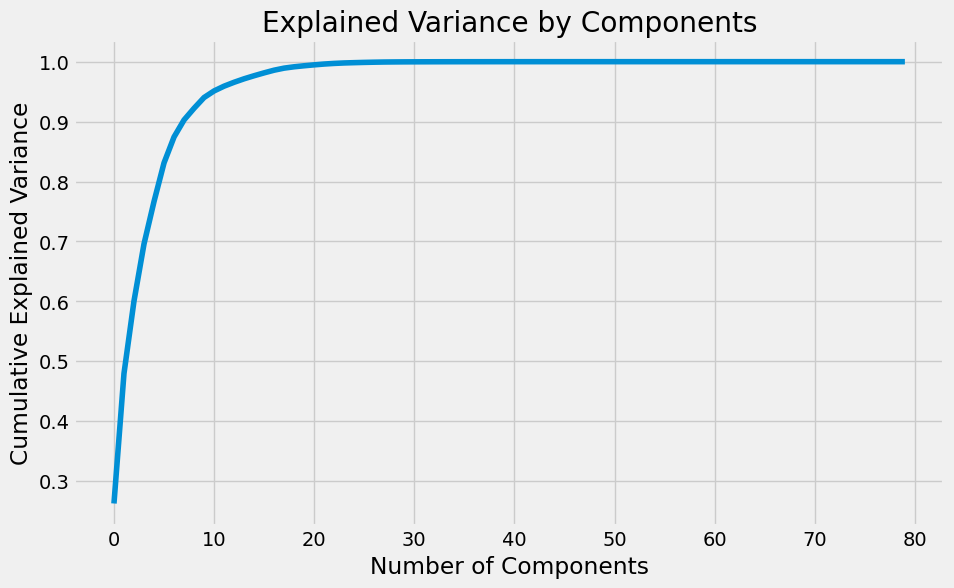

In [20]:
# Apply PCA to the scaled data without specifying n_components
pca = PCA()
pca.fit(df_scaled)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()


In [27]:
# Import data
df = pd.read_csv('df_post_eda.csv')

# Convert 'Date' to datetime and sort by 'Date' and 'Location'
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['Date', 'Location'])

# Identify categorical columns except 'Location'
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols.remove('Location')

# One-hot encode these categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols)

# 'Date' and 'Location' as indices
df_encoded.set_index(['Date', 'Location'], inplace=True)

# Additional time-series columns to account for 3-month pattern
df_encoded['Additional_Doses_Vax_Pct_3_m_lag'] = df_encoded[pred_var].shift(12)
df_encoded['Additional_Doses_Vax_Pct_9_m_lag'] = df_encoded[pred_var].shift(36)

# Rolling statistics
df_encoded['rolling_mean'] = df_encoded[pred_var].shift().rolling(window=12).mean()
df_encoded['rolling_std'] = df_encoded[pred_var].shift().rolling(window=12).std()

# Forward fill missing values
df_encoded.fillna(method='ffill', inplace=True)
df_encoded.fillna(method='bfill', inplace=True)

# Initialize MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

# Separate target variable
target_series = df_encoded[pred_var]

# Apply MinMaxScaler to df_encoded excluding target variable
df_features_scaled = pd.DataFrame(min_max_scaler.fit_transform(df_encoded.drop(pred_var, axis=1)),
                                  columns=df_encoded.drop(pred_var, axis=1).columns, 
                                  index=df_encoded.index)

# Define the number of components for PCA
n_components = 18

# Apply PCA to the scaled feature data
pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(df_features_scaled)

# Convert the PCA output to a DataFrame
df_pca = pd.DataFrame(df_pca, index=df_features_scaled.index)

# Function to create sequences for LSTM
def make_series(features, target, sequence_length):
    series = []
    for location, group in features.groupby(level='Location'):
        # Retrieve the corresponding target values for each location
        target_group = target.xs(location, level='Location')
        
        group = group.reset_index(level='Location', drop=True)
        for i in range(sequence_length, len(group)):
            sequence = group[i - sequence_length:i].values
            target_val = target_group.iloc[i - sequence_length]
            series.append((sequence, target_val))
    return series


# Set sequence length
sequence_length = 12

# Create sequences from the scaled PCA data
data_series = make_series(df_pca, target_series, sequence_length)

# Split into train and test sequences
test_size = 1080  # Size of test set
train_series = data_series[:-test_size]
test_series = data_series[-test_size:]

# Prepare data for LSTM
X_train = np.array([x[0] for x in train_series])  # Feature sequences
y_train = np.array([x[1] for x in train_series])  # Corresponding target values
X_test = np.array([x[0] for x in test_series])    # Feature sequences
y_test = np.array([x[1] for x in test_series])    # Corresponding target values

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [28]:
# Cross-Validation Loop
for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Define LSTM model
    inputs = Input(shape=(sequence_length, X_train_fold.shape[2]))
    lstm_out = LSTM(32, return_sequences=False)(inputs)
    lstm_out = Dropout(0.2)(lstm_out)
    outputs = Dense(1)(lstm_out)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mae')

    # Fit the model on this fold
    model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32,
              validation_data=(X_val_fold, y_val_fold), shuffle=False)

# Final Model Training on Full Train Data
model_final = Model(inputs=inputs, outputs=outputs)
model_final.compile(optimizer='adam', loss='mae')
model_final.fit(X_train, y_train, epochs=100, batch_size=32, shuffle=False)

# Final Model Evaluation on Test Data
y_pred_test = model_final.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Test RMSE: {test_rmse}")

Epoch 1/100
18/18 [==============================] - 3s 36ms/step - loss: 41.2700 - val_loss: 36.7901
Epoch 2/100
18/18 [==============================] - 0s 12ms/step - loss: 41.0454 - val_loss: 36.5897
Epoch 3/100
18/18 [==============================] - 0s 11ms/step - loss: 40.7073 - val_loss: 36.1942
Epoch 4/100
18/18 [==============================] - 0s 10ms/step - loss: 39.9047 - val_loss: 34.8702
Epoch 5/100
18/18 [==============================] - 0s 11ms/step - loss: 37.4582 - val_loss: 31.9053
Epoch 6/100
18/18 [==============================] - 0s 11ms/step - loss: 34.3959 - val_loss: 29.9369
Epoch 7/100
18/18 [==============================] - 0s 10ms/step - loss: 32.6451 - val_loss: 28.7394
Epoch 8/100
18/18 [==============================] - 0s 11ms/step - loss: 31.4477 - val_loss: 27.7984
Epoch 9/100
18/18 [==============================] - 0s 16ms/step - loss: 30.4212 - val_loss: 27.0170
Epoch 10/100
18/18 [==============================] - 0s 17ms/step - loss: 29.6309

34/34 [==============================] - 0s 9ms/step - loss: 3.6197 - val_loss: 2.7021
Epoch 63/100
34/34 [==============================] - 0s 11ms/step - loss: 3.6375 - val_loss: 2.7411
Epoch 64/100
34/34 [==============================] - 0s 9ms/step - loss: 3.7570 - val_loss: 2.5426
Epoch 65/100
34/34 [==============================] - 0s 10ms/step - loss: 3.6345 - val_loss: 2.7003
Epoch 66/100
34/34 [==============================] - 0s 9ms/step - loss: 3.4758 - val_loss: 3.6186
Epoch 67/100
34/34 [==============================] - 0s 9ms/step - loss: 3.5264 - val_loss: 2.5363
Epoch 68/100
34/34 [==============================] - 0s 9ms/step - loss: 3.4594 - val_loss: 2.7591
Epoch 69/100
34/34 [==============================] - 0s 9ms/step - loss: 3.4564 - val_loss: 2.4600
Epoch 70/100
34/34 [==============================] - 0s 9ms/step - loss: 3.4382 - val_loss: 2.8051
Epoch 71/100
34/34 [==============================] - 0s 9ms/step - loss: 3.4694 - val_loss: 2.7566
Epoch 72/10

68/68 [==============================] - 1s 12ms/step - loss: 4.8453 - val_loss: 3.7010
Epoch 25/100
68/68 [==============================] - 1s 13ms/step - loss: 4.6976 - val_loss: 3.4138
Epoch 26/100
68/68 [==============================] - 1s 12ms/step - loss: 4.4393 - val_loss: 3.2844
Epoch 27/100
68/68 [==============================] - 1s 12ms/step - loss: 4.3309 - val_loss: 2.9263
Epoch 28/100
68/68 [==============================] - 1s 12ms/step - loss: 4.1556 - val_loss: 2.9857
Epoch 29/100
68/68 [==============================] - 1s 12ms/step - loss: 4.2372 - val_loss: 2.9885
Epoch 30/100
68/68 [==============================] - 1s 12ms/step - loss: 4.0847 - val_loss: 2.4251
Epoch 31/100
68/68 [==============================] - 1s 12ms/step - loss: 3.8122 - val_loss: 2.4491
Epoch 32/100
68/68 [==============================] - 1s 13ms/step - loss: 3.8742 - val_loss: 2.6154
Epoch 33/100
68/68 [==============================] - 1s 16ms/step - loss: 3.7867 - val_loss: 2.4860
Epo

85/85 [==============================] - 1s 10ms/step - loss: 3.1711 - val_loss: 2.2443
Epoch 87/100
85/85 [==============================] - 1s 10ms/step - loss: 3.1630 - val_loss: 2.1885
Epoch 88/100
85/85 [==============================] - 1s 11ms/step - loss: 3.1326 - val_loss: 2.6047
Epoch 89/100
85/85 [==============================] - 1s 11ms/step - loss: 3.0922 - val_loss: 2.1033
Epoch 90/100
85/85 [==============================] - 1s 11ms/step - loss: 3.1721 - val_loss: 1.8741
Epoch 91/100
85/85 [==============================] - 1s 11ms/step - loss: 3.0409 - val_loss: 1.4296
Epoch 92/100
85/85 [==============================] - 1s 10ms/step - loss: 3.2003 - val_loss: 1.9129
Epoch 93/100
85/85 [==============================] - 1s 12ms/step - loss: 3.1350 - val_loss: 1.5444
Epoch 94/100
85/85 [==============================] - 1s 15ms/step - loss: 3.1073 - val_loss: 2.0192
Epoch 95/100
85/85 [==============================] - 1s 13ms/step - loss: 3.0853 - val_loss: 1.7759
Epo

102/102 [==============================] - 1s 11ms/step - loss: 2.9478
Epoch 82/100
102/102 [==============================] - 1s 10ms/step - loss: 2.8649
Epoch 83/100
102/102 [==============================] - 1s 9ms/step - loss: 2.8334
Epoch 84/100
102/102 [==============================] - 1s 9ms/step - loss: 2.8383
Epoch 85/100
102/102 [==============================] - 1s 9ms/step - loss: 2.9648
Epoch 86/100
102/102 [==============================] - 1s 9ms/step - loss: 2.8721
Epoch 87/100
102/102 [==============================] - 1s 9ms/step - loss: 2.8458
Epoch 88/100
102/102 [==============================] - 1s 9ms/step - loss: 2.9719
Epoch 89/100
102/102 [==============================] - 1s 12ms/step - loss: 2.8608
Epoch 90/100
102/102 [==============================] - 1s 13ms/step - loss: 2.8715
Epoch 91/100
102/102 [==============================] - 1s 10ms/step - loss: 2.9552
Epoch 92/100
102/102 [==============================] - 1s 9ms/step - loss: 2.8690
Epoch 93/100

<a id="LSTM-initial-models"></a>
#### Initial LSTM Models